Text(0, 0.5, 'Cycle life')

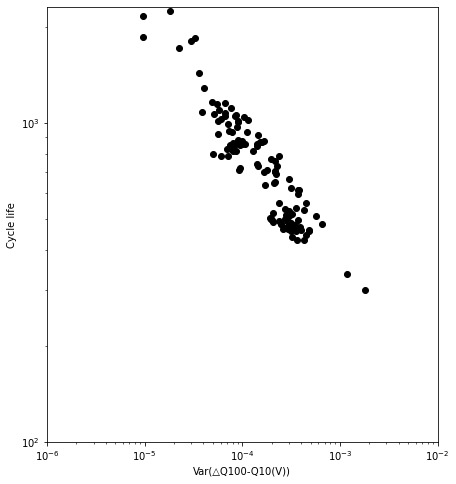

In [1]:
import h5py
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import pickle
import pandas as pd
import matplotlib.cm as cm
from scipy.signal import savgol_filter
from scipy import stats

batch1 = pickle.load(open(r'D:\논문 준비\코드 복사\코드 복사\코드 복사\batch1.pkl', 'rb'))
#remove batteries that do not reach 80% capacity
del batch1['b1c8']
del batch1['b1c10']
del batch1['b1c12']
del batch1['b1c13']
del batch1['b1c22']

numBat1 = len(batch1.keys())

batch2 = pickle.load(open(r'D:\논문 준비\코드 복사\코드 복사\코드 복사\batch2.pkl','rb'))
# There are four cells from batch1 that carried into batch2, we'll remove the data from batch2
# and put it with the correct cell from batch1
batch2_keys = ['b2c7', 'b2c8', 'b2c9', 'b2c15', 'b2c16']
batch1_keys = ['b1c0', 'b1c1', 'b1c2', 'b1c3', 'b1c4']
add_len = [662, 981, 1060, 208, 482];

for i, bk in enumerate(batch1_keys):
    batch1[bk]['cycle_life'] = batch1[bk]['cycle_life'] + add_len[i]
    for j in batch1[bk]['summary'].keys():
        if j == 'cycle':
            batch1[bk]['summary'][j] = np.hstack((batch1[bk]['summary'][j], batch2[batch2_keys[i]]['summary'][j] + len(batch1[bk]['summary'][j])))
        else:
            batch1[bk]['summary'][j] = np.hstack((batch1[bk]['summary'][j], batch2[batch2_keys[i]]['summary'][j]))
    last_cycle = len(batch1[bk]['cycles'].keys())
    for j, jk in enumerate(batch2[batch2_keys[i]]['cycles'].keys()):
        batch1[bk]['cycles'][str(last_cycle + j)] = batch2[batch2_keys[i]]['cycles'][jk]

del batch2['b2c7']
del batch2['b2c8']
del batch2['b2c9']
del batch2['b2c15']
del batch2['b2c16']

numBat2 = len(batch2.keys())

batch3 = pickle.load(open(r'D:\논문 준비\코드 복사\코드 복사\코드 복사\batch3.pkl','rb'))
# remove noisy channels from batch3
del batch3['b3c37']
del batch3['b3c2']
del batch3['b3c23']
del batch3['b3c32']
del batch3['b3c38']
del batch3['b3c39']

numBat3 = len(batch3.keys())
numBat = numBat1 + numBat2 + numBat3
bat_dict = {**batch1, **batch2, **batch3}

X=[]
Y=[]

for i,j in enumerate(bat_dict.keys()):
    if j=='b2c1':
        continue
    if j=='b3c16':
        continue
    if j=='b3c17':
        continue
    if j=='b3c42':
        continue
    if j=='b3c43':
        continue
    Qdlin10,Qdlin100=bat_dict[j]['cycles']['9']['Qdlin'],bat_dict[j]['cycles']['99']['Qdlin']
    diff=diff=Qdlin100-Qdlin10
    var,cycle=np.var(diff),bat_dict[j]['cycle_life'].tolist()
    X.append(var)
    Y.append(cycle[0][0])
    
plt.figure(figsize=(7,8))
plt.scatter(X,Y,color='black')
plt.xscale('log')
plt.yscale('log')
plt.axis([10**(-6),10**(-2),100,2300])
plt.xlabel('Var(△Q100-Q10(V))')
plt.ylabel('Cycle life')

In [2]:
cycle_test=bat_dict['b1c0']['cycle_life'].tolist()
cycle_test[0][0]

1852.0

In [3]:
test_ind = np.hstack((np.arange(0,(numBat1+numBat2),2),83))
train_ind = np.arange(1,(numBat1+numBat2-1),2)
secondary_test_ind = np.arange(numBat-numBat3,numBat);

In [4]:
np.random.seed(42)
threshold = 550

In [5]:
imax=150
jmax=150

def i_j_make():
    i_=[]
    j_=[]
    for i in range(2,imax+1): # 
        for j in range(1,jmax+1): # j
            if i<=j:
                continue
            i_.append(i)
            j_.append(j)
    return i_,j_

In [6]:
i_, j_ =i_j_make()

In [7]:
test_data=[]
train_data=[]

test_label=[]
train_label=[]

sec_data=[]
sec_label=[]
for i,j in enumerate(bat_dict.keys()):
    if j=='b2c1':
        continue
    if j=='b3c16':
        continue
    if j=='b3c17':
        continue
    if j=='b3c42':
        continue
    if j=='b3c43':
        continue
    if i in test_ind :
        test_data.append(j)
        cycle_test=bat_dict[j]['cycle_life'].tolist()
        test_label.append(cycle_test[0][0])
        
    if i in train_ind :
        train_data.append(j)
        cycle_train=bat_dict[j]['cycle_life'].tolist()
        train_label.append(cycle_train[0][0])
            
            
    if i in secondary_test_ind:
        sec_data.append(j)
        cycle_sec=bat_dict[j]['cycle_life'].tolist()
        sec_label.append(cycle_sec[0][0])

In [8]:
test_data=np.array(test_data)
train_data=np.array(train_data)
test_label=np.array(test_label)
train_label=np.array(train_label)
sec_label=np.array(sec_label)
sec_data=np.array(sec_data)

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LinearRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
def Logistic_RMSE(X,Y,boot_trainX,boot_trainY,boot_testX,boot_testY): #학습은 train data 로 진행 하고 predict는 랜덤 데이터 얻기
    Log_reg = LinearRegression()
    x=X.reshape(-1,1)
    Log_reg.fit(x,Y)
    train_X=boot_trainX.reshape(-1,1)
    test_X=boot_testX.reshape(-1,1)
    
    pred_train=Log_reg.predict(train_X.reshape(-1,1))
    pred_test=Log_reg.predict(test_X.reshape(-1,1))

    RMSE_train=mean_squared_error(boot_trainY,pred_train, squared=False)
    RMSE_test=mean_squared_error(boot_testY,pred_test, squared=False)

    
    return RMSE_train, RMSE_test



In [10]:
#train(i*j) AUC 구하기
mx_train=np.zeros((jmax+1,imax+1))
mx_test=np.zeros((jmax+1,imax+1))
for i,j in zip(i_,j_):
    var_=np.array([])
    var_test_=np.array([])
    var_sec_=np.array([])
    for k in train_data:
        diff=bat_dict[k]['cycles']['{}'.format(i)]['Qdlin']- bat_dict[k]['cycles']['{}'.format(j)]['Qdlin']
        var_=np.hstack([var_,np.var(diff)])
    for k in test_data:
        diff=bat_dict[k]['cycles']['{}'.format(i)]['Qdlin']- bat_dict[k]['cycles']['{}'.format(j)]['Qdlin']
        var_test_=np.hstack([var_test_,np.var(diff)])
    for k in sec_data:
        diff=bat_dict[k]['cycles']['{}'.format(i)]['Qdlin']- bat_dict[k]['cycles']['{}'.format(j)]['Qdlin']
        var_sec_=np.hstack([var_sec_,np.var(diff)])
    print(var_.shape,var_test_.shape,var_sec_.shape)
    

    
    #데이터 정규화(표준화, Z-scoring ,) , mean, std 구하기 뒤에 rmse 에 사용할 것.
    scaler = StandardScaler() 
    #train
    var_mean=np.mean(np.log(var_))
    var_std=np.std(np.log(var_))
    print('mean',var_mean,'std',var_std)
    var = scaler.fit_transform(np.log(var_).reshape(-1,1))
    var_test = scaler.transform(np.log(var_test_).reshape(-1,1))
    var_sec = scaler.transform(np.log(var_sec_).reshape(-1,1))   



    boot_select_train=len(var)
    boot_select_test=len(var_test)
    
    boot_sample=20
    
    train_range= range(0,boot_select_train) # 0~40 숫자중 41번 랜덤 선택하도록 한 후 배열에 이 숫자를 적용.
    test_range= range(0,boot_select_test)
    
    rmse_train=[]
    rmse_test=[]
    
    for _ in range(boot_sample):
        np.random.seed(9)
        sample_n=np.random.choice(train_range ,size=boot_select_train)
        sample_test=np.random.choice(test_range ,size=boot_select_test)
        random_trainX=np.array([])
        random_trainY=np.array([])
        random_testX=np.array([])
        random_testY=np.array([])
        for n in sample_n:
            random_trainX=np.hstack([random_trainX,np.array(var[n])])
            random_trainY=np.hstack([random_trainY,np.array([train_label[n]])])
        for n in sample_test:
            random_testX=np.hstack([random_testX,np.array(var_test[n])])
            random_testY=np.hstack([random_testY,np.array([test_label[n]])])
        RMSE_train, RMSE_test =Logistic_RMSE(var,train_label,random_trainX,random_trainY,random_testX,random_testY)
        rmse_train.append(RMSE_train)
        rmse_test.append(RMSE_test)
        
    rmse_train_cycle=np.mean(rmse_train)
    rmse_test_cycle=np.mean(rmse_test)

    print('i={},j={}   RMSE_train= '.format(i,j),rmse_train_cycle)
    print('i={},j={}   RMSE_test= '.format(i,j),rmse_test_cycle)
    print('\n')
    mx_train[j,i]= rmse_train_cycle
    mx_test[j,i]= rmse_test_cycle


(41,) (42,) (36,)
mean -12.99206075097377 std 1.7829928090282348
i=2,j=1   RMSE_train=  381.18008960127344
i=2,j=1   RMSE_test=  453.7367427389139


(41,) (42,) (36,)
mean -12.28316889759099 std 1.6885065160408774
i=3,j=1   RMSE_train=  394.941484011499
i=3,j=1   RMSE_test=  478.482251618347


(41,) (42,) (36,)
mean -13.824281509405603 std 1.4482326550769522
i=3,j=2   RMSE_train=  406.4891479576152
i=3,j=2   RMSE_test=  492.995739553608


(41,) (42,) (36,)
mean -12.253164981318871 std 0.8129985920852422
i=4,j=1   RMSE_train=  393.6910020026719
i=4,j=1   RMSE_test=  467.25787797133154


(41,) (42,) (36,)
mean -13.00111513895064 std 1.2347983102887559
i=4,j=2   RMSE_train=  392.51953134177046
i=4,j=2   RMSE_test=  462.48261805104113


(41,) (42,) (36,)
mean -13.149058136796047 std 1.7136532137585527
i=4,j=3   RMSE_train=  380.6534201438898
i=4,j=3   RMSE_test=  468.4136750609379


(41,) (42,) (36,)
mean -11.81405670323324 std 1.2748446743483928
i=5,j=1   RMSE_train=  411.1773328450312
i=

i=12,j=5   RMSE_train=  402.35817989506165
i=12,j=5   RMSE_test=  489.16251458096156


(41,) (42,) (36,)
mean -12.322217936098813 std 3.041142909845121
i=12,j=6   RMSE_train=  400.8780858975917
i=12,j=6   RMSE_test=  488.3538187108419


(41,) (42,) (36,)
mean -12.384563306530945 std 3.265743218465759
i=12,j=7   RMSE_train=  402.57831472015886
i=12,j=7   RMSE_test=  488.3661516196057


(41,) (42,) (36,)
mean -12.784508850824405 std 3.2320855909195574
i=12,j=8   RMSE_train=  399.08877434916127
i=12,j=8   RMSE_test=  490.5426496105788


(41,) (42,) (36,)
mean -12.813817371620267 std 3.3120358326606083
i=12,j=9   RMSE_train=  402.76442265849425
i=12,j=9   RMSE_test=  492.092099511109


(41,) (42,) (36,)
mean -12.626258979863337 std 3.348449479153637
i=12,j=10   RMSE_train=  395.38080705744943
i=12,j=10   RMSE_test=  486.3862158621905


(41,) (42,) (36,)
mean -12.737717091835462 std 4.543515341998518
i=12,j=11   RMSE_train=  382.6412478132915
i=12,j=11   RMSE_test=  472.8048847871766


(41,

(41,) (42,) (36,)
mean -12.960029739755823 std 3.099212732493249
i=16,j=11   RMSE_train=  337.3120970667626
i=16,j=11   RMSE_test=  415.7067180790879


(41,) (42,) (36,)
mean -12.63261410193749 std 3.065176900939285
i=16,j=12   RMSE_train=  402.5479607023751
i=16,j=12   RMSE_test=  490.96387297024023


(41,) (42,) (36,)
mean -14.136523006635382 std 1.2095047850532088
i=16,j=13   RMSE_train=  391.3082986869539
i=16,j=13   RMSE_test=  477.73597017215496


(41,) (42,) (36,)
mean -14.525114579551818 std 1.3084327693964972
i=16,j=14   RMSE_train=  386.2008799683717
i=16,j=14   RMSE_test=  472.3099767459844


(41,) (42,) (36,)
mean -14.265718815056417 std 2.2341894068081265
i=16,j=15   RMSE_train=  357.7729764883467
i=16,j=15   RMSE_test=  477.70358892834713


(41,) (42,) (36,)
mean -11.441677998128723 std 1.3121206321158032
i=17,j=1   RMSE_train=  387.98424026323744
i=17,j=1   RMSE_test=  479.74947721239175


(41,) (42,) (36,)
mean -12.236901928834207 std 0.7844228756024987
i=17,j=2   RMSE_

i=19,j=17   RMSE_train=  414.7948786749058
i=19,j=17   RMSE_test=  500.9574830997282


(41,) (42,) (36,)
mean -13.817407426159702 std 2.391021575172888
i=19,j=18   RMSE_train=  375.68504834785034
i=19,j=18   RMSE_test=  458.0069051628856


(41,) (42,) (36,)
mean -11.34514821782418 std 1.2769212977706874
i=20,j=1   RMSE_train=  383.4223105470083
i=20,j=1   RMSE_test=  471.73493198924353


(41,) (42,) (36,)
mean -12.013843694925946 std 0.779947207732303
i=20,j=2   RMSE_train=  379.88968782474626
i=20,j=2   RMSE_test=  470.4643936988873


(41,) (42,) (36,)
mean -12.409764992181952 std 0.6847094129302033
i=20,j=3   RMSE_train=  395.49641452119056
i=20,j=3   RMSE_test=  479.4407641625177


(41,) (42,) (36,)
mean -12.013389448029884 std 1.3139877024093245
i=20,j=4   RMSE_train=  342.58171693961447
i=20,j=4   RMSE_test=  438.4318121698828


(41,) (42,) (36,)
mean -12.320515649384184 std 0.8396632857201015
i=20,j=5   RMSE_train=  385.470504808705
i=20,j=5   RMSE_test=  465.01853485819976


(41

i=22,j=16   RMSE_train=  411.51478690119967
i=22,j=16   RMSE_test=  494.3813104857321


(41,) (42,) (36,)
mean -13.154100292995045 std 1.511894045167363
i=22,j=17   RMSE_train=  409.41189364944876
i=22,j=17   RMSE_test=  495.48658677101423


(41,) (42,) (36,)
mean -13.26538818754235 std 1.8829293479487585
i=22,j=18   RMSE_train=  396.1592410818903
i=22,j=18   RMSE_test=  502.4117685065973


(41,) (42,) (36,)
mean -14.044389458531507 std 1.3379101985999429
i=22,j=19   RMSE_train=  406.3269334553254
i=22,j=19   RMSE_test=  500.30238359105954


(41,) (42,) (36,)
mean -13.7998997239331 std 1.9597341981404917
i=22,j=20   RMSE_train=  392.7785086344992
i=22,j=20   RMSE_test=  473.2112899380233


(41,) (42,) (36,)
mean -14.430729775560588 std 2.213245638415994
i=22,j=21   RMSE_train=  381.2322352593859
i=22,j=21   RMSE_test=  474.73167590160955


(41,) (42,) (36,)
mean -11.361886089444699 std 1.0335979534815414
i=23,j=1   RMSE_train=  404.6385253625392
i=23,j=1   RMSE_test=  469.1947293046663

i=25,j=5   RMSE_train=  388.0966589426236
i=25,j=5   RMSE_test=  426.2329951813143


(41,) (42,) (36,)
mean -11.767537222520525 std 0.7099714039750294
i=25,j=6   RMSE_train=  363.7411758907464
i=25,j=6   RMSE_test=  369.4006039314676


(41,) (42,) (36,)
mean -11.709086250235666 std 0.8638482403602783
i=25,j=7   RMSE_train=  380.52467571244256
i=25,j=7   RMSE_test=  398.7201001812399


(41,) (42,) (36,)
mean -12.034631835012556 std 0.6619966992508786
i=25,j=8   RMSE_train=  392.048643566009
i=25,j=8   RMSE_test=  435.4768306939125


(41,) (42,) (36,)
mean -12.044876096799616 std 0.7230002121304603
i=25,j=9   RMSE_train=  396.74653232363835
i=25,j=9   RMSE_test=  461.97462470710525


(41,) (42,) (36,)
mean -11.904100105198934 std 0.926189266764334
i=25,j=10   RMSE_train=  402.52792763153076
i=25,j=10   RMSE_test=  457.28587441947155


(41,) (42,) (36,)
mean -11.556294454319122 std 2.7879417188121276
i=25,j=11   RMSE_train=  341.84820859332
i=25,j=11   RMSE_test=  423.85907020747254


(41

i=27,j=11   RMSE_train=  350.3633861720983
i=27,j=11   RMSE_test=  436.7130384615886


(41,) (42,) (36,)
mean -11.163013109073482 std 2.684820499629873
i=27,j=12   RMSE_train=  398.33516151202525
i=27,j=12   RMSE_test=  480.8477050085934


(41,) (42,) (36,)
mean -12.06100748684269 std 0.6313153587014337
i=27,j=13   RMSE_train=  339.81170506659976
i=27,j=13   RMSE_test=  392.9781873213354


(41,) (42,) (36,)
mean -11.821402567002378 std 1.021882762006925
i=27,j=14   RMSE_train=  403.4927733275114
i=27,j=14   RMSE_test=  441.00118838180134


(41,) (42,) (36,)
mean -12.043808611185035 std 1.061906488179061
i=27,j=15   RMSE_train=  385.8520573483435
i=27,j=15   RMSE_test=  479.03307289061706


(41,) (42,) (36,)
mean -12.214942142655287 std 1.0193237824023849
i=27,j=16   RMSE_train=  405.5121163782003
i=27,j=16   RMSE_test=  456.8170712432403


(41,) (42,) (36,)
mean -12.050610792110978 std 1.3675271072823048
i=27,j=17   RMSE_train=  399.28725462354214
i=27,j=17   RMSE_test=  467.8653022828

i=29,j=13   RMSE_train=  351.43882225656864
i=29,j=13   RMSE_test=  407.8950515470254


(41,) (42,) (36,)
mean -11.771221424750394 std 0.9364171367840094
i=29,j=14   RMSE_train=  382.39011024814874
i=29,j=14   RMSE_test=  410.67942240520614


(41,) (42,) (36,)
mean -11.757605645592793 std 1.1820256753258547
i=29,j=15   RMSE_train=  344.4699433578716
i=29,j=15   RMSE_test=  434.6765758102376


(41,) (42,) (36,)
mean -12.050232081208096 std 0.9906088917075266
i=29,j=16   RMSE_train=  379.0364930065768
i=29,j=16   RMSE_test=  419.2292259702679


(41,) (42,) (36,)
mean -12.098778460517966 std 1.027064083109958
i=29,j=17   RMSE_train=  379.2265438255216
i=29,j=17   RMSE_test=  435.6030866469033


(41,) (42,) (36,)
mean -12.024701297384716 std 1.3334251555175443
i=29,j=18   RMSE_train=  369.972896239792
i=29,j=18   RMSE_test=  450.29891882641994


(41,) (42,) (36,)
mean -12.458865563643842 std 1.0186750482631168
i=29,j=19   RMSE_train=  382.0031929742962
i=29,j=19   RMSE_test=  450.889786102

(41,) (42,) (36,)
mean -11.004756463804007 std 2.6560535117207067
i=31,j=11   RMSE_train=  352.09077262553285
i=31,j=11   RMSE_test=  435.86987575286986


(41,) (42,) (36,)
mean -11.066188324230495 std 2.698269249329153
i=31,j=12   RMSE_train=  366.79508466089135
i=31,j=12   RMSE_test=  465.46300523528015


(41,) (42,) (36,)
mean -11.612952624353918 std 0.6391662356133212
i=31,j=13   RMSE_train=  329.8679983258373
i=31,j=13   RMSE_test=  402.89318777698287


(41,) (42,) (36,)
mean -11.617925839755305 std 0.7651624759101998
i=31,j=14   RMSE_train=  299.4512859022426
i=31,j=14   RMSE_test=  325.3350070855838


(41,) (42,) (36,)
mean -11.78419629673661 std 1.044465679913798
i=31,j=15   RMSE_train=  302.03550930498466
i=31,j=15   RMSE_test=  399.22498860598955


(41,) (42,) (36,)
mean -11.904184107051263 std 0.7878573910374088
i=31,j=16   RMSE_train=  305.4060809374968
i=31,j=16   RMSE_test=  336.8511527102895


(41,) (42,) (36,)
mean -11.784129098748512 std 0.9504087892962779
i=31,j=17   

i=33,j=4   RMSE_train=  254.57292070390145
i=33,j=4   RMSE_test=  329.89627507089637


(41,) (42,) (36,)
mean -10.907408999539452 std 0.8706464937779455
i=33,j=5   RMSE_train=  256.9003518402487
i=33,j=5   RMSE_test=  301.1468761545508


(41,) (42,) (36,)
mean -10.841216520042295 std 0.957756160837142
i=33,j=6   RMSE_train=  299.37890874839843
i=33,j=6   RMSE_test=  344.8479347626477


(41,) (42,) (36,)
mean -11.104067680007596 std 0.7511840226592915
i=33,j=7   RMSE_train=  285.27311048751073
i=33,j=7   RMSE_test=  349.47086556536635


(41,) (42,) (36,)
mean -11.056327018311363 std 0.8860782736297509
i=33,j=8   RMSE_train=  242.95340432391095
i=33,j=8   RMSE_test=  281.2313413060286


(41,) (42,) (36,)
mean -10.983438413851864 std 0.927829592238638
i=33,j=9   RMSE_train=  276.1185911836491
i=33,j=9   RMSE_test=  327.8821761113447


(41,) (42,) (36,)
mean -11.240667521944383 std 0.7437419113052894
i=33,j=10   RMSE_train=  226.3623241113708
i=33,j=10   RMSE_test=  273.8669664372495


(41

i=34,j=26   RMSE_train=  363.67639072867564
i=34,j=26   RMSE_test=  439.44245848169174


(41,) (42,) (36,)
mean -12.67756480143212 std 1.4730738489751671
i=34,j=27   RMSE_train=  367.8046794956245
i=34,j=27   RMSE_test=  452.1130410494792


(41,) (42,) (36,)
mean -12.730908658571614 std 1.5530467536342412
i=34,j=28   RMSE_train=  353.0335077136932
i=34,j=28   RMSE_test=  424.89652547709164


(41,) (42,) (36,)
mean -12.741114000287705 std 1.8189504052696805
i=34,j=29   RMSE_train=  337.18294352735177
i=34,j=29   RMSE_test=  424.598158239787


(41,) (42,) (36,)
mean -13.370048262987455 std 1.7069190790628093
i=34,j=30   RMSE_train=  341.91177650699854
i=34,j=30   RMSE_test=  435.5307621405858


(41,) (42,) (36,)
mean -13.880706534484656 std 1.8239752750060505
i=34,j=31   RMSE_train=  348.03660252536434
i=34,j=31   RMSE_test=  448.885261858599


(41,) (42,) (36,)
mean -14.307491198227966 std 2.06425020426229
i=34,j=32   RMSE_train=  371.57979444545856
i=34,j=32   RMSE_test=  461.692548157

(41,) (42,) (36,)
mean -11.381631318613564 std 0.9399405175103281
i=36,j=15   RMSE_train=  275.2771165900516
i=36,j=15   RMSE_test=  401.1455301585119


(41,) (42,) (36,)
mean -11.42879626475356 std 0.7996812585086359
i=36,j=16   RMSE_train=  257.0894885770723
i=36,j=16   RMSE_test=  331.6748234815384


(41,) (42,) (36,)
mean -11.355772818987123 std 0.9279192884917867
i=36,j=17   RMSE_train=  267.7108307269656
i=36,j=17   RMSE_test=  363.8105071393196


(41,) (42,) (36,)
mean -11.504533868145469 std 1.0656735811159752
i=36,j=18   RMSE_train=  297.24151898687325
i=36,j=18   RMSE_test=  399.82506542444446


(41,) (42,) (36,)
mean -11.665879101988994 std 0.8701695632150893
i=36,j=19   RMSE_train=  215.75373245002115
i=36,j=19   RMSE_test=  303.52214082768654


(41,) (42,) (36,)
mean -11.542833573935047 std 1.1047738561258997
i=36,j=20   RMSE_train=  230.17878869738146
i=36,j=20   RMSE_test=  319.9546822990579


(41,) (42,) (36,)
mean -11.835757584571745 std 0.9152023932262918
i=36,j=21   

i=37,j=34   RMSE_train=  349.68018613570916
i=37,j=34   RMSE_test=  421.52146511381


(41,) (42,) (36,)
mean -13.915744530947698 std 2.3560070060302145
i=37,j=35   RMSE_train=  364.675113811765
i=37,j=35   RMSE_test=  442.2197109804282


(41,) (42,) (36,)
mean -14.352938846011831 std 2.1283734294735424
i=37,j=36   RMSE_train=  364.3732035428849
i=37,j=36   RMSE_test=  453.7573405118208


(41,) (42,) (36,)
mean -10.86346569027504 std 0.7373747958465333
i=38,j=1   RMSE_train=  326.0700476750325
i=38,j=1   RMSE_test=  375.3800225454749


(41,) (42,) (36,)
mean -10.666791084034022 std 0.8976532920470328
i=38,j=2   RMSE_train=  289.8000532476925
i=38,j=2   RMSE_test=  336.4149027818968


(41,) (42,) (36,)
mean -10.61817053725786 std 0.9436407722494622
i=38,j=3   RMSE_train=  302.09428932558995
i=38,j=3   RMSE_test=  330.57090900084415


(41,) (42,) (36,)
mean -10.798927749690943 std 0.8529517801463653
i=38,j=4   RMSE_train=  249.9271947241469
i=38,j=4   RMSE_test=  287.83664960757136


(41,

i=39,j=16   RMSE_train=  277.7019375276207
i=39,j=16   RMSE_test=  329.1982244360788


(41,) (42,) (36,)
mean -11.134531954118252 std 0.8143188633409397
i=39,j=17   RMSE_train=  264.03293666598097
i=39,j=17   RMSE_test=  342.6898102202288


(41,) (42,) (36,)
mean -11.317084846135016 std 0.9316541071225741
i=39,j=18   RMSE_train=  309.5386509382322
i=39,j=18   RMSE_test=  402.24629787102015


(41,) (42,) (36,)
mean -11.433119316793546 std 0.7834566545291282
i=39,j=19   RMSE_train=  277.7494081503163
i=39,j=19   RMSE_test=  355.7603419887379


(41,) (42,) (36,)
mean -11.344134197582106 std 0.8581773545241164
i=39,j=20   RMSE_train=  259.8610052956393
i=39,j=20   RMSE_test=  308.125065399211


(41,) (42,) (36,)
mean -11.600488444381101 std 0.7757496786329194
i=39,j=21   RMSE_train=  253.14496377410455
i=39,j=21   RMSE_test=  366.6747350714632


(41,) (42,) (36,)
mean -11.868503616651225 std 0.6878254143459633
i=39,j=22   RMSE_train=  280.64355330790534
i=39,j=22   RMSE_test=  370.15948690

i=40,j=33   RMSE_train=  264.5178890909338
i=40,j=33   RMSE_test=  333.696042656106


(41,) (42,) (36,)
mean -12.47646568462627 std 1.5879596507489169
i=40,j=34   RMSE_train=  338.57093222063185
i=40,j=34   RMSE_test=  401.57538272066466


(41,) (42,) (36,)
mean -12.74090138829928 std 1.656065122079864
i=40,j=35   RMSE_train=  364.3508891783325
i=40,j=35   RMSE_test=  423.0277244931484


(41,) (42,) (36,)
mean -13.213923107028325 std 1.3602575782553497
i=40,j=36   RMSE_train=  383.747037098983
i=40,j=36   RMSE_test=  445.32949695411105


(41,) (42,) (36,)
mean -12.990024864926854 std 1.7820001958297897
i=40,j=37   RMSE_train=  357.24242289674385
i=40,j=37   RMSE_test=  414.95319986408066


(41,) (42,) (36,)
mean -13.405491096801816 std 2.1068907837210777
i=40,j=38   RMSE_train=  361.0556835306845
i=40,j=38   RMSE_test=  440.9895245842762


(41,) (42,) (36,)
mean -14.338420999412067 std 1.846142988549073
i=40,j=39   RMSE_train=  340.63844943449556
i=40,j=39   RMSE_test=  414.00051138945

i=42,j=9   RMSE_train=  180.89015034675518
i=42,j=9   RMSE_test=  224.6879307367745


(41,) (42,) (36,)
mean -10.626034944086292 std 0.6822255176287478
i=42,j=10   RMSE_train=  254.62734173709947
i=42,j=10   RMSE_test=  269.1920418357851


(41,) (42,) (36,)
mean -10.114273701677387 std 2.5024252505486957
i=42,j=11   RMSE_train=  356.8108423568571
i=42,j=11   RMSE_test=  445.79160474842695


(41,) (42,) (36,)
mean -10.268358183293108 std 2.5012322891682834
i=42,j=12   RMSE_train=  384.48708202062863
i=42,j=12   RMSE_test=  466.98232805490954


(41,) (42,) (36,)
mean -10.76902982894415 std 0.6886455241564047
i=42,j=13   RMSE_train=  242.13873659635888
i=42,j=13   RMSE_test=  287.39953590567825


(41,) (42,) (36,)
mean -10.668443875226362 std 0.665365435714722
i=42,j=14   RMSE_train=  299.34961124726544
i=42,j=14   RMSE_test=  312.4786231551287


(41,) (42,) (36,)
mean -10.806987212128583 std 0.7893281467178777
i=42,j=15   RMSE_train=  305.1275485975432
i=42,j=15   RMSE_test=  385.6275429

i=43,j=23   RMSE_train=  315.88660537999044
i=43,j=23   RMSE_test=  377.3261196085201


(41,) (42,) (36,)
mean -11.340579398633524 std 1.0020109144492921
i=43,j=24   RMSE_train=  344.7322942066961
i=43,j=24   RMSE_test=  399.07814080698813


(41,) (42,) (36,)
mean -11.541901246457579 std 0.8405041162213898
i=43,j=25   RMSE_train=  330.7048044814382
i=43,j=25   RMSE_test=  406.8979723109699


(41,) (42,) (36,)
mean -11.459604446521032 std 0.917107118875729
i=43,j=26   RMSE_train=  287.8639513695497
i=43,j=26   RMSE_test=  365.11937508692915


(41,) (42,) (36,)
mean -11.662039512079831 std 0.9464437292991327
i=43,j=27   RMSE_train=  296.73437232494996
i=43,j=27   RMSE_test=  346.84499939486403


(41,) (42,) (36,)
mean -11.804659485610976 std 0.755712087083275
i=43,j=28   RMSE_train=  319.0666419692377
i=43,j=28   RMSE_test=  357.9313781101448


(41,) (42,) (36,)
mean -11.875591387226438 std 0.887589608754765
i=43,j=29   RMSE_train=  306.6402175043232
i=43,j=29   RMSE_test=  334.398876960

(41,) (42,) (36,)
mean -12.153350252614722 std 1.574891485784364
i=44,j=37   RMSE_train=  359.4508081348239
i=44,j=37   RMSE_test=  406.62177753493313


(41,) (42,) (36,)
mean -12.649419128291207 std 1.338177036830254
i=44,j=38   RMSE_train=  377.24965501009103
i=44,j=38   RMSE_test=  449.3716608109341


(41,) (42,) (36,)
mean -12.74892143063566 std 1.634309856643772
i=44,j=39   RMSE_train=  337.6799564368295
i=44,j=39   RMSE_test=  403.1465637101925


(41,) (42,) (36,)
mean -12.75054213136665 std 1.9610107620315844
i=44,j=40   RMSE_train=  347.53635596070944
i=44,j=40   RMSE_test=  423.3939381359799


(41,) (42,) (36,)
mean -14.03565879763261 std 1.2113899361982512
i=44,j=41   RMSE_train=  399.01709869544027
i=44,j=41   RMSE_test=  493.90456917316385


(41,) (42,) (36,)
mean -13.86941897898235 std 2.1707406964352116
i=44,j=42   RMSE_train=  376.48461278555095
i=44,j=42   RMSE_test=  471.61422492911095


(41,) (42,) (36,)
mean -14.057128203593729 std 2.6722020731405105
i=44,j=43   RMSE

i=46,j=4   RMSE_train=  260.3927024139383
i=46,j=4   RMSE_test=  336.93113968651056


(41,) (42,) (36,)
mean -10.228649964213695 std 0.8179650133166192
i=46,j=5   RMSE_train=  246.19166834458687
i=46,j=5   RMSE_test=  310.5992595658925


(41,) (42,) (36,)
mean -10.198196506080624 std 0.7872807411586825
i=46,j=6   RMSE_train=  245.3750875287485
i=46,j=6   RMSE_test=  311.15905463661994


(41,) (42,) (36,)
mean -10.289740288781994 std 0.806017151798878
i=46,j=7   RMSE_train=  289.0429356838234
i=46,j=7   RMSE_test=  347.4243648880845


(41,) (42,) (36,)
mean -10.304024830124348 std 0.794678900368745
i=46,j=8   RMSE_train=  232.0358342774063
i=46,j=8   RMSE_test=  300.9171173347358


(41,) (42,) (36,)
mean -10.277917805164495 std 0.7510331901741184
i=46,j=9   RMSE_train=  242.95725830719556
i=46,j=9   RMSE_test=  315.62711841770795


(41,) (42,) (36,)
mean -10.349919499230282 std 0.8582410516901943
i=46,j=10   RMSE_train=  239.66187706350198
i=46,j=10   RMSE_test=  299.18072984935145


(4

i=47,j=14   RMSE_train=  187.40211562248157
i=47,j=14   RMSE_test=  202.73008921795673


(41,) (42,) (36,)
mean -10.245134079877545 std 1.0936329824553952
i=47,j=15   RMSE_train=  160.68922196164036
i=47,j=15   RMSE_test=  194.13105187295096


(41,) (42,) (36,)
mean -10.233615854594156 std 1.0313620317037886
i=47,j=16   RMSE_train=  177.15590253033074
i=47,j=16   RMSE_test=  184.49909242072664


(41,) (42,) (36,)
mean -10.178221498528826 std 1.1543713629054937
i=47,j=17   RMSE_train=  203.44617215216613
i=47,j=17   RMSE_test=  220.9106969515861


(41,) (42,) (36,)
mean -10.52290132990626 std 0.9546951087285005
i=47,j=18   RMSE_train=  215.60698823871766
i=47,j=18   RMSE_test=  203.63287081371584


(41,) (42,) (36,)
mean -10.333004943889495 std 1.074005698577866
i=47,j=19   RMSE_train=  199.25684030124427
i=47,j=19   RMSE_test=  207.6648239649232


(41,) (42,) (36,)
mean -10.27158250324701 std 1.1540665953085911
i=47,j=20   RMSE_train=  254.11983005928937
i=47,j=20   RMSE_test=  271.135

i=48,j=22   RMSE_train=  173.67395608232428
i=48,j=22   RMSE_test=  218.40164287917705


(41,) (42,) (36,)
mean -10.769978451794067 std 0.7881523641941734
i=48,j=23   RMSE_train=  218.91254992959838
i=48,j=23   RMSE_test=  282.11803941910256


(41,) (42,) (36,)
mean -10.938404712794696 std 0.7567164315982409
i=48,j=24   RMSE_train=  274.7262167454818
i=48,j=24   RMSE_test=  342.19088240136153


(41,) (42,) (36,)
mean -10.832205684621393 std 0.7938532207979878
i=48,j=25   RMSE_train=  250.275825406961
i=48,j=25   RMSE_test=  319.3304897317765


(41,) (42,) (36,)
mean -10.79912219715488 std 0.9439836963129147
i=48,j=26   RMSE_train=  218.16341356975494
i=48,j=26   RMSE_test=  290.4676875887747


(41,) (42,) (36,)
mean -11.15138270649063 std 0.805576957993693
i=48,j=27   RMSE_train=  231.15513202167148
i=48,j=27   RMSE_test=  289.39845140228607


(41,) (42,) (36,)
mean -11.030283498872201 std 0.9385259262379367
i=48,j=28   RMSE_train=  159.66989613390507
i=48,j=28   RMSE_test=  198.819038

i=49,j=30   RMSE_train=  253.3408106841588
i=49,j=30   RMSE_test=  286.0276321703652


(41,) (42,) (36,)
mean -11.368760218758378 std 0.9655244226213354
i=49,j=31   RMSE_train=  284.66144768282004
i=49,j=31   RMSE_test=  318.9284997971974


(41,) (42,) (36,)
mean -11.581792451406674 std 0.8669425376123188
i=49,j=32   RMSE_train=  247.57391005567553
i=49,j=32   RMSE_test=  306.7533454647153


(41,) (42,) (36,)
mean -11.604500541118664 std 1.021864241156455
i=49,j=33   RMSE_train=  265.0537998171725
i=49,j=33   RMSE_test=  345.5372454194367


(41,) (42,) (36,)
mean -11.631236165192337 std 0.8820047901157886
i=49,j=34   RMSE_train=  312.77460230637524
i=49,j=34   RMSE_test=  347.97703771774763


(41,) (42,) (36,)
mean -11.793078122940614 std 0.9581156346031722
i=49,j=35   RMSE_train=  310.8236870717838
i=49,j=35   RMSE_test=  385.96196999978366


(41,) (42,) (36,)
mean -11.851247543375539 std 0.9552594847979623
i=49,j=36   RMSE_train=  326.06519367403524
i=49,j=36   RMSE_test=  391.566867

i=50,j=37   RMSE_train=  310.6973382052977
i=50,j=37   RMSE_test=  357.7981745451401


(41,) (42,) (36,)
mean -11.935723017770982 std 1.2681430698056668
i=50,j=38   RMSE_train=  281.61529771431293
i=50,j=38   RMSE_test=  376.24702452144567


(41,) (42,) (36,)
mean -11.93888697309715 std 1.4319662179046815
i=50,j=39   RMSE_train=  247.86902298774513
i=50,j=39   RMSE_test=  334.4442393763972


(41,) (42,) (36,)
mean -11.957669389353308 std 1.5723026750477305
i=50,j=40   RMSE_train=  217.64356052313528
i=50,j=40   RMSE_test=  321.9837740935579


(41,) (42,) (36,)
mean -12.563291697453282 std 1.0795210847033831
i=50,j=41   RMSE_train=  343.36087908727666
i=50,j=41   RMSE_test=  453.5617428450197


(41,) (42,) (36,)
mean -12.281467095285178 std 1.2517272821577783
i=50,j=42   RMSE_train=  370.60304680808355
i=50,j=42   RMSE_test=  438.575492246125


(41,) (42,) (36,)
mean -12.078939750965397 std 1.4442786726473917
i=50,j=43   RMSE_train=  352.0964597065092
i=50,j=43   RMSE_test=  413.5371209

(41,) (42,) (36,)
mean -11.958830439184648 std 1.1111452862542661
i=51,j=43   RMSE_train=  390.28842692654615
i=51,j=43   RMSE_test=  467.0404687501794


(41,) (42,) (36,)
mean -12.15898107706939 std 1.2709244632596448
i=51,j=44   RMSE_train=  400.6083523664503
i=51,j=44   RMSE_test=  488.3185540908363


(41,) (42,) (36,)
mean -12.38010578299819 std 1.279736301849217
i=51,j=45   RMSE_train=  404.67711915224453
i=51,j=45   RMSE_test=  492.07694031003876


(41,) (42,) (36,)
mean -12.01007208033352 std 1.5353285760042796
i=51,j=46   RMSE_train=  385.88661892720773
i=51,j=46   RMSE_test=  475.4012114644967


(41,) (42,) (36,)
mean -12.43689470801747 std 1.8139422033787367
i=51,j=47   RMSE_train=  403.7199510764621
i=51,j=47   RMSE_test=  488.1170339288534


(41,) (42,) (36,)
mean -13.249378167418438 std 1.8108993162047629
i=51,j=48   RMSE_train=  405.1267843552659
i=51,j=48   RMSE_test=  491.83746708458284


(41,) (42,) (36,)
mean -12.799124967861669 std 1.900460322508079
i=51,j=49   RMSE_

i=52,j=47   RMSE_train=  403.4552723325779
i=52,j=47   RMSE_test=  493.637540163207


(41,) (42,) (36,)
mean -12.239626039594656 std 1.789142139849214
i=52,j=48   RMSE_train=  403.05008015146205
i=52,j=48   RMSE_test=  492.6040392845456


(41,) (42,) (36,)
mean -12.75707703466199 std 1.8494849687759058
i=52,j=49   RMSE_train=  404.7686863545181
i=52,j=49   RMSE_test=  492.01172917060603


(41,) (42,) (36,)
mean -12.453472837913413 std 1.9841778858918178
i=52,j=50   RMSE_train=  394.22719818715444
i=52,j=50   RMSE_test=  482.2935909012678


(41,) (42,) (36,)
mean -12.95602367139972 std 1.7440097314203238
i=52,j=51   RMSE_train=  361.20547700404416
i=52,j=51   RMSE_test=  431.2455416461506


(41,) (42,) (36,)
mean -10.02390302134188 std 0.7493720197201845
i=53,j=1   RMSE_train=  283.3905630819599
i=53,j=1   RMSE_test=  323.7745718192244


(41,) (42,) (36,)
mean -9.889010899455412 std 0.8555368547229827
i=53,j=2   RMSE_train=  249.73569942244626
i=53,j=2   RMSE_test=  269.40759668979706



i=53,j=51   RMSE_train=  371.1908393303077
i=53,j=51   RMSE_test=  442.4204260964969


(41,) (42,) (36,)
mean -13.405756183593569 std 1.8334889781843038
i=53,j=52   RMSE_train=  357.9764046191816
i=53,j=52   RMSE_test=  448.4682046200376


(41,) (42,) (36,)
mean -9.986390667319382 std 0.7597651078192504
i=54,j=1   RMSE_train=  276.21230406611994
i=54,j=1   RMSE_test=  315.84993460142243


(41,) (42,) (36,)
mean -9.929236051658016 std 0.8259750877985811
i=54,j=2   RMSE_train=  252.55557321468254
i=54,j=2   RMSE_test=  282.31419570070017


(41,) (42,) (36,)
mean -9.861734601206832 std 0.8823734413738815
i=54,j=3   RMSE_train=  227.48972622178522
i=54,j=3   RMSE_test=  195.69386156204968


(41,) (42,) (36,)
mean -9.961777415031069 std 0.8656645475427789
i=54,j=4   RMSE_train=  229.95928872044232
i=54,j=4   RMSE_test=  260.87329475223015


(41,) (42,) (36,)
mean -9.899168037351169 std 0.9285438173027716
i=54,j=5   RMSE_train=  182.97456412261675
i=54,j=5   RMSE_test=  212.66268455307335




i=54,j=53   RMSE_train=  402.7720701226499
i=54,j=53   RMSE_test=  481.175006241681


(41,) (42,) (36,)
mean -9.921616432693037 std 0.8232145297570842
i=55,j=1   RMSE_train=  252.92962448079757
i=55,j=1   RMSE_test=  282.7920375480014


(41,) (42,) (36,)
mean -9.74250531781312 std 0.9694961580242119
i=55,j=2   RMSE_train=  253.31107380866987
i=55,j=2   RMSE_test=  271.5504681240071


(41,) (42,) (36,)
mean -9.685462066108268 std 1.0539072323362724
i=55,j=3   RMSE_train=  234.98793808506147
i=55,j=3   RMSE_test=  208.0701749483229


(41,) (42,) (36,)
mean -9.74860345335337 std 0.9350615928003353
i=55,j=4   RMSE_train=  208.56769367503162
i=55,j=4   RMSE_test=  240.0294315781874


(41,) (42,) (36,)
mean -9.66607309890822 std 1.0382900882722266
i=55,j=5   RMSE_train=  211.04666347429597
i=55,j=5   RMSE_test=  249.3161866791705


(41,) (42,) (36,)
mean -9.62169716157087 std 1.0029760169549207
i=55,j=6   RMSE_train=  246.236232423528
i=55,j=6   RMSE_test=  281.1923098135343


(41,) (42,) (3

(41,) (42,) (36,)
mean -9.704896974612323 std 0.8718545766924449
i=56,j=2   RMSE_train=  220.89310150171178
i=56,j=2   RMSE_test=  231.67744713994017


(41,) (42,) (36,)
mean -9.622954875756532 std 0.9601057829930151
i=56,j=3   RMSE_train=  197.04433554653468
i=56,j=3   RMSE_test=  162.32748477626427


(41,) (42,) (36,)
mean -9.701819690002077 std 0.8712316467195971
i=56,j=4   RMSE_train=  202.47609146474585
i=56,j=4   RMSE_test=  223.61581814159416


(41,) (42,) (36,)
mean -9.602207448635413 std 0.9438375577791162
i=56,j=5   RMSE_train=  174.47512410580492
i=56,j=5   RMSE_test=  209.60927686117572


(41,) (42,) (36,)
mean -9.543474927910852 std 0.8948485015099976
i=56,j=6   RMSE_train=  201.36316933064444
i=56,j=6   RMSE_test=  239.44675437259676


(41,) (42,) (36,)
mean -9.742239440741407 std 0.8104712287970088
i=56,j=7   RMSE_train=  203.3800201272943
i=56,j=7   RMSE_test=  251.15049820816571


(41,) (42,) (36,)
mean -9.667391407474657 std 0.9605771375104819
i=56,j=8   RMSE_train=  

i=57,j=1   RMSE_train=  267.244779811852
i=57,j=1   RMSE_test=  276.32524905496746


(41,) (42,) (36,)
mean -9.720642427467292 std 0.9225555254256484
i=57,j=2   RMSE_train=  224.98970651011922
i=57,j=2   RMSE_test=  222.23625246816647


(41,) (42,) (36,)
mean -9.631072559384185 std 0.946164793890819
i=57,j=3   RMSE_train=  204.73812818446032
i=57,j=3   RMSE_test=  162.4641632176254


(41,) (42,) (36,)
mean -9.685627505323751 std 0.945555400060603
i=57,j=4   RMSE_train=  202.16328315934078
i=57,j=4   RMSE_test=  205.91083726365272


(41,) (42,) (36,)
mean -9.60356695273882 std 0.9974100601310167
i=57,j=5   RMSE_train=  169.88425374453894
i=57,j=5   RMSE_test=  209.79316684970186


(41,) (42,) (36,)
mean -9.56280578402487 std 0.9595865779444198
i=57,j=6   RMSE_train=  174.66163992122836
i=57,j=6   RMSE_test=  208.41474444183373


(41,) (42,) (36,)
mean -9.726098871491033 std 0.9360195774395449
i=57,j=7   RMSE_train=  193.00064885739437
i=57,j=7   RMSE_test=  239.69774439133366


(41,) (4

i=57,j=56   RMSE_train=  367.6956036424348
i=57,j=56   RMSE_test=  453.8088340855194


(41,) (42,) (36,)
mean -9.797255726655804 std 0.8844684799703917
i=58,j=1   RMSE_train=  227.4052306219183
i=58,j=1   RMSE_test=  271.3541805144895


(41,) (42,) (36,)
mean -9.563021526703 std 1.043825606561143
i=58,j=2   RMSE_train=  225.73424048556276
i=58,j=2   RMSE_test=  259.0138248149053


(41,) (42,) (36,)
mean -9.500337460898617 std 1.1055397565728298
i=58,j=3   RMSE_train=  201.16295984448158
i=58,j=3   RMSE_test=  200.71805125719783


(41,) (42,) (36,)
mean -9.542624981561943 std 0.9637360991500515
i=58,j=4   RMSE_train=  180.14686259620885
i=58,j=4   RMSE_test=  234.89065256882887


(41,) (42,) (36,)
mean -9.437367213942004 std 1.0320272774150037
i=58,j=5   RMSE_train=  190.09376315671815
i=58,j=5   RMSE_test=  245.531568619933


(41,) (42,) (36,)
mean -9.398821706728373 std 1.0123744088871596
i=58,j=6   RMSE_train=  221.18842129658213
i=58,j=6   RMSE_test=  266.421644571077


(41,) (42,) 

i=58,j=55   RMSE_train=  369.3472228492191
i=58,j=55   RMSE_test=  430.9771562097664


(41,) (42,) (36,)
mean -13.140119632692388 std 2.2865333127573995
i=58,j=56   RMSE_train=  355.1405641467587
i=58,j=56   RMSE_test=  430.7874917543787


(41,) (42,) (36,)
mean -13.725097106113667 std 2.755659069158103
i=58,j=57   RMSE_train=  378.52801803926263
i=58,j=57   RMSE_test=  459.94883398504754


(41,) (42,) (36,)
mean -9.839274812027822 std 0.8375889970339941
i=59,j=1   RMSE_train=  230.52876371730628
i=59,j=1   RMSE_test=  299.6186150092241


(41,) (42,) (36,)
mean -9.664638844208648 std 0.9131112940387244
i=59,j=2   RMSE_train=  204.08027777448154
i=59,j=2   RMSE_test=  260.8424977557803


(41,) (42,) (36,)
mean -9.581251065617103 std 0.9905551123842148
i=59,j=3   RMSE_train=  164.45408524719764
i=59,j=3   RMSE_test=  195.30603078236618


(41,) (42,) (36,)
mean -9.63427550081493 std 0.8845098284288673
i=59,j=4   RMSE_train=  189.81866735079706
i=59,j=4   RMSE_test=  247.17939922248743


(

i=59,j=52   RMSE_train=  390.1622730287273
i=59,j=52   RMSE_test=  485.68272548187605


(41,) (42,) (36,)
mean -12.217234107546002 std 1.6144961257329733
i=59,j=53   RMSE_train=  408.3416480175959
i=59,j=53   RMSE_test=  491.76625947418205


(41,) (42,) (36,)
mean -12.039782914892236 std 1.4103088338642993
i=59,j=54   RMSE_train=  398.90137211765557
i=59,j=54   RMSE_test=  486.3547017337008


(41,) (42,) (36,)
mean -12.54964455842153 std 1.6364440475127233
i=59,j=55   RMSE_train=  350.06870634196025
i=59,j=55   RMSE_test=  472.4330587149728


(41,) (42,) (36,)
mean -14.353977867338882 std 1.41383168557444
i=59,j=56   RMSE_train=  404.54586298749024
i=59,j=56   RMSE_test=  493.9635644118531


(41,) (42,) (36,)
mean -13.736238015113447 std 2.0540971725190924
i=59,j=57   RMSE_train=  382.852894542614
i=59,j=57   RMSE_test=  487.53071088582345


(41,) (42,) (36,)
mean -14.13897094585944 std 2.7237525405606138
i=59,j=58   RMSE_train=  335.38074994715805
i=59,j=58   RMSE_test=  460.402673694

i=60,j=49   RMSE_train=  325.76946932916707
i=60,j=49   RMSE_test=  463.0138400280542


(41,) (42,) (36,)
mean -12.188834056010727 std 0.9668126152231727
i=60,j=50   RMSE_train=  348.0897409064794
i=60,j=50   RMSE_test=  469.3791264379257


(41,) (42,) (36,)
mean -11.876653511378738 std 1.1528903522988392
i=60,j=51   RMSE_train=  391.20372435460985
i=60,j=51   RMSE_test=  491.74117933504493


(41,) (42,) (36,)
mean -11.54225475149313 std 1.3370351051513407
i=60,j=52   RMSE_train=  393.28528065976514
i=60,j=52   RMSE_test=  493.5594342322221


(41,) (42,) (36,)
mean -12.126678540641 std 1.5769295848895868
i=60,j=53   RMSE_train=  404.62816146099226
i=60,j=53   RMSE_test=  492.0646865835735


(41,) (42,) (36,)
mean -12.539009314919815 std 1.6796818046430697
i=60,j=54   RMSE_train=  403.6928951388055
i=60,j=54   RMSE_test=  492.15115910209954


(41,) (42,) (36,)
mean -12.610417479190875 std 1.7849860319653492
i=60,j=55   RMSE_train=  343.8270869928914
i=60,j=55   RMSE_test=  476.096011824

i=61,j=45   RMSE_train=  277.9911147582788
i=61,j=45   RMSE_test=  368.761077671793


(41,) (42,) (36,)
mean -11.34144708299784 std 1.445312485854451
i=61,j=46   RMSE_train=  279.4117262329786
i=61,j=46   RMSE_test=  374.0062863272989


(41,) (42,) (36,)
mean -11.96868444129202 std 0.8233719977476011
i=61,j=47   RMSE_train=  248.63951846335357
i=61,j=47   RMSE_test=  399.0431154612212


(41,) (42,) (36,)
mean -11.706705932639014 std 1.1982174516297768
i=61,j=48   RMSE_train=  318.77150132351755
i=61,j=48   RMSE_test=  436.8887993808256


(41,) (42,) (36,)
mean -11.729515910577517 std 1.2580206172309083
i=61,j=49   RMSE_train=  365.8594686919638
i=61,j=49   RMSE_test=  465.57847835572227


(41,) (42,) (36,)
mean -11.713274278795986 std 1.0043777120331663
i=61,j=50   RMSE_train=  336.54625550624644
i=61,j=50   RMSE_test=  469.3088457622938


(41,) (42,) (36,)
mean -11.15869158830562 std 1.209764909443022
i=61,j=51   RMSE_train=  382.62213589838825
i=61,j=51   RMSE_test=  487.452068802430

i=62,j=40   RMSE_train=  156.87597221240654
i=62,j=40   RMSE_test=  305.84970301707256


(41,) (42,) (36,)
mean -11.204102882130162 std 0.9295623436105411
i=62,j=41   RMSE_train=  219.12358307916128
i=62,j=41   RMSE_test=  384.00747508582754


(41,) (42,) (36,)
mean -11.106190332200198 std 0.9485634898077855
i=62,j=42   RMSE_train=  190.09481947968817
i=62,j=42   RMSE_test=  374.13359680195697


(41,) (42,) (36,)
mean -11.064243769865302 std 1.0708814603918433
i=62,j=43   RMSE_train=  207.08915373318027
i=62,j=43   RMSE_test=  353.66170165294614


(41,) (42,) (36,)
mean -11.529767306952506 std 0.785707753299338
i=62,j=44   RMSE_train=  180.43442717806118
i=62,j=44   RMSE_test=  352.256670179249


(41,) (42,) (36,)
mean -11.330429232189775 std 0.9214741740691795
i=62,j=45   RMSE_train=  235.86611418622684
i=62,j=45   RMSE_test=  361.11328744859935


(41,) (42,) (36,)
mean -11.315340735408771 std 1.1500770392256578
i=62,j=46   RMSE_train=  238.12176628026072
i=62,j=46   RMSE_test=  365.4

i=63,j=34   RMSE_train=  260.40540911596975
i=63,j=34   RMSE_test=  347.6450267225331


(41,) (42,) (36,)
mean -10.675284528251304 std 0.7202981291618807
i=63,j=35   RMSE_train=  297.8635344001742
i=63,j=35   RMSE_test=  380.1392419218813


(41,) (42,) (36,)
mean -10.529083277241293 std 0.7555863556600495
i=63,j=36   RMSE_train=  274.3165315815714
i=63,j=36   RMSE_test=  358.36863183353546


(41,) (42,) (36,)
mean -10.457260168083524 std 0.8638662704613237
i=63,j=37   RMSE_train=  286.25048922671874
i=63,j=37   RMSE_test=  350.94215207752165


(41,) (42,) (36,)
mean -10.678147663597123 std 0.9445756177557227
i=63,j=38   RMSE_train=  270.4686851394551
i=63,j=38   RMSE_test=  347.9330984619283


(41,) (42,) (36,)
mean -10.662888807774149 std 0.9442808120236803
i=63,j=39   RMSE_train=  276.3262448441919
i=63,j=39   RMSE_test=  353.76493795593433


(41,) (42,) (36,)
mean -10.678064560281342 std 1.0937645506190483
i=63,j=40   RMSE_train=  282.3493729067976
i=63,j=40   RMSE_test=  375.496270

i=64,j=27   RMSE_train=  240.250549880573
i=64,j=27   RMSE_test=  263.708815980951


(41,) (42,) (36,)
mean -9.875110300396662 std 0.9309729639801462
i=64,j=28   RMSE_train=  303.41236221417955
i=64,j=28   RMSE_test=  326.2136083756908


(41,) (42,) (36,)
mean -9.93106430309725 std 0.9602585267321005
i=64,j=29   RMSE_train=  325.9406077035343
i=64,j=29   RMSE_test=  357.6476333680793


(41,) (42,) (36,)
mean -10.149827214170601 std 0.7665821181291121
i=64,j=30   RMSE_train=  331.27034808671743
i=64,j=30   RMSE_test=  357.34707056550167


(41,) (42,) (36,)
mean -10.087615509313238 std 0.8821857322762433
i=64,j=31   RMSE_train=  342.66448594630754
i=64,j=31   RMSE_test=  376.8018081778726


(41,) (42,) (36,)
mean -10.17625439449432 std 0.9009943530513678
i=64,j=32   RMSE_train=  346.81416139962687
i=64,j=32   RMSE_test=  374.25627323284976


(41,) (42,) (36,)
mean -10.279243562784622 std 0.8184029865138256
i=64,j=33   RMSE_train=  333.96365318880794
i=64,j=33   RMSE_test=  370.7885186543

(41,) (42,) (36,)
mean -9.59537677146346 std 0.8156948192358926
i=65,j=20   RMSE_train=  316.89185929586745
i=65,j=20   RMSE_test=  329.84918073612755


(41,) (42,) (36,)
mean -9.807272286996039 std 0.7661377701170398
i=65,j=21   RMSE_train=  311.15500666475424
i=65,j=21   RMSE_test=  334.7682525024838


(41,) (42,) (36,)
mean -9.819627251696938 std 0.7167620156054683
i=65,j=22   RMSE_train=  292.2260797955815
i=65,j=22   RMSE_test=  293.65911042790964


(41,) (42,) (36,)
mean -9.845229852038022 std 0.7300040211462758
i=65,j=23   RMSE_train=  304.1598830013828
i=65,j=23   RMSE_test=  313.58622897556575


(41,) (42,) (36,)
mean -9.982521822309208 std 0.6902917868452926
i=65,j=24   RMSE_train=  309.34508837670217
i=65,j=24   RMSE_test=  326.3317604571681


(41,) (42,) (36,)
mean -9.900343580711338 std 0.7447740619137697
i=65,j=25   RMSE_train=  282.5314001435218
i=65,j=25   RMSE_test=  278.58858623401386


(41,) (42,) (36,)
mean -9.85632381575989 std 0.7831487666099947
i=65,j=26   RMSE_t

i=66,j=14   RMSE_train=  333.05720823207037
i=66,j=14   RMSE_test=  361.10165945362303


(41,) (42,) (36,)
mean -9.457029828748976 std 0.7110090648789157
i=66,j=15   RMSE_train=  331.2384536459989
i=66,j=15   RMSE_test=  387.53319340789056


(41,) (42,) (36,)
mean -9.450117561133675 std 0.6867192901632887
i=66,j=16   RMSE_train=  333.04462894142273
i=66,j=16   RMSE_test=  364.95989356676114


(41,) (42,) (36,)
mean -9.423521107800052 std 0.719796326698161
i=66,j=17   RMSE_train=  327.70466155104106
i=66,j=17   RMSE_test=  368.0674336322535


(41,) (42,) (36,)
mean -9.543371079675223 std 0.6942471809062517
i=66,j=18   RMSE_train=  351.8774195839877
i=66,j=18   RMSE_test=  397.88524892833436


(41,) (42,) (36,)
mean -9.52043118958384 std 0.6850225024964627
i=66,j=19   RMSE_train=  337.3293641527122
i=66,j=19   RMSE_test=  363.84407727361383


(41,) (42,) (36,)
mean -9.500406317006956 std 0.7502631498027729
i=66,j=20   RMSE_train=  308.69649745392604
i=66,j=20   RMSE_test=  326.0242153073

i=67,j=4   RMSE_test=  282.46490928064657


(41,) (42,) (36,)
mean -9.18500233090359 std 0.8491229885143677
i=67,j=5   RMSE_train=  169.8581099838324
i=67,j=5   RMSE_test=  281.78359282157373


(41,) (42,) (36,)
mean -9.166952073401594 std 0.8861228566644218
i=67,j=6   RMSE_train=  209.97839546080235
i=67,j=6   RMSE_test=  298.1267003959183


(41,) (42,) (36,)
mean -9.340904143121541 std 0.797794371374832
i=67,j=7   RMSE_train=  203.23144961914792
i=67,j=7   RMSE_test=  306.489056030895


(41,) (42,) (36,)
mean -9.26058203709587 std 0.877581136692328
i=67,j=8   RMSE_train=  212.75367503353533
i=67,j=8   RMSE_test=  287.9475605388685


(41,) (42,) (36,)
mean -9.223661504123132 std 0.86037924055529
i=67,j=9   RMSE_train=  233.6669742351854
i=67,j=9   RMSE_test=  297.4630988433391


(41,) (42,) (36,)
mean -9.366158123014824 std 0.828208869418727
i=67,j=10   RMSE_train=  206.01352954380295
i=67,j=10   RMSE_test=  283.45559305006117


(41,) (42,) (36,)
mean -8.841257597540924 std 2.33026111

(41,) (42,) (36,)
mean -12.185607849859942 std 1.3346548642151783
i=67,j=60   RMSE_train=  408.638047062789
i=67,j=60   RMSE_test=  496.0213243767189


(41,) (42,) (36,)
mean -12.856304446932945 std 1.3929976073808343
i=67,j=61   RMSE_train=  404.8663180136228
i=67,j=61   RMSE_test=  492.65576967917497


(41,) (42,) (36,)
mean -12.87885129711715 std 1.396149878481987
i=67,j=62   RMSE_train=  395.9842536413099
i=67,j=62   RMSE_test=  478.2929757686162


(41,) (42,) (36,)
mean -12.602676862315356 std 1.5600184867101687
i=67,j=63   RMSE_train=  400.80323378652497
i=67,j=63   RMSE_test=  488.7668053874078


(41,) (42,) (36,)
mean -13.669823151372626 std 1.6625996922521868
i=67,j=64   RMSE_train=  344.93232173052917
i=67,j=64   RMSE_test=  458.2663155187571


(41,) (42,) (36,)
mean -13.502719298821583 std 1.8847479121992596
i=67,j=65   RMSE_train=  403.7517472568788
i=67,j=65   RMSE_test=  491.3970339858485


(41,) (42,) (36,)
mean -13.563910175232145 std 2.291108375925684
i=67,j=66   RMSE_

i=68,j=48   RMSE_train=  275.3700137756811
i=68,j=48   RMSE_test=  380.3092693608472


(41,) (42,) (36,)
mean -11.214327525764762 std 0.8014441673470655
i=68,j=49   RMSE_train=  325.07433617593057
i=68,j=49   RMSE_test=  417.7042209152749


(41,) (42,) (36,)
mean -11.169510737533196 std 0.8918376412918644
i=68,j=50   RMSE_train=  345.15144589241936
i=68,j=50   RMSE_test=  432.7097196340175


(41,) (42,) (36,)
mean -10.83829696319095 std 0.8260187875418851
i=68,j=51   RMSE_train=  391.92994628732885
i=68,j=51   RMSE_test=  467.5193827784992


(41,) (42,) (36,)
mean -10.670926102305781 std 0.8811749959615285
i=68,j=52   RMSE_train=  407.3383292467877
i=68,j=52   RMSE_test=  498.00905391934947


(41,) (42,) (36,)
mean -10.979529618854587 std 1.1221599003935323
i=68,j=53   RMSE_train=  411.2921881981898
i=68,j=53   RMSE_test=  514.7966335319597


(41,) (42,) (36,)
mean -11.07112044271344 std 1.0843255968843348
i=68,j=54   RMSE_train=  409.0152561261409
i=68,j=54   RMSE_test=  508.334743010

i=69,j=36   RMSE_train=  231.74973688885706
i=69,j=36   RMSE_test=  250.38818444230037


(41,) (42,) (36,)
mean -10.183569235724354 std 0.932978357114729
i=69,j=37   RMSE_train=  223.1588401731493
i=69,j=37   RMSE_test=  224.2854273993807


(41,) (42,) (36,)
mean -10.31241142737924 std 1.0330210898187553
i=69,j=38   RMSE_train=  186.01696864595957
i=69,j=38   RMSE_test=  228.02739598190956


(41,) (42,) (36,)
mean -10.337372648466364 std 1.024065984180226
i=69,j=39   RMSE_train=  201.56925211525763
i=69,j=39   RMSE_test=  249.79631607340247


(41,) (42,) (36,)
mean -10.328842672423344 std 1.0981730601567834
i=69,j=40   RMSE_train=  197.98445483510264
i=69,j=40   RMSE_test=  253.60885246846047


(41,) (42,) (36,)
mean -10.527883770973446 std 0.9379238049282961
i=69,j=41   RMSE_train=  235.61110307802727
i=69,j=41   RMSE_test=  298.8369071411504


(41,) (42,) (36,)
mean -10.57909047524522 std 0.9924872871212741
i=69,j=42   RMSE_train=  248.6944677740476
i=69,j=42   RMSE_test=  312.369234

i=70,j=23   RMSE_train=  196.0469237265144
i=70,j=23   RMSE_test=  234.07350438047425


(41,) (42,) (36,)
mean -9.767871217997026 std 0.8236885805650069
i=70,j=24   RMSE_train=  189.34989037450902
i=70,j=24   RMSE_test=  233.49709067960254


(41,) (42,) (36,)
mean -9.623465035603264 std 0.9425562653177151
i=70,j=25   RMSE_train=  200.4119917370136
i=70,j=25   RMSE_test=  241.7062519552397


(41,) (42,) (36,)
mean -9.615225017964816 std 1.039067150028122
i=70,j=26   RMSE_train=  173.48776344918278
i=70,j=26   RMSE_test=  227.24333225268393


(41,) (42,) (36,)
mean -9.831318004060376 std 0.9603565581674287
i=70,j=27   RMSE_train=  127.74939376661818
i=70,j=27   RMSE_test=  178.5251151131214


(41,) (42,) (36,)
mean -9.715575371378467 std 1.0159404690815652
i=70,j=28   RMSE_train=  168.08752251451494
i=70,j=28   RMSE_test=  194.240872330976


(41,) (42,) (36,)
mean -9.779844173704893 std 1.0741650864257812
i=70,j=29   RMSE_train=  168.25174747438078
i=70,j=29   RMSE_test=  189.33049993530

(41,) (42,) (36,)
mean -9.203326581214249 std 0.962505388646762
i=71,j=9   RMSE_train=  128.70525766049224
i=71,j=9   RMSE_test=  186.4244807229387


(41,) (42,) (36,)
mean -9.28191332735057 std 0.8422955349566316
i=71,j=10   RMSE_train=  145.10196500183002
i=71,j=10   RMSE_test=  171.25681390371537


(41,) (42,) (36,)
mean -8.754256140479052 std 2.2847710482408217
i=71,j=11   RMSE_train=  376.6655838759432
i=71,j=11   RMSE_test=  471.3975138125537


(41,) (42,) (36,)
mean -8.952255214094178 std 2.37318719121376
i=71,j=12   RMSE_train=  351.1452672922867
i=71,j=12   RMSE_test=  426.6718797974287


(41,) (42,) (36,)
mean -9.318911037532724 std 0.8332934011270704
i=71,j=13   RMSE_train=  143.93128628282696
i=71,j=13   RMSE_test=  189.22944594661925


(41,) (42,) (36,)
mean -9.250572919548043 std 0.796300874379426
i=71,j=14   RMSE_train=  162.7157346699284
i=71,j=14   RMSE_test=  172.40916805986228


(41,) (42,) (36,)
mean -9.363897083199797 std 0.8630320816113188
i=71,j=15   RMSE_train= 

i=71,j=63   RMSE_train=  393.9248959936475
i=71,j=63   RMSE_test=  518.7885688824758


(41,) (42,) (36,)
mean -12.473842393496291 std 1.1050697711366098
i=71,j=64   RMSE_train=  415.05602638127704
i=71,j=64   RMSE_test=  498.109771619533


(41,) (42,) (36,)
mean -12.77940556470102 std 1.1197680294134864
i=71,j=65   RMSE_train=  366.1034537693329
i=71,j=65   RMSE_test=  479.26864136764


(41,) (42,) (36,)
mean -12.538547809505422 std 1.3860564694087696
i=71,j=66   RMSE_train=  395.96004466929304
i=71,j=66   RMSE_test=  493.56342684351284


(41,) (42,) (36,)
mean -12.931207572011209 std 1.6533332922339397
i=71,j=67   RMSE_train=  401.689675206629
i=71,j=67   RMSE_test=  491.55075465208256


(41,) (42,) (36,)
mean -13.42106364301555 std 1.5731498367877779
i=71,j=68   RMSE_train=  404.64555947866
i=71,j=68   RMSE_test=  492.89397511984725


(41,) (42,) (36,)
mean -13.26846270631476 std 1.9377145387626622
i=71,j=69   RMSE_train=  385.13451692674505
i=71,j=69   RMSE_test=  453.1119627689489


i=72,j=48   RMSE_train=  295.18905032368923
i=72,j=48   RMSE_test=  369.7347486945818


(41,) (42,) (36,)
mean -10.738548405828071 std 1.1864592691487712
i=72,j=49   RMSE_train=  298.83136737711334
i=72,j=49   RMSE_test=  381.722629942925


(41,) (42,) (36,)
mean -10.709246396287908 std 1.2178808543488229
i=72,j=50   RMSE_train=  317.05582427968966
i=72,j=50   RMSE_test=  396.65912342597665


(41,) (42,) (36,)
mean -10.457755969284698 std 1.2513503210203383
i=72,j=51   RMSE_train=  344.78582196818223
i=72,j=51   RMSE_test=  401.6976260356579


(41,) (42,) (36,)
mean -10.4154716996438 std 1.2116365900831554
i=72,j=52   RMSE_train=  356.41212666443096
i=72,j=52   RMSE_test=  417.0438668165242


(41,) (42,) (36,)
mean -10.592119099795138 std 1.421549595758801
i=72,j=53   RMSE_train=  364.16927583728125
i=72,j=53   RMSE_test=  424.9224253019328


(41,) (42,) (36,)
mean -10.624889563936025 std 1.4653570426298328
i=72,j=54   RMSE_train=  349.5778753647739
i=72,j=54   RMSE_test=  401.12325190

(41,) (42,) (36,)
mean -9.798507650630674 std 0.8215712975128487
i=73,j=32   RMSE_train=  157.19757360457987
i=73,j=32   RMSE_test=  172.23765066130917


(41,) (42,) (36,)
mean -9.883800254346134 std 0.8098251560035482
i=73,j=33   RMSE_train=  125.69063732473649
i=73,j=33   RMSE_test=  170.14261254896792


(41,) (42,) (36,)
mean -9.855956063567618 std 0.7361233087253803
i=73,j=34   RMSE_train=  193.82881984244713
i=73,j=34   RMSE_test=  203.5602700735682


(41,) (42,) (36,)
mean -9.97059426222599 std 0.6861252421883859
i=73,j=35   RMSE_train=  175.67895833135708
i=73,j=35   RMSE_test=  226.09390162926144


(41,) (42,) (36,)
mean -9.895127157768757 std 0.7350422736858321
i=73,j=36   RMSE_train=  185.97801891766088
i=73,j=36   RMSE_test=  228.50066097013018


(41,) (42,) (36,)
mean -9.840003753865634 std 0.8481821053468742
i=73,j=37   RMSE_train=  201.60852035961585
i=73,j=37   RMSE_test=  187.08732502015607


(41,) (42,) (36,)
mean -10.04367738733501 std 0.8822715385155401
i=73,j=38   R

i=74,j=14   RMSE_train=  171.24003390710442
i=74,j=14   RMSE_test=  184.32028478083288


(41,) (42,) (36,)
mean -9.252781135775919 std 0.8110613067790755
i=74,j=15   RMSE_train=  189.66060688068873
i=74,j=15   RMSE_test=  224.8347757806495


(41,) (42,) (36,)
mean -9.22598287822313 std 0.7583247594263587
i=74,j=16   RMSE_train=  180.62442451275487
i=74,j=16   RMSE_test=  188.0512924079617


(41,) (42,) (36,)
mean -9.191624605550484 std 0.7816634059587544
i=74,j=17   RMSE_train=  173.44997485070812
i=74,j=17   RMSE_test=  187.7254337005623


(41,) (42,) (36,)
mean -9.344789785869084 std 0.7703076394907826
i=74,j=18   RMSE_train=  221.83604261426163
i=74,j=18   RMSE_test=  243.40678072733485


(41,) (42,) (36,)
mean -9.286952433385904 std 0.7589120447833487
i=74,j=19   RMSE_train=  188.43034898865955
i=74,j=19   RMSE_test=  207.4165088930907


(41,) (42,) (36,)
mean -9.24462263136333 std 0.7929733554276848
i=74,j=20   RMSE_train=  171.90385845245865
i=74,j=20   RMSE_test=  187.3833395490

i=74,j=69   RMSE_train=  388.15511877925655
i=74,j=69   RMSE_test=  458.6442551712641


(41,) (42,) (36,)
mean -13.093737528405164 std 1.4913620428085683
i=74,j=70   RMSE_train=  375.38855138766235
i=74,j=70   RMSE_test=  441.7045956753749


(41,) (42,) (36,)
mean -14.006660155497517 std 1.2442149219783205
i=74,j=71   RMSE_train=  390.71875910027376
i=74,j=71   RMSE_test=  474.44133565229123


(41,) (42,) (36,)
mean -13.58182634894841 std 2.3086319500049832
i=74,j=72   RMSE_train=  384.7921394385439
i=74,j=72   RMSE_test=  470.27913070820415


(41,) (42,) (36,)
mean -14.721999812715941 std 1.9979455425903994
i=74,j=73   RMSE_train=  369.06270870411515
i=74,j=73   RMSE_test=  450.30218845721885


(41,) (42,) (36,)
mean -9.227448305038788 std 0.8374604259793225
i=75,j=1   RMSE_train=  223.0302904596139
i=75,j=1   RMSE_test=  244.63895483708342


(41,) (42,) (36,)
mean -9.05938832013155 std 0.9258320159052651
i=75,j=2   RMSE_train=  219.63067782724187
i=75,j=2   RMSE_test=  233.4114382216

(41,) (42,) (36,)
mean -10.210841974547195 std 0.9707258178518962
i=75,j=52   RMSE_train=  361.5589279744461
i=75,j=52   RMSE_test=  407.06848766526275


(41,) (42,) (36,)
mean -10.379115420436742 std 1.0889750806629477
i=75,j=53   RMSE_train=  366.54638662061853
i=75,j=53   RMSE_test=  409.6461229587456


(41,) (42,) (36,)
mean -10.423481446726182 std 1.1199162163385437
i=75,j=54   RMSE_train=  347.8938720515389
i=75,j=54   RMSE_test=  380.77734322356844


(41,) (42,) (36,)
mean -11.007187171626153 std 0.9781213425678872
i=75,j=55   RMSE_train=  309.2676013760073
i=75,j=55   RMSE_test=  353.4487026346043


(41,) (42,) (36,)
mean -11.102824176263256 std 1.0202892758715856
i=75,j=56   RMSE_train=  300.7853421828397
i=75,j=56   RMSE_test=  327.28297422240223


(41,) (42,) (36,)
mean -11.184333539506829 std 1.1434579502595652
i=75,j=57   RMSE_train=  365.2611890688803
i=75,j=57   RMSE_test=  364.68535294074195


(41,) (42,) (36,)
mean -11.476881735787007 std 0.8368130815222989
i=75,j=58  

i=76,j=32   RMSE_train=  145.9471541882589
i=76,j=32   RMSE_test=  174.63412245195633


(41,) (42,) (36,)
mean -9.753239756677125 std 0.7947715061786657
i=76,j=33   RMSE_train=  142.0486771559277
i=76,j=33   RMSE_test=  196.62800957667935


(41,) (42,) (36,)
mean -9.736235705865274 std 0.7492295460251429
i=76,j=34   RMSE_train=  190.37095351648622
i=76,j=34   RMSE_test=  207.34055736308147


(41,) (42,) (36,)
mean -9.84537556165669 std 0.6941073486350687
i=76,j=35   RMSE_train=  186.76487896867198
i=76,j=35   RMSE_test=  232.93847662932868


(41,) (42,) (36,)
mean -9.764147239920788 std 0.7428483726669444
i=76,j=36   RMSE_train=  192.18046452842515
i=76,j=36   RMSE_test=  225.1873280340651


(41,) (42,) (36,)
mean -9.719337225395531 std 0.8680862239165344
i=76,j=37   RMSE_train=  193.23329847855274
i=76,j=37   RMSE_test=  190.86400830583574


(41,) (42,) (36,)
mean -9.89018888514727 std 0.841360090463946
i=76,j=38   RMSE_train=  213.48668226941194
i=76,j=38   RMSE_test=  249.8432796727

(41,) (42,) (36,)
mean -9.06823086172734 std 0.7600118798630753
i=77,j=13   RMSE_train=  164.1443607535321
i=77,j=13   RMSE_test=  211.7902607074171


(41,) (42,) (36,)
mean -9.043496970463021 std 0.8748022445273324
i=77,j=14   RMSE_train=  129.92774509028817
i=77,j=14   RMSE_test=  125.15821211780516


(41,) (42,) (36,)
mean -9.15873852363969 std 0.9255174411694623
i=77,j=15   RMSE_train=  147.03421183842528
i=77,j=15   RMSE_test=  173.00083071544833


(41,) (42,) (36,)
mean -9.122078708943157 std 0.8660602318358634
i=77,j=16   RMSE_train=  135.82359313255836
i=77,j=16   RMSE_test=  130.51743157849538


(41,) (42,) (36,)
mean -9.090354082023142 std 0.9001127616232145
i=77,j=17   RMSE_train=  133.69955488263068
i=77,j=17   RMSE_test=  140.88367231805344


(41,) (42,) (36,)
mean -9.249687490193553 std 0.8487460698003492
i=77,j=18   RMSE_train=  177.5710378451726
i=77,j=18   RMSE_test=  187.04899826133087


(41,) (42,) (36,)
mean -9.167959305368672 std 0.8262158198952371
i=77,j=19   RMSE

i=77,j=67   RMSE_train=  392.33922381147624
i=77,j=67   RMSE_test=  461.1486631793854


(41,) (42,) (36,)
mean -12.03647476797746 std 1.170384510256185
i=77,j=68   RMSE_train=  400.1685305012313
i=77,j=68   RMSE_test=  473.0593870823339


(41,) (42,) (36,)
mean -11.892313533889633 std 1.3882942056417673
i=77,j=69   RMSE_train=  381.3667465353912
i=77,j=69   RMSE_test=  451.4618116716071


(41,) (42,) (36,)
mean -12.624276404195557 std 1.1476557153220495
i=77,j=70   RMSE_train=  382.01025434582044
i=77,j=70   RMSE_test=  458.38097561840175


(41,) (42,) (36,)
mean -13.088315921141023 std 1.2100718178528846
i=77,j=71   RMSE_train=  386.2388116684127
i=77,j=71   RMSE_test=  465.33092927073875


(41,) (42,) (36,)
mean -12.86865007934773 std 1.9388315506795974
i=77,j=72   RMSE_train=  393.17897109612494
i=77,j=72   RMSE_test=  477.1187708523918


(41,) (42,) (36,)
mean -13.546466251548594 std 1.5232581478964449
i=77,j=73   RMSE_train=  396.26744521509397
i=77,j=73   RMSE_test=  482.61000211

i=78,j=45   RMSE_train=  216.03246750715866
i=78,j=45   RMSE_test=  217.58621992617572


(41,) (42,) (36,)
mean -10.099930716305911 std 1.1489375861922126
i=78,j=46   RMSE_train=  217.7848621071767
i=78,j=46   RMSE_test=  245.40826272420114


(41,) (42,) (36,)
mean -10.427150346291493 std 0.870498817787202
i=78,j=47   RMSE_train=  196.7626961595866
i=78,j=47   RMSE_test=  227.07485138289672


(41,) (42,) (36,)
mean -10.325471858327779 std 0.9868849421685868
i=78,j=48   RMSE_train=  255.21466753181895
i=78,j=48   RMSE_test=  296.5535845327539


(41,) (42,) (36,)
mean -10.304246014583288 std 0.9478866390658203
i=78,j=49   RMSE_train=  279.7850185893306
i=78,j=49   RMSE_test=  314.8851768757479


(41,) (42,) (36,)
mean -10.315156457316435 std 0.8792283115767531
i=78,j=50   RMSE_train=  269.00051765955783
i=78,j=50   RMSE_test=  305.24057379084593


(41,) (42,) (36,)
mean -10.030443751638106 std 0.9414593373723915
i=78,j=51   RMSE_train=  325.5478430802776
i=78,j=51   RMSE_test=  357.61309

(41,) (42,) (36,)
mean -9.34014637388439 std 0.6954373437031427
i=79,j=24   RMSE_train=  213.35107094988726
i=79,j=24   RMSE_test=  265.589562105968


(41,) (42,) (36,)
mean -9.223944154109212 std 0.7591124736783438
i=79,j=25   RMSE_train=  210.6424081657082
i=79,j=25   RMSE_test=  264.06950096245447


(41,) (42,) (36,)
mean -9.210278242514654 std 0.8251443238180736
i=79,j=26   RMSE_train=  191.42974800635608
i=79,j=26   RMSE_test=  244.3449507581954


(41,) (42,) (36,)
mean -9.389092884368846 std 0.7563409725583392
i=79,j=27   RMSE_train=  181.20465867191473
i=79,j=27   RMSE_test=  228.44154300403926


(41,) (42,) (36,)
mean -9.316427418903759 std 0.8368808008283641
i=79,j=28   RMSE_train=  171.55043826949034
i=79,j=28   RMSE_test=  209.97098429348551


(41,) (42,) (36,)
mean -9.371656559481803 std 0.8998855038322517
i=79,j=29   RMSE_train=  156.10265812056372
i=79,j=29   RMSE_test=  187.7327242867833


(41,) (42,) (36,)
mean -9.538438888848983 std 0.7973359388950233
i=79,j=30   RMSE_

i=79,j=78   RMSE_train=  355.6390050184425
i=79,j=78   RMSE_test=  452.65471877227884


(41,) (42,) (36,)
mean -9.151946455098892 std 0.9066874851962122
i=80,j=1   RMSE_train=  194.85954963179265
i=80,j=1   RMSE_test=  263.38523716365296


(41,) (42,) (36,)
mean -8.998958049955245 std 0.9488468991242729
i=80,j=2   RMSE_train=  176.99181222130215
i=80,j=2   RMSE_test=  240.13758377348887


(41,) (42,) (36,)
mean -8.934786448758155 std 0.9814540321861887
i=80,j=3   RMSE_train=  161.67589926569036
i=80,j=3   RMSE_test=  209.21254633731957


(41,) (42,) (36,)
mean -8.948531533001455 std 0.8661215918186873
i=80,j=4   RMSE_train=  185.230285380054
i=80,j=4   RMSE_test=  242.2924702083661


(41,) (42,) (36,)
mean -8.858767812587327 std 0.8262916821993938
i=80,j=5   RMSE_train=  191.2551328010266
i=80,j=5   RMSE_test=  242.43382642018415


(41,) (42,) (36,)
mean -8.834225264394703 std 0.8288952215978765
i=80,j=6   RMSE_train=  196.53668102212833
i=80,j=6   RMSE_test=  243.30551267638822


(41,

i=80,j=55   RMSE_train=  339.16518854563645
i=80,j=55   RMSE_test=  402.9906273582646


(41,) (42,) (36,)
mean -10.908317786243876 std 0.9047965166438964
i=80,j=56   RMSE_train=  329.54679095137294
i=80,j=56   RMSE_test=  387.9519375288777


(41,) (42,) (36,)
mean -10.9842751399663 std 0.7342946955075895
i=80,j=57   RMSE_train=  317.17100609467616
i=80,j=57   RMSE_test=  380.025459560626


(41,) (42,) (36,)
mean -11.119681833017314 std 0.7373418649299566
i=80,j=58   RMSE_train=  291.9504509636952
i=80,j=58   RMSE_test=  327.7468657792871


(41,) (42,) (36,)
mean -11.228146609824348 std 0.7534915457991793
i=80,j=59   RMSE_train=  305.88939365090636
i=80,j=59   RMSE_test=  356.3105366476032


(41,) (42,) (36,)
mean -11.165391073101299 std 0.7955335013513023
i=80,j=60   RMSE_train=  294.4383221593989
i=80,j=60   RMSE_test=  408.1342859595133


(41,) (42,) (36,)
mean -11.36854184821441 std 0.8610721469968363
i=80,j=61   RMSE_train=  311.79034230629793
i=80,j=61   RMSE_test=  430.1163679074

i=81,j=31   RMSE_train=  157.69688786053524
i=81,j=31   RMSE_test=  181.16824651043316


(41,) (42,) (36,)
mean -9.39173003373963 std 0.9601127116907955
i=81,j=32   RMSE_train=  153.3346029626329
i=81,j=32   RMSE_test=  174.6302230830674


(41,) (42,) (36,)
mean -9.444342133539031 std 0.9100225088507377
i=81,j=33   RMSE_train=  159.09988136472668
i=81,j=33   RMSE_test=  200.53234187059758


(41,) (42,) (36,)
mean -9.438693775175258 std 0.876269397189473
i=81,j=34   RMSE_train=  188.4538192137008
i=81,j=34   RMSE_test=  198.28678129570233


(41,) (42,) (36,)
mean -9.545025387935116 std 0.7849492668686382
i=81,j=35   RMSE_train=  174.56929447147212
i=81,j=35   RMSE_test=  198.57699412771802


(41,) (42,) (36,)
mean -9.456429383360145 std 0.8939708847323281
i=81,j=36   RMSE_train=  201.92978280285698
i=81,j=36   RMSE_test=  216.9985838434339


(41,) (42,) (36,)
mean -9.43465901554808 std 1.0204287736563302
i=81,j=37   RMSE_train=  198.92585935943146
i=81,j=37   RMSE_test=  186.78853664074

i=82,j=6   RMSE_train=  166.85502376075192
i=82,j=6   RMSE_test=  201.71456243055326


(41,) (42,) (36,)
mean -8.832917970183416 std 0.8265462146786255
i=82,j=7   RMSE_train=  165.99752923826435
i=82,j=7   RMSE_test=  209.61687903867278


(41,) (42,) (36,)
mean -8.770474504296972 std 0.8786207737548459
i=82,j=8   RMSE_train=  146.7252494194519
i=82,j=8   RMSE_test=  188.54297389862032


(41,) (42,) (36,)
mean -8.741682095855586 std 0.8540930354120864
i=82,j=9   RMSE_train=  156.4889514387997
i=82,j=9   RMSE_test=  197.83123615631501


(41,) (42,) (36,)
mean -8.854476056592246 std 0.8729795685039146
i=82,j=10   RMSE_train=  138.07799115194487
i=82,j=10   RMSE_test=  172.63011482556195


(41,) (42,) (36,)
mean -8.346477686455248 std 2.2340968201813594
i=82,j=11   RMSE_train=  385.4014927060256
i=82,j=11   RMSE_test=  481.0554472016967


(41,) (42,) (36,)
mean -8.55455076082541 std 2.367112333775292
i=82,j=12   RMSE_train=  330.19599527252865
i=82,j=12   RMSE_test=  421.5432802992909


(4

i=82,j=61   RMSE_train=  264.5461362889179
i=82,j=61   RMSE_test=  400.4924429337288


(41,) (42,) (36,)
mean -11.10081842205445 std 0.7684530593812271
i=82,j=62   RMSE_train=  264.54765040692183
i=82,j=62   RMSE_test=  408.8981030607765


(41,) (42,) (36,)
mean -11.071270690813666 std 0.7694327751434733
i=82,j=63   RMSE_train=  364.8920700140773
i=82,j=63   RMSE_test=  460.35491920571314


(41,) (42,) (36,)
mean -11.243861633332196 std 0.7277931072477247
i=82,j=64   RMSE_train=  410.0497591048732
i=82,j=64   RMSE_test=  481.7798666657788


(41,) (42,) (36,)
mean -10.935189964940337 std 0.8875055270119364
i=82,j=65   RMSE_train=  412.3858412718008
i=82,j=65   RMSE_test=  474.49277146921287


(41,) (42,) (36,)
mean -10.952305783626143 std 1.0530944078222788
i=82,j=66   RMSE_train=  412.3763479626376
i=82,j=66   RMSE_test=  480.0757323767255


(41,) (42,) (36,)
mean -11.360399123148921 std 1.086346801497357
i=82,j=67   RMSE_train=  379.2998039891527
i=82,j=67   RMSE_test=  431.5953245812

i=83,j=35   RMSE_train=  167.04123176966107
i=83,j=35   RMSE_test=  190.9538195239482


(41,) (42,) (36,)
mean -9.495477977839522 std 0.8302341267270248
i=83,j=36   RMSE_train=  151.81884682944911
i=83,j=36   RMSE_test=  171.67422302130035


(41,) (42,) (36,)
mean -9.461776658550614 std 0.9385133502630393
i=83,j=37   RMSE_train=  142.84274965541186
i=83,j=37   RMSE_test=  147.4927452421229


(41,) (42,) (36,)
mean -9.606406571802857 std 0.9246734062666964
i=83,j=38   RMSE_train=  184.9920014484564
i=83,j=38   RMSE_test=  210.38079770471572


(41,) (42,) (36,)
mean -9.580500515280635 std 0.9391775921554922
i=83,j=39   RMSE_train=  152.52746981250544
i=83,j=39   RMSE_test=  170.724927965841


(41,) (42,) (36,)
mean -9.592316763726805 std 0.9853038545790143
i=83,j=40   RMSE_train=  158.03915590647023
i=83,j=40   RMSE_test=  186.70030592785116


(41,) (42,) (36,)
mean -9.834123493945123 std 0.8381210327804711
i=83,j=41   RMSE_train=  200.31935707916668
i=83,j=41   RMSE_test=  230.288645952

i=84,j=8   RMSE_train=  154.06433170152792
i=84,j=8   RMSE_test=  201.83255999449278


(41,) (42,) (36,)
mean -8.708835659506798 std 0.917736510543333
i=84,j=9   RMSE_train=  158.28032516161073
i=84,j=9   RMSE_test=  208.10375409329146


(41,) (42,) (36,)
mean -8.805009059407915 std 0.8789500558535893
i=84,j=10   RMSE_train=  143.57740850358408
i=84,j=10   RMSE_test=  193.62792333713978


(41,) (42,) (36,)
mean -8.293572417931069 std 2.229420030271135
i=84,j=11   RMSE_train=  384.2385247453206
i=84,j=11   RMSE_test=  479.72698197763003


(41,) (42,) (36,)
mean -8.500218882359816 std 2.3493393100373625
i=84,j=12   RMSE_train=  334.3006898802936
i=84,j=12   RMSE_test=  418.0014835445062


(41,) (42,) (36,)
mean -8.812591065190086 std 0.85183141150754
i=84,j=13   RMSE_train=  135.46380687340812
i=84,j=13   RMSE_test=  190.64764534072134


(41,) (42,) (36,)
mean -8.777583269575013 std 0.92406596907876
i=84,j=14   RMSE_train=  144.96896646499576
i=84,j=14   RMSE_test=  160.1287796157629


(

i=84,j=63   RMSE_train=  369.4514228090321
i=84,j=63   RMSE_test=  448.3424864778714


(41,) (42,) (36,)
mean -11.098953144141957 std 0.5678466531661761
i=84,j=64   RMSE_train=  415.7443450116369
i=84,j=64   RMSE_test=  480.7362473666657


(41,) (42,) (36,)
mean -10.819716365033994 std 0.9265458416038593
i=84,j=65   RMSE_train=  414.98753486624435
i=84,j=65   RMSE_test=  479.2645151679838


(41,) (42,) (36,)
mean -10.843282884338661 std 1.1041935473255833
i=84,j=66   RMSE_train=  415.16053421414216
i=84,j=66   RMSE_test=  482.7875451111116


(41,) (42,) (36,)
mean -11.160209682077205 std 0.9450075319391741
i=84,j=67   RMSE_train=  384.70162861214675
i=84,j=67   RMSE_test=  443.7409794533625


(41,) (42,) (36,)
mean -11.039192516689496 std 1.2131273473010646
i=84,j=68   RMSE_train=  362.59911139673034
i=84,j=68   RMSE_test=  394.1453454150395


(41,) (42,) (36,)
mean -11.17007847419757 std 1.1847024341829548
i=84,j=69   RMSE_train=  344.9239547588987
i=84,j=69   RMSE_test=  378.05805049

i=85,j=35   RMSE_train=  160.1264542271536
i=85,j=35   RMSE_test=  191.15344554466077


(41,) (42,) (36,)
mean -9.475882060195433 std 0.7698198023193058
i=85,j=36   RMSE_train=  159.60530269964065
i=85,j=36   RMSE_test=  183.15753359562444


(41,) (42,) (36,)
mean -9.444689528475921 std 0.8709153731104068
i=85,j=37   RMSE_train=  154.20385512915897
i=85,j=37   RMSE_test=  151.26407273115723


(41,) (42,) (36,)
mean -9.579118562692791 std 0.85800834177271
i=85,j=38   RMSE_train=  175.31549229149536
i=85,j=38   RMSE_test=  211.9349867168899


(41,) (42,) (36,)
mean -9.5670255859252 std 0.871990523054605
i=85,j=39   RMSE_train=  144.32426739245147
i=85,j=39   RMSE_test=  168.0331489391796


(41,) (42,) (36,)
mean -9.579215905132658 std 0.9050125275948812
i=85,j=40   RMSE_train=  146.3680233915549
i=85,j=40   RMSE_test=  183.29950658182347


(41,) (42,) (36,)
mean -9.791482472647555 std 0.795144314149421
i=85,j=41   RMSE_train=  174.9140771634984
i=85,j=41   RMSE_test=  206.11877322376577


i=86,j=6   RMSE_train=  164.99886751761022
i=86,j=6   RMSE_test=  188.67315162009714


(41,) (42,) (36,)
mean -8.818421233971172 std 0.8294440279846264
i=86,j=7   RMSE_train=  166.99723175542613
i=86,j=7   RMSE_test=  199.11827698593115


(41,) (42,) (36,)
mean -8.787833104830085 std 0.9220647889808207
i=86,j=8   RMSE_train=  143.70892108103038
i=86,j=8   RMSE_test=  163.4983551603023


(41,) (42,) (36,)
mean -8.768906868878762 std 0.9190097803356109
i=86,j=9   RMSE_train=  141.90892315134488
i=86,j=9   RMSE_test=  174.789836481564


(41,) (42,) (36,)
mean -8.828565368002312 std 0.8113818099345913
i=86,j=10   RMSE_train=  157.87096206961536
i=86,j=10   RMSE_test=  165.7572256473373


(41,) (42,) (36,)
mean -8.340356393724099 std 2.2200601085211114
i=86,j=11   RMSE_train=  381.03198238223075
i=86,j=11   RMSE_test=  477.2172940413635


(41,) (42,) (36,)
mean -8.541544793849909 std 2.300424628654813
i=86,j=12   RMSE_train=  349.7478110592077
i=86,j=12   RMSE_test=  429.55423408621635


(4

i=86,j=61   RMSE_train=  238.64107268747193
i=86,j=61   RMSE_test=  395.0590644202085


(41,) (42,) (36,)
mean -10.996075514868716 std 0.7716238459026745
i=86,j=62   RMSE_train=  240.25395386479983
i=86,j=62   RMSE_test=  413.22368162858567


(41,) (42,) (36,)
mean -10.96143084853839 std 0.7159214209208066
i=86,j=63   RMSE_train=  329.87473670462725
i=86,j=63   RMSE_test=  438.39497392861574


(41,) (42,) (36,)
mean -10.955010421279436 std 0.6670103706018822
i=86,j=64   RMSE_train=  401.5821702658825
i=86,j=64   RMSE_test=  462.05534151483937


(41,) (42,) (36,)
mean -10.839139657178322 std 0.7214912707956055
i=86,j=65   RMSE_train=  407.9078988507053
i=86,j=65   RMSE_test=  475.62417586482644


(41,) (42,) (36,)
mean -10.944900622517334 std 0.7681198324544217
i=86,j=66   RMSE_train=  404.83453248053144
i=86,j=66   RMSE_test=  492.53070655781755


(41,) (42,) (36,)
mean -11.010771804658617 std 0.9058689070261383
i=86,j=67   RMSE_train=  392.39546400573875
i=86,j=67   RMSE_test=  457.51

i=87,j=33   RMSE_train=  135.67780743738473
i=87,j=33   RMSE_test=  187.39954988221203


(41,) (42,) (36,)
mean -9.3033619817977 std 0.7872278498690022
i=87,j=34   RMSE_train=  175.46866832598027
i=87,j=34   RMSE_test=  211.88064195271446


(41,) (42,) (36,)
mean -9.4123382523106 std 0.736769578586519
i=87,j=35   RMSE_train=  172.04353833368444
i=87,j=35   RMSE_test=  202.36460774750824


(41,) (42,) (36,)
mean -9.324255858582655 std 0.793311188231089
i=87,j=36   RMSE_train=  185.6423760308856
i=87,j=36   RMSE_test=  213.9959838910574


(41,) (42,) (36,)
mean -9.29665685070645 std 0.8996472801981584
i=87,j=37   RMSE_train=  197.25881166039966
i=87,j=37   RMSE_test=  187.26868107378903


(41,) (42,) (36,)
mean -9.440933588805247 std 0.8557989915872733
i=87,j=38   RMSE_train=  175.1266183374126
i=87,j=38   RMSE_test=  199.47002992620483


(41,) (42,) (36,)
mean -9.414545857838021 std 0.9108746040894746
i=87,j=39   RMSE_train=  171.48972324658635
i=87,j=39   RMSE_test=  189.72571575396057

i=88,j=2   RMSE_train=  178.85307413546852
i=88,j=2   RMSE_test=  187.71516459372225


(41,) (42,) (36,)
mean -8.732589523797042 std 0.9588622265169858
i=88,j=3   RMSE_train=  153.92450958129785
i=88,j=3   RMSE_test=  138.96155243106506


(41,) (42,) (36,)
mean -8.757339871217066 std 0.8732486567182438
i=88,j=4   RMSE_train=  158.26477563957602
i=88,j=4   RMSE_test=  186.1260427198287


(41,) (42,) (36,)
mean -8.686884244973303 std 0.9029255192855141
i=88,j=5   RMSE_train=  150.95984957568913
i=88,j=5   RMSE_test=  182.3963762290893


(41,) (42,) (36,)
mean -8.653000472679047 std 0.8662951620141383
i=88,j=6   RMSE_train=  164.4849602852397
i=88,j=6   RMSE_test=  193.9619919925581


(41,) (42,) (36,)
mean -8.76410381304234 std 0.8240786989210787
i=88,j=7   RMSE_train=  160.383321971894
i=88,j=7   RMSE_test=  206.33382882264306


(41,) (42,) (36,)
mean -8.721132877940619 std 0.91419098199914
i=88,j=8   RMSE_train=  138.35411106157065
i=88,j=8   RMSE_test=  173.52367971286952


(41,) (42,

(41,) (42,) (36,)
mean -10.64046023677123 std 0.7983107346218814
i=88,j=58   RMSE_train=  174.22631352901683
i=88,j=58   RMSE_test=  193.68653572176498


(41,) (42,) (36,)
mean -10.690918248749064 std 0.7848737564911284
i=88,j=59   RMSE_train=  179.83957350797112
i=88,j=59   RMSE_test=  270.52802352199825


(41,) (42,) (36,)
mean -10.643137733282785 std 0.8864058472753089
i=88,j=60   RMSE_train=  162.30770736210258
i=88,j=60   RMSE_test=  300.8793584078179


(41,) (42,) (36,)
mean -10.83952247726662 std 0.7465517865335974
i=88,j=61   RMSE_train=  235.60620355979714
i=88,j=61   RMSE_test=  384.7732739247016


(41,) (42,) (36,)
mean -10.890476045772143 std 0.73024899381688
i=88,j=62   RMSE_train=  224.32476315182075
i=88,j=62   RMSE_test=  410.12389138314836


(41,) (42,) (36,)
mean -10.873605515450059 std 0.6543415173742567
i=88,j=63   RMSE_train=  309.53763742433887
i=88,j=63   RMSE_test=  432.72601340979315


(41,) (42,) (36,)
mean -10.915292051503835 std 0.5416599568153333
i=88,j=64 



(41,) (42,) (36,)
mean -8.960901552452167 std 0.8199103021927295
i=89,j=25   RMSE_train=  196.41663237363503
i=89,j=25   RMSE_test=  270.1730810281552


(41,) (42,) (36,)
mean -8.953152466136236 std 0.8845534120132896
i=89,j=26   RMSE_train=  177.5241280644282
i=89,j=26   RMSE_test=  249.38476723403014


(41,) (42,) (36,)
mean -9.100134459925357 std 0.858409412807135
i=89,j=27   RMSE_train=  166.1195901898323
i=89,j=27   RMSE_test=  241.9870732489519


(41,) (42,) (36,)
mean -9.040974521794732 std 0.8949922474155848
i=89,j=28   RMSE_train=  176.6285730523523
i=89,j=28   RMSE_test=  236.0555035675496


(41,) (42,) (36,)
mean -9.089863306198568 std 0.9305879146602187
i=89,j=29   RMSE_train=  159.8955697147598
i=89,j=29   RMSE_test=  224.10062512997942


(41,) (42,) (36,)
mean -9.220202415518054 std 0.8574067264056126
i=89,j=30   RMSE_train=  167.63444629872092
i=89,j=30   RMSE_test=  239.69794614101693


(41,) (42,) (36,)
mean -9.185128174944662 std 0.8774309563861225
i=89,j=31   RMSE_

i=89,j=83   RMSE_train=  354.4437450914549
i=89,j=83   RMSE_test=  451.2112304390172


(41,) (42,) (36,)
mean -13.242282734693614 std 1.420866327211418
i=89,j=84   RMSE_train=  387.84690847676296
i=89,j=84   RMSE_test=  442.2250655652236


(41,) (42,) (36,)
mean -13.222863087543235 std 1.692539328283335
i=89,j=85   RMSE_train=  347.23954911716993
i=89,j=85   RMSE_test=  395.55607907768143


(41,) (42,) (36,)
mean -13.040586369268178 std 2.4001333235276814
i=89,j=86   RMSE_train=  348.00416753761357
i=89,j=86   RMSE_test=  422.5181367573583


(41,) (42,) (36,)
mean -13.866745323735696 std 2.4078216214991714
i=89,j=87   RMSE_train=  341.5181755695603
i=89,j=87   RMSE_test=  423.3128955517608


(41,) (42,) (36,)
mean -13.939973075022278 std 2.559529995479321
i=89,j=88   RMSE_train=  359.270152116237
i=89,j=88   RMSE_test=  438.0477630546583


(41,) (42,) (36,)
mean -8.86155757847114 std 0.8994205363557459
i=90,j=1   RMSE_train=  177.0863603765627
i=90,j=1   RMSE_test=  216.04006788474982


i=90,j=50   RMSE_train=  197.91944674237578
i=90,j=50   RMSE_test=  286.82110583880495


(41,) (42,) (36,)
mean -9.612506065322707 std 0.8370309320578498
i=90,j=51   RMSE_train=  269.8638296328369
i=90,j=51   RMSE_test=  320.4222051670342


(41,) (42,) (36,)
mean -9.578871217001238 std 0.8302583312568649
i=90,j=52   RMSE_train=  303.18459335293
i=90,j=52   RMSE_test=  353.6720091321382


(41,) (42,) (36,)
mean -9.707173209424976 std 0.8933652123130903
i=90,j=53   RMSE_train=  311.75766873095665
i=90,j=53   RMSE_test=  365.2118318147294


(41,) (42,) (36,)
mean -9.718299987433555 std 0.9351512086001453
i=90,j=54   RMSE_train=  297.4868524889335
i=90,j=54   RMSE_test=  337.0855068117933


(41,) (42,) (36,)
mean -10.08470194763005 std 0.9368328336704128
i=90,j=55   RMSE_train=  244.38933958886295
i=90,j=55   RMSE_test=  302.6687227135966


(41,) (42,) (36,)
mean -10.218834610772227 std 0.8860730018768849
i=90,j=56   RMSE_train=  227.47702546815123
i=90,j=56   RMSE_test=  286.8181787598313

i=91,j=16   RMSE_train=  136.55574655294964
i=91,j=16   RMSE_test=  160.01161209135685


(41,) (42,) (36,)
mean -8.686787165284619 std 0.9189409916796223
i=91,j=17   RMSE_train=  139.62327530558457
i=91,j=17   RMSE_test=  169.67578771436095


(41,) (42,) (36,)
mean -8.811015843751031 std 0.8664421595937113
i=91,j=18   RMSE_train=  167.29524924188416
i=91,j=18   RMSE_test=  199.91395095649608


(41,) (42,) (36,)
mean -8.746333048544594 std 0.8598960160549679
i=91,j=19   RMSE_train=  159.06819454537023
i=91,j=19   RMSE_test=  199.7967666089615


(41,) (42,) (36,)
mean -8.714932020461422 std 0.8649725841046223
i=91,j=20   RMSE_train=  169.92121339248013
i=91,j=20   RMSE_test=  211.5251412041463


(41,) (42,) (36,)
mean -8.840169427829611 std 0.8012553576466969
i=91,j=21   RMSE_train=  171.15128399041157
i=91,j=21   RMSE_test=  215.73656110834264


(41,) (42,) (36,)
mean -8.842765004057238 std 0.8046071604058626
i=91,j=22   RMSE_train=  167.91433470242188
i=91,j=22   RMSE_test=  225.158449

i=91,j=71   RMSE_train=  301.4255568611533
i=91,j=71   RMSE_test=  344.9453428105315


(41,) (42,) (36,)
mean -11.15212980241108 std 1.2247577781936003
i=91,j=72   RMSE_train=  362.1237548117431
i=91,j=72   RMSE_test=  410.3340943262518


(41,) (42,) (36,)
mean -11.505377230696537 std 0.8142850930224923
i=91,j=73   RMSE_train=  332.1697969088147
i=91,j=73   RMSE_test=  393.9695868557095


(41,) (42,) (36,)
mean -11.415073850407454 std 1.0068880651584
i=91,j=74   RMSE_train=  314.3008350074562
i=91,j=74   RMSE_test=  379.9488753372153


(41,) (42,) (36,)
mean -11.535636004584884 std 1.0643024599094733
i=91,j=75   RMSE_train=  292.049074453176
i=91,j=75   RMSE_test=  364.9192037539945


(41,) (42,) (36,)
mean -11.799541348285112 std 1.007513349221563
i=91,j=76   RMSE_train=  253.75145635831623
i=91,j=76   RMSE_test=  340.01742156223935


(41,) (42,) (36,)
mean -11.715956762120715 std 1.1658644000921974
i=91,j=77   RMSE_train=  249.49050558525929
i=91,j=77   RMSE_test=  339.140113310055



i=92,j=36   RMSE_train=  199.46868130592924
i=92,j=36   RMSE_test=  202.97169935793823


(41,) (42,) (36,)
mean -9.117792873869806 std 0.9923041860411402
i=92,j=37   RMSE_train=  188.4157356054584
i=92,j=37   RMSE_test=  180.31641259295208


(41,) (42,) (36,)
mean -9.216065145563695 std 0.919850281048646
i=92,j=38   RMSE_train=  196.26332662424437
i=92,j=38   RMSE_test=  214.656157229579


(41,) (42,) (36,)
mean -9.209645299765203 std 0.9940704303269835
i=92,j=39   RMSE_train=  184.64879842691167
i=92,j=39   RMSE_test=  196.67205930158678


(41,) (42,) (36,)
mean -9.21934540878861 std 1.0264167038631602
i=92,j=40   RMSE_train=  186.94818287727077
i=92,j=40   RMSE_test=  208.6779295588045


(41,) (42,) (36,)
mean -9.414423808980239 std 0.8780035200559516
i=92,j=41   RMSE_train=  197.7222527246176
i=92,j=41   RMSE_test=  209.93128845335636


(41,) (42,) (36,)
mean -9.355001979849238 std 0.9486193109435364
i=92,j=42   RMSE_train=  204.74950569752795
i=92,j=42   RMSE_test=  228.66942775215

(41,) (42,) (36,)
mean -8.794658155570811 std 0.9237777656860143
i=93,j=1   RMSE_train=  169.73237419691577
i=93,j=1   RMSE_test=  212.75738904638257


(41,) (42,) (36,)
mean -8.641359156756742 std 0.971186416797534
i=93,j=2   RMSE_train=  163.2617360342979
i=93,j=2   RMSE_test=  200.6065065944807


(41,) (42,) (36,)
mean -8.595935535271865 std 1.0410810501923247
i=93,j=3   RMSE_train=  132.95322004786797
i=93,j=3   RMSE_test=  162.0743774491977


(41,) (42,) (36,)
mean -8.60846926088442 std 0.9117509851055673
i=93,j=4   RMSE_train=  146.96882111991403
i=93,j=4   RMSE_test=  197.2995612670437


(41,) (42,) (36,)
mean -8.532838188907967 std 0.9130495048320554
i=93,j=5   RMSE_train=  143.83488995640306
i=93,j=5   RMSE_test=  194.0844802531325


(41,) (42,) (36,)
mean -8.50427779150457 std 0.8953805441635211
i=93,j=6   RMSE_train=  161.97450868188713
i=93,j=6   RMSE_test=  208.66934160100988


(41,) (42,) (36,)
mean -8.603757885806575 std 0.8281541166255889
i=93,j=7   RMSE_train=  147.894

(41,) (42,) (36,)
mean -10.096249072569465 std 0.9092499606511395
i=93,j=56   RMSE_train=  198.95321487423953
i=93,j=56   RMSE_test=  265.4113477615126


(41,) (42,) (36,)
mean -10.167992838953896 std 0.912740042143657
i=93,j=57   RMSE_train=  250.27459443931076
i=93,j=57   RMSE_test=  280.6034800451246


(41,) (42,) (36,)
mean -10.353257210024884 std 0.8274330046735898
i=93,j=58   RMSE_train=  151.17222089394824
i=93,j=58   RMSE_test=  200.73795290070836


(41,) (42,) (36,)
mean -10.317175616154707 std 0.8889555401730849
i=93,j=59   RMSE_train=  155.16478731148987
i=93,j=59   RMSE_test=  245.30504359431626


(41,) (42,) (36,)
mean -10.264007244413799 std 0.9478421687737971
i=93,j=60   RMSE_train=  174.35230384828662
i=93,j=60   RMSE_test=  297.9234569476402


(41,) (42,) (36,)
mean -10.510244961677618 std 0.8700143382487152
i=93,j=61   RMSE_train=  141.3144466220378
i=93,j=61   RMSE_test=  314.4833496296204


(41,) (42,) (36,)
mean -10.46849405685608 std 0.803426763882707
i=93,j=62   

i=94,j=18   RMSE_train=  160.34326520904926
i=94,j=18   RMSE_test=  190.28290068583905


(41,) (42,) (36,)
mean -8.723202237157125 std 0.8529494441951034
i=94,j=19   RMSE_train=  151.42634493401405
i=94,j=19   RMSE_test=  183.65032666243678


(41,) (42,) (36,)
mean -8.685259685573971 std 0.8510857108656995
i=94,j=20   RMSE_train=  164.316991854509
i=94,j=20   RMSE_test=  195.37469556626777


(41,) (42,) (36,)
mean -8.81839664018628 std 0.7990526686228403
i=94,j=21   RMSE_train=  175.0406243759591
i=94,j=21   RMSE_test=  212.28239950750964


(41,) (42,) (36,)
mean -8.81322493213576 std 0.7870710245312152
i=94,j=22   RMSE_train=  171.51149415072996
i=94,j=22   RMSE_test=  215.338167345768


(41,) (42,) (36,)
mean -8.826871560401768 std 0.7870407537098258
i=94,j=23   RMSE_train=  192.12036178806636
i=94,j=23   RMSE_test=  238.9304468549729


(41,) (42,) (36,)
mean -8.93436055568619 std 0.7336546763872056
i=94,j=24   RMSE_train=  203.6628302760675
i=94,j=24   RMSE_test=  251.30059252395864

i=94,j=72   RMSE_train=  348.6006213565437
i=94,j=72   RMSE_test=  414.32284274983624


(41,) (42,) (36,)
mean -11.40263160025443 std 0.739215785923928
i=94,j=73   RMSE_train=  318.4814208462401
i=94,j=73   RMSE_test=  379.0101334869115


(41,) (42,) (36,)
mean -11.36662166175565 std 0.8628921415843116
i=94,j=74   RMSE_train=  300.46058783833143
i=94,j=74   RMSE_test=  369.9331247425882


(41,) (42,) (36,)
mean -11.523950194382548 std 0.9600645605688019
i=94,j=75   RMSE_train=  287.93925078321604
i=94,j=75   RMSE_test=  372.52876917598417


(41,) (42,) (36,)
mean -11.771514917679157 std 0.8391723657856324
i=94,j=76   RMSE_train=  240.04901372418286
i=94,j=76   RMSE_test=  326.51754544074015


(41,) (42,) (36,)
mean -11.758053990259937 std 0.9305578297235332
i=94,j=77   RMSE_train=  216.1345439214343
i=94,j=77   RMSE_test=  295.3315425842235


(41,) (42,) (36,)
mean -11.7327923996061 std 1.0021730940195166
i=94,j=78   RMSE_train=  231.60079125880128
i=94,j=78   RMSE_test=  329.409207385

(41,) (42,) (36,)
mean -9.098518518161708 std 0.8489907246261504
i=95,j=35   RMSE_train=  176.03344236357074
i=95,j=35   RMSE_test=  195.92366484145847


(41,) (42,) (36,)
mean -9.029766267195052 std 0.9348582392857763
i=95,j=36   RMSE_train=  192.19638840678215
i=95,j=36   RMSE_test=  212.84468652312316


(41,) (42,) (36,)
mean -9.013713378717307 std 1.023383774987555
i=95,j=37   RMSE_train=  186.25335820869472
i=95,j=37   RMSE_test=  188.50415888896447


(41,) (42,) (36,)
mean -9.11337348873733 std 0.9392676591394644
i=95,j=38   RMSE_train=  184.2562065416176
i=95,j=38   RMSE_test=  216.11075255207433


(41,) (42,) (36,)
mean -9.104386817003277 std 1.0147486572270903
i=95,j=39   RMSE_train=  182.93681129351324
i=95,j=39   RMSE_test=  212.7653796249761


(41,) (42,) (36,)
mean -9.115749586479431 std 1.0460390764834244
i=95,j=40   RMSE_train=  184.3317875047966
i=95,j=40   RMSE_test=  224.00344106063025


(41,) (42,) (36,)
mean -9.309482588426002 std 0.8808288370589915
i=95,j=41   RMSE

i=95,j=89   RMSE_train=  372.1355745258085
i=95,j=89   RMSE_test=  434.11314001155205


(41,) (42,) (36,)
mean -13.296784968674586 std 1.7782618605889424
i=95,j=90   RMSE_train=  328.9715820367739
i=95,j=90   RMSE_test=  410.7777950926664


(41,) (42,) (36,)
mean -13.331594997081458 std 1.9785574859898578
i=95,j=91   RMSE_train=  374.4738753278276
i=95,j=91   RMSE_test=  440.37905312768845


(41,) (42,) (36,)
mean -14.047441225885883 std 1.499015728967571
i=95,j=92   RMSE_train=  354.4132422069234
i=95,j=92   RMSE_test=  443.3929678305788


(41,) (42,) (36,)
mean -13.944166151759996 std 2.2469073382229205
i=95,j=93   RMSE_train=  383.00403559402605
i=95,j=93   RMSE_test=  447.9702117004616


(41,) (42,) (36,)
mean -14.209193538978598 std 2.498452119962019
i=95,j=94   RMSE_train=  377.95369976443743
i=95,j=94   RMSE_test=  451.3988967069942


(41,) (42,) (36,)
mean -8.7023900631989 std 0.9494070961363316
i=96,j=1   RMSE_train=  158.57574327974757
i=96,j=1   RMSE_test=  205.8988287426581

i=96,j=50   RMSE_train=  172.33998933489883
i=96,j=50   RMSE_test=  233.09455228457938


(41,) (42,) (36,)
mean -9.368380634078202 std 0.8216233720321822
i=96,j=51   RMSE_train=  228.36936144091402
i=96,j=51   RMSE_test=  269.5692409629072


(41,) (42,) (36,)
mean -9.323021583320392 std 0.8010764619436861
i=96,j=52   RMSE_train=  267.8731967356919
i=96,j=52   RMSE_test=  311.1914422447801


(41,) (42,) (36,)
mean -9.434731247282192 std 0.8460442244260308
i=96,j=53   RMSE_train=  275.0278152114224
i=96,j=53   RMSE_test=  316.2993852849162


(41,) (42,) (36,)
mean -9.443122618354334 std 0.8781343749109508
i=96,j=54   RMSE_train=  257.71959559792657
i=96,j=54   RMSE_test=  286.5132199775037


(41,) (42,) (36,)
mean -9.77242626268096 std 0.9259913038536176
i=96,j=55   RMSE_train=  215.11281357997296
i=96,j=55   RMSE_test=  269.5918276013555


(41,) (42,) (36,)
mean -9.896202051915774 std 0.8692756793645008
i=96,j=56   RMSE_train=  191.1779814858792
i=96,j=56   RMSE_test=  247.3998395571363

(41,) (42,) (36,)
mean -8.082069276806926 std 2.1927243159563945
i=97,j=11   RMSE_train=  386.9728256971738
i=97,j=11   RMSE_test=  482.98802754897525


(41,) (42,) (36,)
mean -8.271745208626292 std 2.2797344887462057
i=97,j=12   RMSE_train=  342.0710789719916
i=97,j=12   RMSE_test=  431.1677917371218


(41,) (42,) (36,)
mean -8.5709800956661 std 0.8006977622081166
i=97,j=13   RMSE_train=  159.3736856094773
i=97,j=13   RMSE_test=  206.76677289062363


(41,) (42,) (36,)
mean -8.562153095621747 std 0.9318955619990477
i=97,j=14   RMSE_train=  117.78199081852988
i=97,j=14   RMSE_test=  125.44971099799034


(41,) (42,) (36,)
mean -8.641566937215268 std 0.9422107831582132
i=97,j=15   RMSE_train=  130.44917871582618
i=97,j=15   RMSE_test=  168.0967369142399


(41,) (42,) (36,)
mean -8.618585768503014 std 0.91594591676131
i=97,j=16   RMSE_train=  124.51460822527864
i=97,j=16   RMSE_test=  136.82611159074628


(41,) (42,) (36,)
mean -8.592984946378785 std 0.936972224312631
i=97,j=17   RMSE_trai

i=97,j=65   RMSE_train=  395.0678714800703
i=97,j=65   RMSE_test=  439.8440242051749


(41,) (42,) (36,)
mean -10.201978194395505 std 0.7036953205925031
i=97,j=66   RMSE_train=  409.37443030237876
i=97,j=66   RMSE_test=  458.2349198656408


(41,) (42,) (36,)
mean -10.396080618810078 std 0.8510630016925574
i=97,j=67   RMSE_train=  312.7243034905572
i=97,j=67   RMSE_test=  340.55847595573397


(41,) (42,) (36,)
mean -10.303235815344125 std 0.7968727837347669
i=97,j=68   RMSE_train=  303.106113160583
i=97,j=68   RMSE_test=  339.7128916357663


(41,) (42,) (36,)
mean -10.366666287479129 std 0.8993052055783647
i=97,j=69   RMSE_train=  293.9453611033442
i=97,j=69   RMSE_test=  337.6255881473986


(41,) (42,) (36,)
mean -10.78265073674284 std 0.7735387416218229
i=97,j=70   RMSE_train=  289.32773887433893
i=97,j=70   RMSE_test=  335.5052095811792


(41,) (42,) (36,)
mean -10.824894834538329 std 0.8501137353930652
i=97,j=71   RMSE_train=  276.36691334045287
i=97,j=71   RMSE_test=  318.557580223

i=98,j=24   RMSE_train=  204.27240498253553
i=98,j=24   RMSE_test=  253.74283576971638


(41,) (42,) (36,)
mean -8.666876261160487 std 0.8711935565368537
i=98,j=25   RMSE_train=  223.9877838287335
i=98,j=25   RMSE_test=  265.0932678232513


(41,) (42,) (36,)
mean -8.660213324973544 std 0.9211507081714346
i=98,j=26   RMSE_train=  207.48491197135007
i=98,j=26   RMSE_test=  253.7094620866963


(41,) (42,) (36,)
mean -8.783524621444283 std 0.8436576782718067
i=98,j=27   RMSE_train=  185.87732168111853
i=98,j=27   RMSE_test=  235.68130205639983


(41,) (42,) (36,)
mean -8.736474273476375 std 0.935998936493638
i=98,j=28   RMSE_train=  197.56925990367864
i=98,j=28   RMSE_test=  233.99758734420016


(41,) (42,) (36,)
mean -8.779100583157456 std 0.9822716216718141
i=98,j=29   RMSE_train=  182.97421496310827
i=98,j=29   RMSE_test=  218.96761451096518


(41,) (42,) (36,)
mean -8.893279662602097 std 0.8909505550911855
i=98,j=30   RMSE_train=  173.99853960382472
i=98,j=30   RMSE_test=  216.11175254

i=98,j=79   RMSE_train=  244.0170343981018
i=98,j=79   RMSE_test=  305.1177657357679


(41,) (42,) (36,)
mean -11.379483472356164 std 1.2308958263632201
i=98,j=80   RMSE_train=  293.4871338193355
i=98,j=80   RMSE_test=  338.88218350703653


(41,) (42,) (36,)
mean -11.818778397737272 std 0.8797025779914908
i=98,j=81   RMSE_train=  239.14034625873487
i=98,j=81   RMSE_test=  301.4504343669643


(41,) (42,) (36,)
mean -11.726111393718593 std 1.0647757768143442
i=98,j=82   RMSE_train=  324.18944185795857
i=98,j=82   RMSE_test=  365.88806046794593


(41,) (42,) (36,)
mean -11.757913843316167 std 1.1798099204535888
i=98,j=83   RMSE_train=  331.71956490782
i=98,j=83   RMSE_test=  390.57512490958135


(41,) (42,) (36,)
mean -11.960542473593717 std 0.9981288063494391
i=98,j=84   RMSE_train=  331.7749946707964
i=98,j=84   RMSE_test=  361.2945623348303


(41,) (42,) (36,)
mean -11.788511680617328 std 1.3460741285660591
i=98,j=85   RMSE_train=  335.4571823909763
i=98,j=85   RMSE_test=  384.60338332

i=99,j=37   RMSE_train=  156.19114714708093
i=99,j=37   RMSE_test=  173.29716118551354


(41,) (42,) (36,)
mean -9.096588073000902 std 0.8463761286901615
i=99,j=38   RMSE_train=  188.47135777966665
i=99,j=38   RMSE_test=  221.87350628922644


(41,) (42,) (36,)
mean -9.081447752902083 std 0.8774615836929599
i=99,j=39   RMSE_train=  162.46043268328103
i=99,j=39   RMSE_test=  200.67041677852518


(41,) (42,) (36,)
mean -9.089487715395158 std 0.9116084837991717
i=99,j=40   RMSE_train=  171.64101138607668
i=99,j=40   RMSE_test=  218.08983261730222


(41,) (42,) (36,)
mean -9.287304120672403 std 0.7896991735542173
i=99,j=41   RMSE_train=  189.8552742324486
i=99,j=41   RMSE_test=  229.47082762363962


(41,) (42,) (36,)
mean -9.218891451966076 std 0.821004516123572
i=99,j=42   RMSE_train=  183.34612367198667
i=99,j=42   RMSE_test=  239.07137802452206


(41,) (42,) (36,)
mean -9.208112895633821 std 0.8533415511697867
i=99,j=43   RMSE_train=  175.7149754325224
i=99,j=43   RMSE_test=  213.8829970

i=99,j=92   RMSE_train=  313.4965379624301
i=99,j=92   RMSE_test=  404.28704094852304


(41,) (42,) (36,)
mean -13.39240182082261 std 1.057169547892112
i=99,j=93   RMSE_train=  352.75425657433124
i=99,j=93   RMSE_test=  405.32385802604887


(41,) (42,) (36,)
mean -13.465960061211208 std 1.4352212726822984
i=99,j=94   RMSE_train=  291.3709234887392
i=99,j=94   RMSE_test=  348.65684267623993


(41,) (42,) (36,)
mean -13.137593499135376 std 1.8768617168027704
i=99,j=95   RMSE_train=  337.6273491278831
i=99,j=95   RMSE_test=  399.8474872325817


(41,) (42,) (36,)
mean -14.0215260007876 std 1.599650488081778
i=99,j=96   RMSE_train=  340.17865629209
i=99,j=96   RMSE_test=  432.147001187839


(41,) (42,) (36,)
mean -14.251023997462177 std 1.814200268885861
i=99,j=97   RMSE_train=  340.62855611795544
i=99,j=97   RMSE_test=  421.886694188269


(41,) (42,) (36,)
mean -14.250338800488258 std 2.405269836652911
i=99,j=98   RMSE_train=  352.2901646133247
i=99,j=98   RMSE_test=  423.4164065420333


(

i=100,j=48   RMSE_train=  173.7888287087576
i=100,j=48   RMSE_test=  247.52081048136628


(41,) (42,) (36,)
mean -9.460059182162043 std 0.8261992598106727
i=100,j=49   RMSE_train=  193.99395848953606
i=100,j=49   RMSE_test=  263.6770488271597


(41,) (42,) (36,)
mean -9.459690400613532 std 0.8271298286923213
i=100,j=50   RMSE_train=  202.64458311202458
i=100,j=50   RMSE_test=  268.1073553960578


(41,) (42,) (36,)
mean -9.274534147516379 std 0.8191921068277747
i=100,j=51   RMSE_train=  243.89503124049597
i=100,j=51   RMSE_test=  287.2245615033647


(41,) (42,) (36,)
mean -9.248357437075303 std 0.7728189663394215
i=100,j=52   RMSE_train=  273.97317967277024
i=100,j=52   RMSE_test=  323.01272959325735


(41,) (42,) (36,)
mean -9.339733452213176 std 0.8500309276073541
i=100,j=53   RMSE_train=  287.1115737308388
i=100,j=53   RMSE_test=  333.6263571285479


(41,) (42,) (36,)
mean -9.358995605410335 std 0.8796936175624277
i=100,j=54   RMSE_train=  270.9183257916635
i=100,j=54   RMSE_test=  3

i=101,j=4   RMSE_train=  161.70637236078105
i=101,j=4   RMSE_test=  203.48324388430123


(41,) (42,) (36,)
mean -8.304827155784965 std 0.9320835780796441
i=101,j=5   RMSE_train=  169.0624561597741
i=101,j=5   RMSE_test=  208.5007087450054


(41,) (42,) (36,)
mean -8.280448776154222 std 0.9233821794465472
i=101,j=6   RMSE_train=  182.11405582279346
i=101,j=6   RMSE_test=  220.3024828625973


(41,) (42,) (36,)
mean -8.371738832567285 std 0.8457715013995084
i=101,j=7   RMSE_train=  170.63343648906903
i=101,j=7   RMSE_test=  216.4343933069791


(41,) (42,) (36,)
mean -8.326866793097622 std 0.9219830267654435
i=101,j=8   RMSE_train=  158.6189664351961
i=101,j=8   RMSE_test=  201.5327557116817


(41,) (42,) (36,)
mean -8.307684926232586 std 0.9158423128827021
i=101,j=9   RMSE_train=  162.0107355098503
i=101,j=9   RMSE_test=  206.83693130972475


(41,) (42,) (36,)
mean -8.382737109711703 std 0.8609578853079927
i=101,j=10   RMSE_train=  154.89518092309194
i=101,j=10   RMSE_test=  193.146193422

i=101,j=57   RMSE_train=  262.22592334318756
i=101,j=57   RMSE_test=  279.9321390281726


(41,) (42,) (36,)
mean -9.881324050098586 std 0.8116267025841305
i=101,j=58   RMSE_train=  171.7227190787909
i=101,j=58   RMSE_test=  205.31174485645187


(41,) (42,) (36,)
mean -9.800206050494879 std 0.9475798705198865
i=101,j=59   RMSE_train=  207.74293484710498
i=101,j=59   RMSE_test=  257.306621827648


(41,) (42,) (36,)
mean -9.763175902682043 std 0.9973426393253478
i=101,j=60   RMSE_train=  214.25107797508386
i=101,j=60   RMSE_test=  308.11585919033706


(41,) (42,) (36,)
mean -9.995184185040749 std 0.87258855562115
i=101,j=61   RMSE_train=  184.41791012089408
i=101,j=61   RMSE_test=  305.07063017199744


(41,) (42,) (36,)
mean -9.914886189719809 std 0.8967907534252596
i=101,j=62   RMSE_train=  245.50358545487265
i=101,j=62   RMSE_test=  359.302734702679


(41,) (42,) (36,)
mean -9.908627270298917 std 0.877095718407672
i=101,j=63   RMSE_train=  317.93316513282053
i=101,j=63   RMSE_test=  400

i=102,j=12   RMSE_train=  339.1781795000897
i=102,j=12   RMSE_test=  422.2106278092712


(41,) (42,) (36,)
mean -8.412103104025244 std 0.8305789658682333
i=102,j=13   RMSE_train=  147.71681242251864
i=102,j=13   RMSE_test=  187.00780082811693


(41,) (42,) (36,)
mean -8.393590826609113 std 0.916480422716449
i=102,j=14   RMSE_train=  126.79974447655479
i=102,j=14   RMSE_test=  122.84337573816003


(41,) (42,) (36,)
mean -8.46760555108145 std 0.9382420111703961
i=102,j=15   RMSE_train=  133.3916038275252
i=102,j=15   RMSE_test=  157.27764334235178


(41,) (42,) (36,)
mean -8.447571941615386 std 0.9069788051424612
i=102,j=16   RMSE_train=  131.4779502895264
i=102,j=16   RMSE_test=  133.1292512103724


(41,) (42,) (36,)
mean -8.424402063910179 std 0.9326655290334396
i=102,j=17   RMSE_train=  134.4525597208785
i=102,j=17   RMSE_test=  142.5620892418252


(41,) (42,) (36,)
mean -8.541211284329137 std 0.8834446926891584
i=102,j=18   RMSE_train=  155.38032609489338
i=102,j=18   RMSE_test=  167

i=102,j=67   RMSE_train=  297.4808515461706
i=102,j=67   RMSE_test=  315.0731170338916


(41,) (42,) (36,)
mean -9.923507037183281 std 0.8315154111559633
i=102,j=68   RMSE_train=  267.8544613835665
i=102,j=68   RMSE_test=  299.42820423143047


(41,) (42,) (36,)
mean -10.001885344729937 std 0.8712737487069673
i=102,j=69   RMSE_train=  251.60147091533995
i=102,j=69   RMSE_test=  283.69207296823686


(41,) (42,) (36,)
mean -10.362693229772443 std 0.7872396439288092
i=102,j=70   RMSE_train=  234.9967759575838
i=102,j=70   RMSE_test=  269.1913832026494


(41,) (42,) (36,)
mean -10.374122241565352 std 0.8736155468337522
i=102,j=71   RMSE_train=  221.48690347673354
i=102,j=71   RMSE_test=  257.9409765411332


(41,) (42,) (36,)
mean -10.374203257366695 std 1.1392008448652668
i=102,j=72   RMSE_train=  302.9617385211668
i=102,j=72   RMSE_test=  351.5839289187469


(41,) (42,) (36,)
mean -10.639636389004771 std 0.8197909904283018
i=102,j=73   RMSE_train=  255.8210762616142
i=102,j=73   RMSE_test=

i=103,j=21   RMSE_train=  164.52445078439342
i=103,j=21   RMSE_test=  186.90956749113232


(41,) (42,) (36,)
mean -8.588492518449998 std 0.8064062217356245
i=103,j=22   RMSE_train=  155.62889533606946
i=103,j=22   RMSE_test=  192.8995772024963


(41,) (42,) (36,)
mean -8.598819125554924 std 0.7970274749239653
i=103,j=23   RMSE_train=  174.29284448848702
i=103,j=23   RMSE_test=  220.49955368847577


(41,) (42,) (36,)
mean -8.69804047977807 std 0.7483080477138516
i=103,j=24   RMSE_train=  183.48469757858135
i=103,j=24   RMSE_test=  228.2998606343258


(41,) (42,) (36,)
mean -8.618549156911124 std 0.7931134018362201
i=103,j=25   RMSE_train=  177.5383940148286
i=103,j=25   RMSE_test=  223.34504425467168


(41,) (42,) (36,)
mean -8.611044282856623 std 0.8445191312607282
i=103,j=26   RMSE_train=  159.63836834439704
i=103,j=26   RMSE_test=  204.54377898246034


(41,) (42,) (36,)
mean -8.737224535763577 std 0.8134753018175738
i=103,j=27   RMSE_train=  152.42763176147324
i=103,j=27   RMSE_test=

i=103,j=76   RMSE_train=  171.16783365653419
i=103,j=76   RMSE_test=  225.07690379807633


(41,) (42,) (36,)
mean -10.934453657422548 std 0.898151675003246
i=103,j=77   RMSE_train=  174.8554119371076
i=103,j=77   RMSE_test=  226.89777443618382


(41,) (42,) (36,)
mean -11.033939714205054 std 0.8680462622101791
i=103,j=78   RMSE_train=  214.34488032697828
i=103,j=78   RMSE_test=  267.4473037205336


(41,) (42,) (36,)
mean -11.171763532584407 std 0.8093345305108263
i=103,j=79   RMSE_train=  211.71252238154767
i=103,j=79   RMSE_test=  254.25588215328003


(41,) (42,) (36,)
mean -11.098114026427933 std 0.8187774092004384
i=103,j=80   RMSE_train=  267.0605457498197
i=103,j=80   RMSE_test=  297.01652823966293


(41,) (42,) (36,)
mean -11.329458635575817 std 0.8602864555722664
i=103,j=81   RMSE_train=  210.17053111470946
i=103,j=81   RMSE_test=  244.05347842876898


(41,) (42,) (36,)
mean -11.462357571803222 std 0.7144978785028371
i=103,j=82   RMSE_train=  280.65462492022465
i=103,j=82   RMSE

i=104,j=29   RMSE_train=  169.3481751902451
i=104,j=29   RMSE_test=  192.4414545017681


(41,) (42,) (36,)
mean -8.700403771096719 std 0.8897554263392097
i=104,j=30   RMSE_train=  161.2075340682664
i=104,j=30   RMSE_test=  182.722888515531


(41,) (42,) (36,)
mean -8.678895331883076 std 0.9322049521087391
i=104,j=31   RMSE_train=  164.60174663192407
i=104,j=31   RMSE_test=  182.49113518013527


(41,) (42,) (36,)
mean -8.729146969567932 std 0.9206127149313913
i=104,j=32   RMSE_train=  163.05737229611182
i=104,j=32   RMSE_test=  181.90978671551554


(41,) (42,) (36,)
mean -8.765730281570677 std 0.8975332031265482
i=104,j=33   RMSE_train=  163.8476057236881
i=104,j=33   RMSE_test=  191.68088713575347


(41,) (42,) (36,)
mean -8.765154371057251 std 0.8625064559098798
i=104,j=34   RMSE_train=  186.71865090965858
i=104,j=34   RMSE_test=  196.10682855996586


(41,) (42,) (36,)
mean -8.834108479190636 std 0.8116893815114292
i=104,j=35   RMSE_train=  184.3960377641203
i=104,j=35   RMSE_test=  1

i=104,j=84   RMSE_train=  280.3867243186666
i=104,j=84   RMSE_test=  295.58657802824837


(41,) (42,) (36,)
mean -11.167238169915723 std 1.258608404157938
i=104,j=85   RMSE_train=  293.24312596947095
i=104,j=85   RMSE_test=  311.98035634481744


(41,) (42,) (36,)
mean -11.131125646610604 std 1.327371514528437
i=104,j=86   RMSE_train=  294.1739707733158
i=104,j=86   RMSE_test=  343.5881604110183


(41,) (42,) (36,)
mean -11.437846357521039 std 1.1146613163903778
i=104,j=87   RMSE_train=  282.6058922044787
i=104,j=87   RMSE_test=  319.9415322075353


(41,) (42,) (36,)
mean -11.426912198894408 std 1.3024750453472442
i=104,j=88   RMSE_train=  312.7750469387123
i=104,j=88   RMSE_test=  359.1775375821973


(41,) (42,) (36,)
mean -11.4722993640979 std 1.3356249008088807
i=104,j=89   RMSE_train=  290.27721212652
i=104,j=89   RMSE_test=  331.0999931744187


(41,) (42,) (36,)
mean -11.764823201887145 std 1.1884509741315439
i=104,j=90   RMSE_train=  271.8050009385032
i=104,j=90   RMSE_test=  295.

i=105,j=36   RMSE_train=  155.99472082862727
i=105,j=36   RMSE_test=  178.84326415684967


(41,) (42,) (36,)
mean -8.775076299970014 std 0.8949854944041773
i=105,j=37   RMSE_train=  147.022143563048
i=105,j=37   RMSE_test=  151.04853706332685


(41,) (42,) (36,)
mean -8.874092775416873 std 0.8758367718214213
i=105,j=38   RMSE_train=  172.53087895463565
i=105,j=38   RMSE_test=  188.95645076554217


(41,) (42,) (36,)
mean -8.857332646466881 std 0.9051994045249888
i=105,j=39   RMSE_train=  150.4049204607546
i=105,j=39   RMSE_test=  166.72695326916374


(41,) (42,) (36,)
mean -8.866041688139768 std 0.9359935590901887
i=105,j=40   RMSE_train=  156.06085338062866
i=105,j=40   RMSE_test=  183.73851780102444


(41,) (42,) (36,)
mean -9.050396717606391 std 0.8384963685306431
i=105,j=41   RMSE_train=  166.53814358584575
i=105,j=41   RMSE_test=  186.6846597797092


(41,) (42,) (36,)
mean -8.984639019698324 std 0.8693107409344148
i=105,j=42   RMSE_train=  154.67202269466304
i=105,j=42   RMSE_test=

i=105,j=91   RMSE_train=  241.2451458332643
i=105,j=91   RMSE_test=  263.2729448765888


(41,) (42,) (36,)
mean -11.925392077711516 std 1.2748409181921385
i=105,j=92   RMSE_train=  280.28957124896704
i=105,j=92   RMSE_test=  341.8944714198358


(41,) (42,) (36,)
mean -12.201484435151025 std 1.012786876410256
i=105,j=93   RMSE_train=  283.599434112675
i=105,j=93   RMSE_test=  276.6535771546321


(41,) (42,) (36,)
mean -12.117050881353101 std 1.099340087750237
i=105,j=94   RMSE_train=  292.180179852912
i=105,j=94   RMSE_test=  326.71921773351613


(41,) (42,) (36,)
mean -12.218966816515433 std 1.2152994952479161
i=105,j=95   RMSE_train=  293.49713525711354
i=105,j=95   RMSE_test=  327.7983910670572


(41,) (42,) (36,)
mean -12.674070410195647 std 0.9538262519882036
i=105,j=96   RMSE_train=  337.7502066251062
i=105,j=96   RMSE_test=  360.53779182076386


(41,) (42,) (36,)
mean -12.516668435302579 std 1.1361910092551484
i=105,j=97   RMSE_train=  344.29739276023156
i=105,j=97   RMSE_test=  

i=106,j=42   RMSE_train=  188.99535723696243
i=106,j=42   RMSE_test=  229.4604812483414


(41,) (42,) (36,)
mean -8.918486868920825 std 0.8892971538142276
i=106,j=43   RMSE_train=  173.8907609362759
i=106,j=43   RMSE_test=  198.70425717218524


(41,) (42,) (36,)
mean -9.086219596317264 std 0.8474855053207856
i=106,j=44   RMSE_train=  170.0455163225979
i=106,j=44   RMSE_test=  196.70156713228408


(41,) (42,) (36,)
mean -9.028053332342344 std 0.9079497345216714
i=106,j=45   RMSE_train=  157.75180508418623
i=106,j=45   RMSE_test=  190.39284608483973


(41,) (42,) (36,)
mean -9.04285408792449 std 0.9498286369683845
i=106,j=46   RMSE_train=  158.92977227962018
i=106,j=46   RMSE_test=  210.31639320176242


(41,) (42,) (36,)
mean -9.236635616056743 std 0.8529663853518128
i=106,j=47   RMSE_train=  183.03345598303608
i=106,j=47   RMSE_test=  230.94773914160405


(41,) (42,) (36,)
mean -9.180270742674532 std 0.8703415610922353
i=106,j=48   RMSE_train=  182.66677384509347
i=106,j=48   RMSE_test=

i=106,j=97   RMSE_train=  331.11259839054367
i=106,j=97   RMSE_test=  392.25733792309074


(41,) (42,) (36,)
mean -12.389976637945871 std 1.36871270967503
i=106,j=98   RMSE_train=  313.96181121425326
i=106,j=98   RMSE_test=  415.6468351848424


(41,) (42,) (36,)
mean -12.635239911261184 std 1.3940069983551653
i=106,j=99   RMSE_train=  312.40727588255197
i=106,j=99   RMSE_test=  393.3328948100563


(41,) (42,) (36,)
mean -13.0278661213478 std 1.1971047433419924
i=106,j=100   RMSE_train=  301.62595983022777
i=106,j=100   RMSE_test=  408.4252704179697


(41,) (42,) (36,)
mean -13.169443772272931 std 1.6370785252266378
i=106,j=101   RMSE_train=  314.3312346060629
i=106,j=101   RMSE_test=  428.7813223291631


(41,) (42,) (36,)
mean -13.251353786444733 std 1.6032017057329686
i=106,j=102   RMSE_train=  336.3304003826344
i=106,j=102   RMSE_test=  432.8842159867947


(41,) (42,) (36,)
mean -13.434233654839046 std 1.914690145137426
i=106,j=103   RMSE_train=  368.12861965282934
i=106,j=103   RMSE

i=107,j=47   RMSE_train=  170.5218223808552
i=107,j=47   RMSE_test=  230.82837017183928


(41,) (42,) (36,)
mean -9.12640847201538 std 0.8944440254576127
i=107,j=48   RMSE_train=  200.8420730208005
i=107,j=48   RMSE_test=  253.74673381443708


(41,) (42,) (36,)
mean -9.116282722405467 std 0.8736656512463827
i=107,j=49   RMSE_train=  218.5318411228123
i=107,j=49   RMSE_test=  266.8380045006103


(41,) (42,) (36,)
mean -9.124669255947323 std 0.8226760403530287
i=107,j=50   RMSE_train=  202.3160890676674
i=107,j=50   RMSE_test=  255.5971220625945


(41,) (42,) (36,)
mean -8.967436319707726 std 0.8417605682981951
i=107,j=51   RMSE_train=  250.22596328581102
i=107,j=51   RMSE_test=  287.92452596298455


(41,) (42,) (36,)
mean -8.928497810237877 std 0.8097191703572365
i=107,j=52   RMSE_train=  270.0536169975261
i=107,j=52   RMSE_test=  314.7469505993744


(41,) (42,) (36,)
mean -9.015511359498168 std 0.8498150493556615
i=107,j=53   RMSE_train=  276.8960805512339
i=107,j=53   RMSE_test=  319.

i=107,j=102   RMSE_train=  364.81544500605196
i=107,j=102   RMSE_test=  434.66278694744113


(41,) (42,) (36,)
mean -13.223320035381542 std 1.721460408138031
i=107,j=103   RMSE_train=  384.1467197987068
i=107,j=103   RMSE_test=  452.193633814417


(41,) (42,) (36,)
mean -14.142129280357434 std 1.391765571305434
i=107,j=104   RMSE_train=  412.3977793860598
i=107,j=104   RMSE_test=  476.67352875445215


(41,) (42,) (36,)
mean -13.769490568711511 std 1.8134810789346594
i=107,j=105   RMSE_train=  381.50000885863267
i=107,j=105   RMSE_test=  458.17517711133223


(41,) (42,) (36,)
mean -14.179795361946379 std 2.496166614051721
i=107,j=106   RMSE_train=  361.5082078979209
i=107,j=106   RMSE_test=  452.1020698439585


(41,) (42,) (36,)
mean -8.455831880090688 std 0.9429499193298018
i=108,j=1   RMSE_train=  164.87831611925824
i=108,j=1   RMSE_test=  216.16913079032966


(41,) (42,) (36,)
mean -8.31742205150117 std 0.9726093762471539
i=108,j=2   RMSE_train=  162.1724049487563
i=108,j=2   RMSE_te

(41,) (42,) (36,)
mean -8.97404685482395 std 0.769765734357358
i=108,j=52   RMSE_train=  267.5816077625052
i=108,j=52   RMSE_test=  308.5048809316474


(41,) (42,) (36,)
mean -9.058741590734021 std 0.8231872352107605
i=108,j=53   RMSE_train=  278.09123526912697
i=108,j=53   RMSE_test=  319.4005680717597


(41,) (42,) (36,)
mean -9.067959352984955 std 0.8558974127180534
i=108,j=54   RMSE_train=  265.18830393278125
i=108,j=54   RMSE_test=  299.66950778327856


(41,) (42,) (36,)
mean -9.342098010006184 std 0.881666543622145
i=108,j=55   RMSE_train=  224.62081956687152
i=108,j=55   RMSE_test=  280.5042592341867


(41,) (42,) (36,)
mean -9.443442298956526 std 0.8598038310699878
i=108,j=56   RMSE_train=  216.04242199772457
i=108,j=56   RMSE_test=  274.02348695718564


(41,) (42,) (36,)
mean -9.492513388035512 std 0.8345476858058533
i=108,j=57   RMSE_train=  233.6758718736361
i=108,j=57   RMSE_test=  275.4203748874595


(41,) (42,) (36,)
mean -9.638644432828512 std 0.7968268206995008
i=108,j=

i=108,j=106   RMSE_train=  352.56576817575865
i=108,j=106   RMSE_test=  448.45887465259113


(41,) (42,) (36,)
mean -14.332991472895836 std 1.9635716024274343
i=108,j=107   RMSE_train=  345.03778860697065
i=108,j=107   RMSE_test=  429.578759310098


(41,) (42,) (36,)
mean -8.425401554323843 std 0.9493711775786481
i=109,j=1   RMSE_train=  174.20446534771696
i=109,j=1   RMSE_test=  235.61146642922463


(41,) (42,) (36,)
mean -8.287882060994567 std 0.9770456069380632
i=109,j=2   RMSE_train=  170.3114647408415
i=109,j=2   RMSE_test=  228.29732524909863


(41,) (42,) (36,)
mean -8.24175896855717 std 1.0063726593088422
i=109,j=3   RMSE_train=  152.12391757274145
i=109,j=3   RMSE_test=  204.73515108841963


(41,) (42,) (36,)
mean -8.248705952570816 std 0.89926274700118
i=109,j=4   RMSE_train=  169.91219497027336
i=109,j=4   RMSE_test=  227.2817091980678


(41,) (42,) (36,)
mean -8.181301851475506 std 0.8870003604377618
i=109,j=5   RMSE_train=  174.852288037111
i=109,j=5   RMSE_test=  230.9019

i=109,j=54   RMSE_train=  271.18687390846856
i=109,j=54   RMSE_test=  322.284914854752


(41,) (42,) (36,)
mean -9.283121063112626 std 0.8871723788575041
i=109,j=55   RMSE_train=  233.43491339725625
i=109,j=55   RMSE_test=  296.9731429221712


(41,) (42,) (36,)
mean -9.387435411164434 std 0.8867020804199365
i=109,j=56   RMSE_train=  232.1559166039473
i=109,j=56   RMSE_test=  296.30465616766594


(41,) (42,) (36,)
mean -9.448760644845148 std 0.8445763047049323
i=109,j=57   RMSE_train=  244.84879454679123
i=109,j=57   RMSE_test=  310.3190454930627


(41,) (42,) (36,)
mean -9.587955205761606 std 0.8160715848400559
i=109,j=58   RMSE_train=  209.75823774978008
i=109,j=58   RMSE_test=  264.3735900417887


(41,) (42,) (36,)
mean -9.537184374770565 std 0.8691489875367032
i=109,j=59   RMSE_train=  208.89595221394183
i=109,j=59   RMSE_test=  281.7089329988845


(41,) (42,) (36,)
mean -9.502363432158559 std 0.9033681768544651
i=109,j=60   RMSE_train=  215.02083894330286
i=109,j=60   RMSE_test=  3

i=109,j=108   RMSE_train=  329.53289067066703
i=109,j=108   RMSE_test=  434.81081797538553


(41,) (42,) (36,)
mean -8.42225853345663 std 0.9576013375657216
i=110,j=1   RMSE_train=  153.44448000944374
i=110,j=1   RMSE_test=  220.0492630406185


(41,) (42,) (36,)
mean -8.283330101832673 std 0.9926098487182152
i=110,j=2   RMSE_train=  153.89636626181496
i=110,j=2   RMSE_test=  213.15645395673405


(41,) (42,) (36,)
mean -8.238866936522095 std 1.0284651794913207
i=110,j=3   RMSE_train=  140.45363579924137
i=110,j=3   RMSE_test=  190.38936148784464


(41,) (42,) (36,)
mean -8.24571601605821 std 0.9089389903600832
i=110,j=4   RMSE_train=  149.7552906658869
i=110,j=4   RMSE_test=  210.20375396580275


(41,) (42,) (36,)
mean -8.176464015292915 std 0.8958991985694121
i=110,j=5   RMSE_train=  158.49630988447103
i=110,j=5   RMSE_test=  215.5735354599032


(41,) (42,) (36,)
mean -8.157074694914474 std 0.8941253096404619
i=110,j=6   RMSE_train=  168.75370075645418
i=110,j=6   RMSE_test=  223.22680

(41,) (42,) (36,)
mean -9.374694654092542 std 0.880947720807275
i=110,j=56   RMSE_train=  209.09661319896622
i=110,j=56   RMSE_test=  289.2663875415464


(41,) (42,) (36,)
mean -9.441190869668118 std 0.8644886755684955
i=110,j=57   RMSE_train=  236.13282618774346
i=110,j=57   RMSE_test=  291.4603010549275


(41,) (42,) (36,)
mean -9.59379122468401 std 0.79283030754567
i=110,j=58   RMSE_train=  167.48583643943172
i=110,j=58   RMSE_test=  229.22576082376432


(41,) (42,) (36,)
mean -9.525760608695085 std 0.8678895776728971
i=110,j=59   RMSE_train=  181.6166651108557
i=110,j=59   RMSE_test=  270.8481401057169


(41,) (42,) (36,)
mean -9.492667197317385 std 0.9059234940657933
i=110,j=60   RMSE_train=  195.52616128075542
i=110,j=60   RMSE_test=  293.600084507165


(41,) (42,) (36,)
mean -9.687886472121145 std 0.834899588689175
i=110,j=61   RMSE_train=  154.36771944218944
i=110,j=61   RMSE_test=  280.6252615325659


(41,) (42,) (36,)
mean -9.624049818897591 std 0.8149239801909182
i=110,j=62 

i=110,j=109   RMSE_train=  364.39976106692234
i=110,j=109   RMSE_test=  451.2614956894666


(41,) (42,) (36,)
mean -8.4210205829003 std 0.9559852406378962
i=111,j=1   RMSE_train=  154.99415573717317
i=111,j=1   RMSE_test=  209.89079892080468


(41,) (42,) (36,)
mean -8.29897760092449 std 0.978307046272685
i=111,j=2   RMSE_train=  152.01471314889525
i=111,j=2   RMSE_test=  201.4041323915359


(41,) (42,) (36,)
mean -8.25779937984273 std 1.0134725258573392
i=111,j=3   RMSE_train=  135.50040240877976
i=111,j=3   RMSE_test=  178.0495003254001


(41,) (42,) (36,)
mean -8.260301831187915 std 0.9105421816045338
i=111,j=4   RMSE_train=  148.8669873431581
i=111,j=4   RMSE_test=  204.77828890948382


(41,) (42,) (36,)
mean -8.197197214760434 std 0.8899017907453379
i=111,j=5   RMSE_train=  152.31951690390162
i=111,j=5   RMSE_test=  203.52054218607


(41,) (42,) (36,)
mean -8.178922274833134 std 0.8854629860215668
i=111,j=6   RMSE_train=  160.5369701788268
i=111,j=6   RMSE_test=  211.1494018375363

i=111,j=54   RMSE_train=  246.19662163093022
i=111,j=54   RMSE_test=  284.51897335679604


(41,) (42,) (36,)
mean -9.290996110737382 std 0.8762116240036942
i=111,j=55   RMSE_train=  206.38000012746323
i=111,j=55   RMSE_test=  267.4629022096276


(41,) (42,) (36,)
mean -9.385813557487145 std 0.8572707978555539
i=111,j=56   RMSE_train=  194.78566763241525
i=111,j=56   RMSE_test=  263.1553159569088


(41,) (42,) (36,)
mean -9.446403742922156 std 0.8499330855968544
i=111,j=57   RMSE_train=  221.31826015612174
i=111,j=57   RMSE_test=  263.8926973714495


(41,) (42,) (36,)
mean -9.575644653726563 std 0.7980614419506982
i=111,j=58   RMSE_train=  164.2508048224957
i=111,j=58   RMSE_test=  205.7484788007319


(41,) (42,) (36,)
mean -9.545681917896307 std 0.8432006296749087
i=111,j=59   RMSE_train=  165.48321005788586
i=111,j=59   RMSE_test=  247.29926553723058


(41,) (42,) (36,)
mean -9.520028303154431 std 0.871595513203794
i=111,j=60   RMSE_train=  175.36035279077444
i=111,j=60   RMSE_test=  

i=111,j=109   RMSE_train=  367.4895616067791
i=111,j=109   RMSE_test=  450.3395154423294


(41,) (42,) (36,)
mean -14.181657417773936 std 2.0345074491127177
i=111,j=110   RMSE_train=  357.0946382438735
i=111,j=110   RMSE_test=  460.28639227745333


(41,) (42,) (36,)
mean -8.381039514609041 std 0.9784378514707973
i=112,j=1   RMSE_train=  163.95967052506109
i=112,j=1   RMSE_test=  214.32336316819527


(41,) (42,) (36,)
mean -8.26098583997888 std 1.013718359457237
i=112,j=2   RMSE_train=  169.85919155198474
i=112,j=2   RMSE_test=  214.3839349465623


(41,) (42,) (36,)
mean -8.220134159109017 std 1.0569178167957276
i=112,j=3   RMSE_train=  152.5840432354665
i=112,j=3   RMSE_test=  190.61790477554456


(41,) (42,) (36,)
mean -8.21560963779432 std 0.9388625031368137
i=112,j=4   RMSE_train=  157.20526976168912
i=112,j=4   RMSE_test=  210.03617716622495


(41,) (42,) (36,)
mean -8.161558560186625 std 0.934537928529971
i=112,j=5   RMSE_train=  168.25768903682803
i=112,j=5   RMSE_test=  216.0395

i=112,j=53   RMSE_train=  272.13125691856237
i=112,j=53   RMSE_test=  313.1119952626503


(41,) (42,) (36,)
mean -8.995237525128042 std 0.9400279604765817
i=112,j=54   RMSE_train=  263.12103220432243
i=112,j=54   RMSE_test=  296.34192782021887


(41,) (42,) (36,)
mean -9.256344717651514 std 0.9270052893740724
i=112,j=55   RMSE_train=  209.33506852293982
i=112,j=55   RMSE_test=  268.8175409684537


(41,) (42,) (36,)
mean -9.328170207124604 std 0.9662059035309577
i=112,j=56   RMSE_train=  221.32609234384284
i=112,j=56   RMSE_test=  265.18062270466993


(41,) (42,) (36,)
mean -9.368412920399203 std 0.9511901706767691
i=112,j=57   RMSE_train=  240.9923683592353
i=112,j=57   RMSE_test=  278.1703990856111


(41,) (42,) (36,)
mean -9.516280195928264 std 0.874556108228489
i=112,j=58   RMSE_train=  176.11301756357915
i=112,j=58   RMSE_test=  214.1714855817921


(41,) (42,) (36,)
mean -9.478962539841845 std 0.9567174227122448
i=112,j=59   RMSE_train=  201.84748039524544
i=112,j=59   RMSE_test=  

i=112,j=108   RMSE_train=  356.14456458817125
i=112,j=108   RMSE_test=  447.66668202625044


(41,) (42,) (36,)
mean -13.33795006964244 std 2.0696118515519246
i=112,j=109   RMSE_train=  366.69362029508034
i=112,j=109   RMSE_test=  456.0746792514178


(41,) (42,) (36,)
mean -13.720118569951344 std 2.2960846156523314
i=112,j=110   RMSE_train=  359.2257436259617
i=112,j=110   RMSE_test=  458.2264204665621


(41,) (42,) (36,)
mean -13.912504848771484 std 2.565054460464263
i=112,j=111   RMSE_train=  364.2900174176501
i=112,j=111   RMSE_test=  443.26001844754467


(41,) (42,) (36,)
mean -8.390454744936877 std 0.963666706002051
i=113,j=1   RMSE_train=  151.1121273913233
i=113,j=1   RMSE_test=  205.85727780859574


(41,) (42,) (36,)
mean -8.258262876266635 std 0.9911299856872637
i=113,j=2   RMSE_train=  150.45512872923078
i=113,j=2   RMSE_test=  202.6195063125482


(41,) (42,) (36,)
mean -8.215643156611103 std 1.034575407741937
i=113,j=3   RMSE_train=  134.4288054824463
i=113,j=3   RMSE_test=  

i=113,j=52   RMSE_train=  246.00198711973536
i=113,j=52   RMSE_test=  299.5039525055556


(41,) (42,) (36,)
mean -8.971721200488735 std 0.8338678470680182
i=113,j=53   RMSE_train=  254.24813653719806
i=113,j=53   RMSE_test=  303.27307779713215


(41,) (42,) (36,)
mean -8.986747910434028 std 0.8670138252202788
i=113,j=54   RMSE_train=  241.82556826337594
i=113,j=54   RMSE_test=  288.47853775031314


(41,) (42,) (36,)
mean -9.244943057135407 std 0.8954812757156665
i=113,j=55   RMSE_train=  196.33478178357504
i=113,j=55   RMSE_test=  268.48591842914516


(41,) (42,) (36,)
mean -9.32961872551087 std 0.8764788923130594
i=113,j=56   RMSE_train=  189.12623547827246
i=113,j=56   RMSE_test=  247.80342909690353


(41,) (42,) (36,)
mean -9.3799623419537 std 0.8674975273479395
i=113,j=57   RMSE_train=  218.79929918304424
i=113,j=57   RMSE_test=  264.5428011692828


(41,) (42,) (36,)
mean -9.529159511784481 std 0.8199300789446972
i=113,j=58   RMSE_train=  154.09695244679
i=113,j=58   RMSE_test=  21

(41,) (42,) (36,)
mean -13.708942419727844 std 1.1783683128953235
i=113,j=108   RMSE_train=  340.1136767522054
i=113,j=108   RMSE_test=  451.41137839111553


(41,) (42,) (36,)
mean -13.376864384039415 std 1.7755897231921314
i=113,j=109   RMSE_train=  352.62647803008554
i=113,j=109   RMSE_test=  447.8547992291109


(41,) (42,) (36,)
mean -13.96671623695755 std 1.5868309154365685
i=113,j=110   RMSE_train=  322.2905798381551
i=113,j=110   RMSE_test=  445.2081925686798


(41,) (42,) (36,)
mean -13.939766649908856 std 1.738002838512161
i=113,j=111   RMSE_train=  327.7149335004748
i=113,j=111   RMSE_test=  421.66334774600364


(41,) (42,) (36,)
mean -14.065802691762196 std 2.21861548704058
i=113,j=112   RMSE_train=  353.93474208289734
i=113,j=112   RMSE_test=  431.9696557226831


(41,) (42,) (36,)
mean -8.376823431387187 std 0.971411135102779
i=114,j=1   RMSE_train=  153.38105019046222
i=114,j=1   RMSE_test=  197.8022027193909


(41,) (42,) (36,)
mean -8.244034298275997 std 0.999277325030261

i=114,j=50   RMSE_train=  177.0667219785501
i=114,j=50   RMSE_test=  249.5438183400996


(41,) (42,) (36,)
mean -8.900391642795373 std 0.8207670655125483
i=114,j=51   RMSE_train=  205.51733731440896
i=114,j=51   RMSE_test=  263.11697853171444


(41,) (42,) (36,)
mean -8.871125968662554 std 0.7815967629008614
i=114,j=52   RMSE_train=  237.06269141361295
i=114,j=52   RMSE_test=  291.48361640812584


(41,) (42,) (36,)
mean -8.94658337015359 std 0.8445367021221354
i=114,j=53   RMSE_train=  248.57654309407772
i=114,j=53   RMSE_test=  307.70482123482736


(41,) (42,) (36,)
mean -8.955267440719833 std 0.8670601099514305
i=114,j=54   RMSE_train=  230.019071968943
i=114,j=54   RMSE_test=  283.13794310753894


(41,) (42,) (36,)
mean -9.213691834378478 std 0.8956433918085359
i=114,j=55   RMSE_train=  193.70298456204006
i=114,j=55   RMSE_test=  258.26341792712986


(41,) (42,) (36,)
mean -9.305304619820614 std 0.884537314971792
i=114,j=56   RMSE_train=  180.0013226093083
i=114,j=56   RMSE_test=  2

(41,) (42,) (36,)
mean -12.937134972377867 std 1.5501620444807158
i=114,j=106   RMSE_train=  328.9250784280504
i=114,j=106   RMSE_test=  466.9883959169032


(41,) (42,) (36,)
mean -12.962485188718128 std 1.5279835206209795
i=114,j=107   RMSE_train=  346.5567740079103
i=114,j=107   RMSE_test=  459.50530490307966


(41,) (42,) (36,)
mean -13.556511293936923 std 1.1262634208950995
i=114,j=108   RMSE_train=  350.8190645050662
i=114,j=108   RMSE_test=  481.7276268361622


(41,) (42,) (36,)
mean -13.503646085246157 std 1.4953915481717135
i=114,j=109   RMSE_train=  377.4727830397204
i=114,j=109   RMSE_test=  488.3537312366163


(41,) (42,) (36,)
mean -13.465589284831326 std 1.5961582416313767
i=114,j=110   RMSE_train=  354.2005124247829
i=114,j=110   RMSE_test=  462.73468471909445


(41,) (42,) (36,)
mean -13.296721011592318 std 2.07713051916488
i=114,j=111   RMSE_train=  353.88437951556267
i=114,j=111   RMSE_test=  447.00510214851164


(41,) (42,) (36,)
mean -13.349264178117282 std 2.2988074

i=115,j=47   RMSE_train=  169.19619116133424
i=115,j=47   RMSE_test=  251.66862217781485


(41,) (42,) (36,)
mean -8.899920377679301 std 0.9982208419939813
i=115,j=48   RMSE_train=  175.85149736493514
i=115,j=48   RMSE_test=  248.18881438404725


(41,) (42,) (36,)
mean -8.894638366020374 std 0.9719108169905041
i=115,j=49   RMSE_train=  186.197526073217
i=115,j=49   RMSE_test=  255.8607412708183


(41,) (42,) (36,)
mean -8.897071898539956 std 0.9295980394085267
i=115,j=50   RMSE_train=  178.97003563912165
i=115,j=50   RMSE_test=  252.45319169253085


(41,) (42,) (36,)
mean -8.752559387670505 std 0.9347946512097761
i=115,j=51   RMSE_train=  212.106996897456
i=115,j=51   RMSE_test=  260.32817493143955


(41,) (42,) (36,)
mean -8.72845994281246 std 0.896171905652555
i=115,j=52   RMSE_train=  226.06119767778713
i=115,j=52   RMSE_test=  276.02300402785727


(41,) (42,) (36,)
mean -8.798509774066657 std 0.943967325955928
i=115,j=53   RMSE_train=  234.16235784361078
i=115,j=53   RMSE_test=  28

(41,) (42,) (36,)
mean -12.003828759831627 std 1.0983452188581462
i=115,j=101   RMSE_train=  271.34636250237884
i=115,j=101   RMSE_test=  381.3910348807943


(41,) (42,) (36,)
mean -11.906631233818237 std 1.4621760928770022
i=115,j=102   RMSE_train=  304.4913248157806
i=115,j=102   RMSE_test=  409.5344359074918


(41,) (42,) (36,)
mean -11.849098019259921 std 1.5834544713100376
i=115,j=103   RMSE_train=  304.18130053184075
i=115,j=103   RMSE_test=  407.62632138468655


(41,) (42,) (36,)
mean -12.286495426858279 std 1.267205455045789
i=115,j=104   RMSE_train=  297.468111990027
i=115,j=104   RMSE_test=  423.2918719300771


(41,) (42,) (36,)
mean -12.329819868363066 std 1.6272590105221947
i=115,j=105   RMSE_train=  309.4845024843711
i=115,j=105   RMSE_test=  404.50315182011775


(41,) (42,) (36,)
mean -12.596233090561668 std 1.5983989553119287
i=115,j=106   RMSE_train=  353.19947864442577
i=115,j=106   RMSE_test=  463.79801917899414


(41,) (42,) (36,)
mean -12.817047639246303 std 1.46716

i=116,j=40   RMSE_train=  161.4436505671418
i=116,j=40   RMSE_test=  212.1706366576829


(41,) (42,) (36,)
mean -8.753652341615895 std 0.846077166895118
i=116,j=41   RMSE_train=  167.61859763418866
i=116,j=41   RMSE_test=  209.87575651644156


(41,) (42,) (36,)
mean -8.694420458268754 std 0.884889625860413
i=116,j=42   RMSE_train=  168.03116253651234
i=116,j=42   RMSE_test=  222.52365500767456


(41,) (42,) (36,)
mean -8.688787360056814 std 0.9119378182822174
i=116,j=43   RMSE_train=  163.15959238029166
i=116,j=43   RMSE_test=  202.43599294100207


(41,) (42,) (36,)
mean -8.840924674548633 std 0.8519072049893567
i=116,j=44   RMSE_train=  137.84091285513335
i=116,j=44   RMSE_test=  184.72555248056338


(41,) (42,) (36,)
mean -8.786330382722701 std 0.9336127271287581
i=116,j=45   RMSE_train=  143.8058965465752
i=116,j=45   RMSE_test=  199.3502035875321


(41,) (42,) (36,)
mean -8.800693715672294 std 0.9814538412477591
i=116,j=46   RMSE_train=  150.55743686624322
i=116,j=46   RMSE_test=  

i=116,j=95   RMSE_train=  212.21130128517672
i=116,j=95   RMSE_test=  286.97559359613354


(41,) (42,) (36,)
mean -11.39950410276022 std 0.9465689501398372
i=116,j=96   RMSE_train=  207.43182254554807
i=116,j=96   RMSE_test=  276.1299639607363


(41,) (42,) (36,)
mean -11.26280962581421 std 1.123348446631079
i=116,j=97   RMSE_train=  204.1116855803926
i=116,j=97   RMSE_test=  268.2199423242529


(41,) (42,) (36,)
mean -11.570976605544205 std 1.0749774017273261
i=116,j=98   RMSE_train=  208.38411960020807
i=116,j=98   RMSE_test=  289.97914939668414


(41,) (42,) (36,)
mean -11.568675009440696 std 1.1469467963439008
i=116,j=99   RMSE_train=  179.84979553583662
i=116,j=99   RMSE_test=  244.1187923179606


(41,) (42,) (36,)
mean -11.639293473963907 std 1.2137566164006663
i=116,j=100   RMSE_train=  204.6440557180499
i=116,j=100   RMSE_test=  278.51913946850715


(41,) (42,) (36,)
mean -12.091899341953216 std 1.0664585660796269
i=116,j=101   RMSE_train=  224.97727641613315
i=116,j=101   RMSE

(41,) (42,) (36,)
mean -8.53223042956223 std 0.8369513749220567
i=117,j=36   RMSE_train=  170.6038033099697
i=117,j=36   RMSE_test=  204.48434163765162


(41,) (42,) (36,)
mean -8.518421471868303 std 0.8933382933583142
i=117,j=37   RMSE_train=  161.73762262432055
i=117,j=37   RMSE_test=  186.51431189719236


(41,) (42,) (36,)
mean -8.599258040577304 std 0.8671823774030794
i=117,j=38   RMSE_train=  189.9294069483905
i=117,j=38   RMSE_test=  226.29465321291005


(41,) (42,) (36,)
mean -8.584517437868172 std 0.888635920746357
i=117,j=39   RMSE_train=  169.9041434373761
i=117,j=39   RMSE_test=  205.4046449174153


(41,) (42,) (36,)
mean -8.591800654142776 std 0.9172077059205449
i=117,j=40   RMSE_train=  176.80508265754622
i=117,j=40   RMSE_test=  219.28879402590923


(41,) (42,) (36,)
mean -8.740392441287021 std 0.8264386099643225
i=117,j=41   RMSE_train=  189.83867081254934
i=117,j=41   RMSE_test=  226.6142285052906


(41,) (42,) (36,)
mean -8.687489288687589 std 0.8525578935584999
i=117,

i=117,j=90   RMSE_train=  235.68722961381954
i=117,j=90   RMSE_test=  294.0652887188265


(41,) (42,) (36,)
mean -10.9026933807091 std 0.9387420628531068
i=117,j=91   RMSE_train=  213.78251957702955
i=117,j=91   RMSE_test=  259.26543589928764


(41,) (42,) (36,)
mean -11.004295806054177 std 0.9189531241842108
i=117,j=92   RMSE_train=  240.39908177106275
i=117,j=92   RMSE_test=  313.96562288800783


(41,) (42,) (36,)
mean -11.027454680416513 std 0.8763380966644075
i=117,j=93   RMSE_train=  242.52655550376736
i=117,j=93   RMSE_test=  292.5926531046947


(41,) (42,) (36,)
mean -11.020808080193216 std 0.9968383558960867
i=117,j=94   RMSE_train=  198.95538009421338
i=117,j=94   RMSE_test=  258.50415324067393


(41,) (42,) (36,)
mean -11.30540558578486 std 0.8952406879364985
i=117,j=95   RMSE_train=  268.7083877420454
i=117,j=95   RMSE_test=  336.74443252285903


(41,) (42,) (36,)
mean -11.33517194395301 std 0.8649968090611707
i=117,j=96   RMSE_train=  247.3673379498125
i=117,j=96   RMSE_tes

(41,) (42,) (36,)
mean -8.241629536119946 std 1.3536228404863533
i=118,j=30   RMSE_train=  281.05675017349614
i=118,j=30   RMSE_test=  349.62676118303114


(41,) (42,) (36,)
mean -8.228115800944213 std 1.3786623002841258
i=118,j=31   RMSE_train=  274.67602602982083
i=118,j=31   RMSE_test=  340.0616133587042


(41,) (42,) (36,)
mean -8.274462669068773 std 1.37030426699454
i=118,j=32   RMSE_train=  278.75556717193035
i=118,j=32   RMSE_test=  342.4529895105508


(41,) (42,) (36,)
mean -8.294128375191677 std 1.3596643121619325
i=118,j=33   RMSE_train=  285.58912027617623
i=118,j=33   RMSE_test=  350.7843468372766


(41,) (42,) (36,)
mean -8.305105033398778 std 1.3511809447352
i=118,j=34   RMSE_train=  290.3949159687281
i=118,j=34   RMSE_test=  349.01376000642006


(41,) (42,) (36,)
mean -8.357995028889258 std 1.3282313767131524
i=118,j=35   RMSE_train=  293.7346736889957
i=118,j=35   RMSE_test=  354.3351152710291


(41,) (42,) (36,)
mean -8.309274034620984 std 1.3616750250436023
i=118,j=36

i=118,j=83   RMSE_train=  346.6767856818359
i=118,j=83   RMSE_test=  418.44074571023685


(41,) (42,) (36,)
mean -10.107837458846495 std 1.6031397692407172
i=118,j=84   RMSE_train=  344.55498874679495
i=118,j=84   RMSE_test=  410.4967605353334


(41,) (42,) (36,)
mean -10.063564824584004 std 1.6870668514503095
i=118,j=85   RMSE_train=  347.68625001478574
i=118,j=85   RMSE_test=  409.82573434635594


(41,) (42,) (36,)
mean -10.033421582011332 std 1.729085293586086
i=118,j=86   RMSE_train=  349.05785567864234
i=118,j=86   RMSE_test=  411.62060694443346


(41,) (42,) (36,)
mean -10.23175418066631 std 1.6605389035332645
i=118,j=87   RMSE_train=  352.7731363828773
i=118,j=87   RMSE_test=  417.6614852502582


(41,) (42,) (36,)
mean -10.222204192537193 std 1.7266140918292041
i=118,j=88   RMSE_train=  354.93404869213265
i=118,j=88   RMSE_test=  419.1183426919324


(41,) (42,) (36,)
mean -10.264888115493823 std 1.711883590975744
i=118,j=89   RMSE_train=  349.5206857917203
i=118,j=89   RMSE_test

i=119,j=21   RMSE_test=  190.02795700030234


(41,) (42,) (36,)
mean -8.211616329941906 std 0.8495219670347988
i=119,j=22   RMSE_train=  151.69965408186675
i=119,j=22   RMSE_test=  195.58057398933698


(41,) (42,) (36,)
mean -8.22014815250261 std 0.8460858552203102
i=119,j=23   RMSE_train=  170.73377323559538
i=119,j=23   RMSE_test=  219.48473197448865


(41,) (42,) (36,)
mean -8.311618199036735 std 0.7932782856811635
i=119,j=24   RMSE_train=  172.11030012916174
i=119,j=24   RMSE_test=  221.6922620119588


(41,) (42,) (36,)
mean -8.237839970913285 std 0.8469966871161337
i=119,j=25   RMSE_train=  172.8756801088874
i=119,j=25   RMSE_test=  221.52542546836153


(41,) (42,) (36,)
mean -8.232831805561146 std 0.8916706760140501
i=119,j=26   RMSE_train=  160.18939012158668
i=119,j=26   RMSE_test=  209.94563510340635


(41,) (42,) (36,)
mean -8.337452952399767 std 0.8541613032300716
i=119,j=27   RMSE_train=  144.43962625761395
i=119,j=27   RMSE_test=  191.48182324814755


(41,) (42,) (36,)
mea

i=119,j=76   RMSE_train=  158.83336723540774
i=119,j=76   RMSE_test=  228.13358172317925


(41,) (42,) (36,)
mean -9.911090781779532 std 0.9779246563035876
i=119,j=77   RMSE_train=  175.11749460875154
i=119,j=77   RMSE_test=  250.02815206217264


(41,) (42,) (36,)
mean -10.093943628345976 std 0.9036715803090097
i=119,j=78   RMSE_train=  202.96976763511924
i=119,j=78   RMSE_test=  272.4230382633697


(41,) (42,) (36,)
mean -10.064271126129901 std 0.9308480670069024
i=119,j=79   RMSE_train=  184.24966595125653
i=119,j=79   RMSE_test=  254.9417734402369


(41,) (42,) (36,)
mean -10.030660463580293 std 0.9335220979180678
i=119,j=80   RMSE_train=  220.20429730703853
i=119,j=80   RMSE_test=  276.64999089422156


(41,) (42,) (36,)
mean -10.29567744680251 std 0.8931887747679194
i=119,j=81   RMSE_train=  197.14288318959203
i=119,j=81   RMSE_test=  248.02572667675219


(41,) (42,) (36,)
mean -10.279606240967162 std 0.8731391166218301
i=119,j=82   RMSE_train=  230.08263576862663
i=119,j=82   RMSE

i=120,j=13   RMSE_train=  155.88036230066885
i=120,j=13   RMSE_test=  200.95662770436323


(41,) (42,) (36,)
mean -8.059541078634522 std 0.8850703376309919
i=120,j=14   RMSE_train=  138.8237908860827
i=120,j=14   RMSE_test=  157.5566499375447


(41,) (42,) (36,)
mean -8.120654870507732 std 0.8952819026414812
i=120,j=15   RMSE_train=  147.14261432117502
i=120,j=15   RMSE_test=  185.98951485082358


(41,) (42,) (36,)
mean -8.105036900091285 std 0.8789407424662998
i=120,j=16   RMSE_train=  145.40301728902878
i=120,j=16   RMSE_test=  169.13567727927978


(41,) (42,) (36,)
mean -8.08663416228426 std 0.8996541824272609
i=120,j=17   RMSE_train=  145.88835023333937
i=120,j=17   RMSE_test=  177.05315239025057


(41,) (42,) (36,)
mean -8.18549046559648 std 0.8544534917335733
i=120,j=18   RMSE_train=  167.0561197489448
i=120,j=18   RMSE_test=  196.1466860592124


(41,) (42,) (36,)
mean -8.131741405504256 std 0.8612552201803172
i=120,j=19   RMSE_train=  160.24671076633797
i=120,j=19   RMSE_test=  

i=120,j=68   RMSE_train=  241.45319722942236
i=120,j=68   RMSE_test=  293.11303286602475


(41,) (42,) (36,)
mean -9.329354307665376 std 0.8233861669484629
i=120,j=69   RMSE_train=  227.75966533960462
i=120,j=69   RMSE_test=  271.4585803911028


(41,) (42,) (36,)
mean -9.572870317764616 std 0.8116260494702684
i=120,j=70   RMSE_train=  210.11398821978258
i=120,j=70   RMSE_test=  263.82463036488053


(41,) (42,) (36,)
mean -9.583443984404514 std 0.8770293841159092
i=120,j=71   RMSE_train=  205.41615922881684
i=120,j=71   RMSE_test=  259.7713815612289


(41,) (42,) (36,)
mean -9.595613958692143 std 1.0363031581660844
i=120,j=72   RMSE_train=  267.69232430582554
i=120,j=72   RMSE_test=  326.2652210098304


(41,) (42,) (36,)
mean -9.753387080132558 std 0.8653255834200839
i=120,j=73   RMSE_train=  217.71708692334423
i=120,j=73   RMSE_test=  277.6981286179906


(41,) (42,) (36,)
mean -9.719621529038411 std 0.9482549162039534
i=120,j=74   RMSE_train=  202.58938699963198
i=120,j=74   RMSE_test=

i=121,j=4   RMSE_train=  160.28787539360368
i=121,j=4   RMSE_test=  194.24343324265834


(41,) (42,) (36,)
mean -7.963928948452793 std 0.9134524347150744
i=121,j=5   RMSE_train=  160.9111575428389
i=121,j=5   RMSE_test=  194.35450934714441


(41,) (42,) (36,)
mean -7.942684616705883 std 0.8979979873771776
i=121,j=6   RMSE_train=  172.97294134217674
i=121,j=6   RMSE_test=  208.37522726770982


(41,) (42,) (36,)
mean -8.015526314909502 std 0.8413235319432442
i=121,j=7   RMSE_train=  160.92084507627445
i=121,j=7   RMSE_test=  205.3486185261414


(41,) (42,) (36,)
mean -7.981617791337832 std 0.9043360110855018
i=121,j=8   RMSE_train=  148.9653910563506
i=121,j=8   RMSE_test=  187.29519953464734


(41,) (42,) (36,)
mean -7.969332115873832 std 0.9082503040058565
i=121,j=9   RMSE_train=  149.20101541091924
i=121,j=9   RMSE_test=  189.4181031775932


(41,) (42,) (36,)
mean -8.021325302402818 std 0.8435026475457336
i=121,j=10   RMSE_train=  149.4455093645824
i=121,j=10   RMSE_test=  186.8171920

i=121,j=59   RMSE_train=  178.58749360021778
i=121,j=59   RMSE_test=  243.1641308524864


(41,) (42,) (36,)
mean -9.09513575236132 std 0.9405686222661667
i=121,j=60   RMSE_train=  180.4882739940041
i=121,j=60   RMSE_test=  268.2952460240274


(41,) (42,) (36,)
mean -9.244776068266985 std 0.8411652740125086
i=121,j=61   RMSE_train=  171.04657205791165
i=121,j=61   RMSE_test=  275.3175733529722


(41,) (42,) (36,)
mean -9.196851194451737 std 0.8576485237603891
i=121,j=62   RMSE_train=  206.17753000903127
i=121,j=62   RMSE_test=  319.4914468462909


(41,) (42,) (36,)
mean -9.192795750352602 std 0.829990176855817
i=121,j=63   RMSE_train=  255.72608788058196
i=121,j=63   RMSE_test=  338.3910968542097


(41,) (42,) (36,)
mean -9.240762475327418 std 0.694341399606704
i=121,j=64   RMSE_train=  303.79068831635925
i=121,j=64   RMSE_test=  355.1554941113376


(41,) (42,) (36,)
mean -9.10327733680678 std 0.7488675415653396
i=121,j=65   RMSE_train=  331.1101791759568
i=121,j=65   RMSE_test=  371.82

i=121,j=114   RMSE_train=  381.739557488591
i=121,j=114   RMSE_test=  427.9322029010303


(41,) (42,) (36,)
mean -13.192849709780928 std 1.27007780024377
i=121,j=115   RMSE_train=  380.36015896919673
i=121,j=115   RMSE_test=  439.9333757856076


(41,) (42,) (36,)
mean -13.548752011401822 std 1.3816405291605687
i=121,j=116   RMSE_train=  407.8613685522307
i=121,j=116   RMSE_test=  442.81719555101137


(41,) (42,) (36,)
mean -13.654374818883193 std 1.578094745406435
i=121,j=117   RMSE_train=  409.86082407090925
i=121,j=117   RMSE_test=  456.7233867968433


(41,) (42,) (36,)
mean -13.947251798457112 std 2.3104077262859177
i=121,j=118   RMSE_train=  408.6988070281096
i=121,j=118   RMSE_test=  491.02613349623095


(41,) (42,) (36,)
mean -14.219064943939005 std 1.9692603659814272
i=121,j=119   RMSE_train=  357.52394418508777
i=121,j=119   RMSE_test=  412.81549369827655


(41,) (42,) (36,)
mean -14.532669081435342 std 2.2046456816218543
i=121,j=120   RMSE_train=  374.1899192525906
i=121,j=120

i=122,j=49   RMSE_train=  175.18016285396
i=122,j=49   RMSE_test=  238.3563591029461


(41,) (42,) (36,)
mean -8.801539124774287 std 0.8086817035856542
i=122,j=50   RMSE_train=  163.39401001459194
i=122,j=50   RMSE_test=  227.2384231588208


(41,) (42,) (36,)
mean -8.666993412296364 std 0.7887212010098447
i=122,j=51   RMSE_train=  192.55755846948378
i=122,j=51   RMSE_test=  245.08339701987558


(41,) (42,) (36,)
mean -8.642339829165042 std 0.7614176662162628
i=122,j=52   RMSE_train=  215.2289195372704
i=122,j=52   RMSE_test=  266.7326128938078


(41,) (42,) (36,)
mean -8.705890701659653 std 0.7906136502573371
i=122,j=53   RMSE_train=  218.6243888916171
i=122,j=53   RMSE_test=  266.56160254132936


(41,) (42,) (36,)
mean -8.719355101043428 std 0.8294057582149119
i=122,j=54   RMSE_train=  203.42982156524323
i=122,j=54   RMSE_test=  246.60330436432113


(41,) (42,) (36,)
mean -8.94315651902581 std 0.8613064657432307
i=122,j=55   RMSE_train=  180.71253726646992
i=122,j=55   RMSE_test=  238

i=122,j=104   RMSE_train=  245.2723223376086
i=122,j=104   RMSE_test=  317.2442738319462


(41,) (42,) (36,)
mean -11.872679646979861 std 0.8396321838242778
i=122,j=105   RMSE_train=  242.78414347169482
i=122,j=105   RMSE_test=  336.47479813879943


(41,) (42,) (36,)
mean -11.95223752210107 std 1.0309473151131505
i=122,j=106   RMSE_train=  225.41586519485676
i=122,j=106   RMSE_test=  317.0051691931436


(41,) (42,) (36,)
mean -12.146207595650404 std 0.8911534483464392
i=122,j=107   RMSE_train=  257.21015399925653
i=122,j=107   RMSE_test=  315.57834948363416


(41,) (42,) (36,)
mean -12.174091152628923 std 0.8659189326285598
i=122,j=108   RMSE_train=  278.236179383547
i=122,j=108   RMSE_test=  375.95129534983545


(41,) (42,) (36,)
mean -12.11094961063884 std 1.102879546681052
i=122,j=109   RMSE_train=  291.6571203252777
i=122,j=109   RMSE_test=  358.0151582479595


(41,) (42,) (36,)
mean -12.387930725110529 std 0.967961090015683
i=122,j=110   RMSE_train=  311.14659372755176
i=122,j=110

i=123,j=38   RMSE_train=  187.15850282668856
i=123,j=38   RMSE_test=  215.37302183493776


(41,) (42,) (36,)
mean -8.492661315872168 std 0.8956458590061347
i=123,j=39   RMSE_train=  167.51002453848668
i=123,j=39   RMSE_test=  198.8213712797355


(41,) (42,) (36,)
mean -8.49782210259834 std 0.9186796261617931
i=123,j=40   RMSE_train=  173.9501341163456
i=123,j=40   RMSE_test=  213.28569690684012


(41,) (42,) (36,)
mean -8.64114399707246 std 0.8400871690208381
i=123,j=41   RMSE_train=  189.91148367482865
i=123,j=41   RMSE_test=  222.06344108841736


(41,) (42,) (36,)
mean -8.594639106596139 std 0.8685280628117727
i=123,j=42   RMSE_train=  180.38204217306694
i=123,j=42   RMSE_test=  225.69766840365955


(41,) (42,) (36,)
mean -8.587247343293376 std 0.8816947065663131
i=123,j=43   RMSE_train=  166.55001300757914
i=123,j=43   RMSE_test=  199.5627437113477


(41,) (42,) (36,)
mean -8.7290593470763 std 0.8478734014652011
i=123,j=44   RMSE_train=  163.44352384989392
i=123,j=44   RMSE_test=  1


(41,) (42,) (36,)
mean -10.728421537792647 std 1.0138061450175482
i=123,j=94   RMSE_train=  191.08821387336678
i=123,j=94   RMSE_test=  230.55307118312604


(41,) (42,) (36,)
mean -10.901582934735918 std 0.8833609221552992
i=123,j=95   RMSE_train=  236.6857749332051
i=123,j=95   RMSE_test=  270.26443085838946


(41,) (42,) (36,)
mean -10.973650640379873 std 0.9022038185221928
i=123,j=96   RMSE_train=  235.78591817433843
i=123,j=96   RMSE_test=  284.6140198613603


(41,) (42,) (36,)
mean -10.925790059171183 std 1.0247898466427534
i=123,j=97   RMSE_train=  207.23061517359437
i=123,j=97   RMSE_test=  256.6030259773994


(41,) (42,) (36,)
mean -11.09437862168714 std 0.9737577691021425
i=123,j=98   RMSE_train=  241.95487230519194
i=123,j=98   RMSE_test=  283.6996291017348


(41,) (42,) (36,)
mean -11.11964049327951 std 0.971814347664458
i=123,j=99   RMSE_train=  235.5219281423105
i=123,j=99   RMSE_test=  262.1151807230636


(41,) (42,) (36,)
mean -11.128699931268986 std 0.9419006392066616


(41,) (42,) (36,)
mean -8.251553479767189 std 0.8434658113005721
i=124,j=27   RMSE_train=  180.05420259143747
i=124,j=27   RMSE_test=  220.28328763306763


(41,) (42,) (36,)
mean -8.2144998831284 std 0.898662547030921
i=124,j=28   RMSE_train=  183.28718055639396
i=124,j=28   RMSE_test=  216.02271225458873


(41,) (42,) (36,)
mean -8.246627663710724 std 0.9279835553134922
i=124,j=29   RMSE_train=  171.70152240173732
i=124,j=29   RMSE_test=  202.87541472890655


(41,) (42,) (36,)
mean -8.330499874792347 std 0.8650730919375674
i=124,j=30   RMSE_train=  166.10520424838964
i=124,j=30   RMSE_test=  200.67281929860877


(41,) (42,) (36,)
mean -8.313989954869145 std 0.9009994695630331
i=124,j=31   RMSE_train=  161.13946294408146
i=124,j=31   RMSE_test=  195.6600641617351


(41,) (42,) (36,)
mean -8.358221744269173 std 0.8886781314879386
i=124,j=32   RMSE_train=  164.295233534223
i=124,j=32   RMSE_test=  195.64415259465468


(41,) (42,) (36,)
mean -8.381735349021197 std 0.8654494923766408
i=124

(41,) (42,) (36,)
mean -9.850120161433175 std 0.9888992604439524
i=124,j=80   RMSE_train=  202.99966956887843
i=124,j=80   RMSE_test=  244.16254208394056


(41,) (42,) (36,)
mean -10.072544765467681 std 0.8705873085262605
i=124,j=81   RMSE_train=  200.8996048121432
i=124,j=81   RMSE_test=  246.58649076367902


(41,) (42,) (36,)
mean -10.037484283662598 std 0.8839040904806412
i=124,j=82   RMSE_train=  235.30851231263495
i=124,j=82   RMSE_test=  289.29839643577475


(41,) (42,) (36,)
mean -10.047283994614448 std 0.9277344223058597
i=124,j=83   RMSE_train=  244.62744939707918
i=124,j=83   RMSE_test=  292.09752026085346


(41,) (42,) (36,)
mean -10.127587306061754 std 0.8678057631909144
i=124,j=84   RMSE_train=  238.6736171173987
i=124,j=84   RMSE_test=  274.10031772118157


(41,) (42,) (36,)
mean -10.070893832284005 std 0.9771334982844755
i=124,j=85   RMSE_train=  248.4709779316517
i=124,j=85   RMSE_test=  283.0726942868123


(41,) (42,) (36,)
mean -10.064183436016512 std 1.03551394580750

i=125,j=11   RMSE_train=  394.08350843095593
i=125,j=11   RMSE_test=  488.89220895149236


(41,) (42,) (36,)
mean -7.67917327466913 std 2.195469736984437
i=125,j=12   RMSE_train=  339.84485781697805
i=125,j=12   RMSE_test=  426.2905025394299


(41,) (42,) (36,)
mean -7.965816884436814 std 0.844576069863175
i=125,j=13   RMSE_train=  161.16120347830946
i=125,j=13   RMSE_test=  210.28569185770507


(41,) (42,) (36,)
mean -7.960322598289718 std 0.9491908168705678
i=125,j=14   RMSE_train=  122.82333302463113
i=125,j=14   RMSE_test=  145.50906613610135


(41,) (42,) (36,)
mean -8.013424407268415 std 0.9406956276238921
i=125,j=15   RMSE_train=  133.95341834933228
i=125,j=15   RMSE_test=  170.36995492393646


(41,) (42,) (36,)
mean -8.002405670392587 std 0.9385347795658862
i=125,j=16   RMSE_train=  130.61916486239778
i=125,j=16   RMSE_test=  155.17412282816244


(41,) (42,) (36,)
mean -7.982641135661896 std 0.9535234938328753
i=125,j=17   RMSE_train=  133.0667035060397
i=125,j=17   RMSE_test= 

i=125,j=66   RMSE_train=  336.8245893158802
i=125,j=66   RMSE_test=  375.506296593279


(41,) (42,) (36,)
mean -9.113727813448445 std 0.7952832994040014
i=125,j=67   RMSE_train=  225.07965321706325
i=125,j=67   RMSE_test=  270.5314890167446


(41,) (42,) (36,)
mean -9.047255873535065 std 0.8117256131894496
i=125,j=68   RMSE_train=  213.25663464327073
i=125,j=68   RMSE_test=  278.05586604322804


(41,) (42,) (36,)
mean -9.115341305782014 std 0.8517517714010104
i=125,j=69   RMSE_train=  229.91612834082017
i=125,j=69   RMSE_test=  274.05819999535044


(41,) (42,) (36,)
mean -9.341294136674577 std 0.8413313171991565
i=125,j=70   RMSE_train=  232.6984137452163
i=125,j=70   RMSE_test=  280.0195642496219


(41,) (42,) (36,)
mean -9.3476224550133 std 0.9218708330556782
i=125,j=71   RMSE_train=  232.03284683491984
i=125,j=71   RMSE_test=  276.8542253790053


(41,) (42,) (36,)
mean -9.348231731013563 std 1.035797336087369
i=125,j=72   RMSE_train=  276.5216051727978
i=125,j=72   RMSE_test=  324.9

i=125,j=121   RMSE_train=  403.4667315364567
i=125,j=121   RMSE_test=  492.15534602344485


(41,) (42,) (36,)
mean -13.605760130770339 std 1.6101138420832726
i=125,j=122   RMSE_train=  387.53780275756975
i=125,j=122   RMSE_test=  481.6209457203071


(41,) (42,) (36,)
mean -13.802659757790671 std 1.7960964940355943
i=125,j=123   RMSE_train=  369.2332682295137
i=125,j=123   RMSE_test=  478.8584175573031


(41,) (42,) (36,)
mean -14.100462399222968 std 2.153144460110204
i=125,j=124   RMSE_train=  338.3968300659905
i=125,j=124   RMSE_test=  439.4776624201789


(41,) (42,) (36,)
mean -8.09075462246664 std 0.9607795156256365
i=126,j=1   RMSE_train=  169.25507566315176
i=126,j=1   RMSE_test=  222.79655225564434


(41,) (42,) (36,)
mean -7.972991452737515 std 0.9843567427954594
i=126,j=2   RMSE_train=  167.86223936177058
i=126,j=2   RMSE_test=  216.83146691075234


(41,) (42,) (36,)
mean -7.935846007964766 std 1.0077225521123583
i=126,j=3   RMSE_train=  151.96858320448965
i=126,j=3   RMSE_test

(41,) (42,) (36,)
mean -8.498022937637838 std 0.791750763086552
i=126,j=52   RMSE_train=  236.7422254863124
i=126,j=52   RMSE_test=  290.4166161217692


(41,) (42,) (36,)
mean -8.554851914587202 std 0.8282167857794357
i=126,j=53   RMSE_train=  245.52449310134315
i=126,j=53   RMSE_test=  285.76516196246496


(41,) (42,) (36,)
mean -8.567874385974863 std 0.8627466420568051
i=126,j=54   RMSE_train=  233.87086856925447
i=126,j=54   RMSE_test=  269.6496788657589


(41,) (42,) (36,)
mean -8.76388114901978 std 0.8818559672829229
i=126,j=55   RMSE_train=  206.9817128730118
i=126,j=55   RMSE_test=  258.13949356758104


(41,) (42,) (36,)
mean -8.842123064674151 std 0.883138159927844
i=126,j=56   RMSE_train=  207.05448413585515
i=126,j=56   RMSE_test=  255.6325955691147


(41,) (42,) (36,)
mean -8.898262129001536 std 0.8784850336932813
i=126,j=57   RMSE_train=  224.1145716181626
i=126,j=57   RMSE_test=  271.71507305804005


(41,) (42,) (36,)
mean -9.008411035979885 std 0.839536232398641
i=126,j=5

i=126,j=106   RMSE_train=  255.98121291956605
i=126,j=106   RMSE_test=  322.58977042776405


(41,) (42,) (36,)
mean -11.438668864035401 std 1.1142195682724947
i=126,j=107   RMSE_train=  258.89154342055156
i=126,j=107   RMSE_test=  329.36767859980125


(41,) (42,) (36,)
mean -11.466948327681129 std 1.2018882017113959
i=126,j=108   RMSE_train=  291.4896025342544
i=126,j=108   RMSE_test=  360.48186461054564


(41,) (42,) (36,)
mean -11.615059358139078 std 1.1143833559244187
i=126,j=109   RMSE_train=  251.5800592123957
i=126,j=109   RMSE_test=  328.4202378097485


(41,) (42,) (36,)
mean -11.652411670216228 std 1.1184266521549129
i=126,j=110   RMSE_train=  296.15449072983927
i=126,j=110   RMSE_test=  372.2782264095447


(41,) (42,) (36,)
mean -11.61494900419439 std 1.236887950613053
i=126,j=111   RMSE_train=  302.0015928129977
i=126,j=111   RMSE_test=  389.11996126858566


(41,) (42,) (36,)
mean -11.536505271390949 std 1.3605944567117556
i=126,j=112   RMSE_train=  337.8077554418259
i=126,j=

i=127,j=36   RMSE_train=  171.82776023830758
i=127,j=36   RMSE_test=  195.32631550056237


(41,) (42,) (36,)
mean -8.291588793337436 std 0.9079049617123842
i=127,j=37   RMSE_train=  165.17072713020494
i=127,j=37   RMSE_test=  177.1889519040373


(41,) (42,) (36,)
mean -8.366136385616336 std 0.8712502020504153
i=127,j=38   RMSE_train=  182.6160428818451
i=127,j=38   RMSE_test=  207.93561841935065


(41,) (42,) (36,)
mean -8.353586662987325 std 0.9045205384365606
i=127,j=39   RMSE_train=  170.29772099968613
i=127,j=39   RMSE_test=  192.2091484066256


(41,) (42,) (36,)
mean -8.360557737287316 std 0.9258909809058782
i=127,j=40   RMSE_train=  174.02365493679474
i=127,j=40   RMSE_test=  201.64350212442298


(41,) (42,) (36,)
mean -8.497244115771748 std 0.8363390251628627
i=127,j=41   RMSE_train=  181.17437351289863
i=127,j=41   RMSE_test=  208.0398819362685


(41,) (42,) (36,)
mean -8.446873415664117 std 0.8759727463400941
i=127,j=42   RMSE_train=  180.39837177865124
i=127,j=42   RMSE_test=

(41,) (42,) (36,)
mean -10.346017800327651 std 0.9159871636845774
i=127,j=92   RMSE_train=  206.1635545043673
i=127,j=92   RMSE_test=  242.60701384101768


(41,) (42,) (36,)
mean -10.352597722894808 std 0.9200806736843327
i=127,j=93   RMSE_train=  235.14127373654568
i=127,j=93   RMSE_test=  243.57163424611014


(41,) (42,) (36,)
mean -10.343099173657292 std 1.0376162895661536
i=127,j=94   RMSE_train=  192.9634521045873
i=127,j=94   RMSE_test=  220.2237928104436


(41,) (42,) (36,)
mean -10.570071971675295 std 0.8473011787919199
i=127,j=95   RMSE_train=  207.9745741081478
i=127,j=95   RMSE_test=  249.80300150756767


(41,) (42,) (36,)
mean -10.585302832646676 std 0.9196754438668723
i=127,j=96   RMSE_train=  232.46922080663154
i=127,j=96   RMSE_test=  260.0808800889662


(41,) (42,) (36,)
mean -10.503900080335736 std 1.0326550037335926
i=127,j=97   RMSE_train=  207.98190040732953
i=127,j=97   RMSE_test=  231.4048494318443


(41,) (42,) (36,)
mean -10.684522724244836 std 0.952632491518200

i=128,j=20   RMSE_test=  177.00904448066203


(41,) (42,) (36,)
mean -8.060745301622125 std 0.847775945994386
i=128,j=21   RMSE_train=  155.55927064764487
i=128,j=21   RMSE_test=  180.27593596236017


(41,) (42,) (36,)
mean -8.05764698093502 std 0.8478547969071006
i=128,j=22   RMSE_train=  155.96315679895483
i=128,j=22   RMSE_test=  188.5923484414943


(41,) (42,) (36,)
mean -8.06646741703225 std 0.8450232818711625
i=128,j=23   RMSE_train=  170.8384994888412
i=128,j=23   RMSE_test=  208.50701759146096


(41,) (42,) (36,)
mean -8.146492944676028 std 0.7973356825199583
i=128,j=24   RMSE_train=  175.46156437593717
i=128,j=24   RMSE_test=  213.62772952809345


(41,) (42,) (36,)
mean -8.081134438006172 std 0.8401367705122285
i=128,j=25   RMSE_train=  175.66593562127144
i=128,j=25   RMSE_test=  214.358895448138


(41,) (42,) (36,)
mean -8.076167859810264 std 0.8783510173239438
i=128,j=26   RMSE_train=  163.1660206374062
i=128,j=26   RMSE_test=  202.97105031516142


(41,) (42,) (36,)
mean -8.

i=128,j=74   RMSE_train=  206.55992764590488
i=128,j=74   RMSE_test=  248.40224024027603


(41,) (42,) (36,)
mean -9.514269039361068 std 0.9028895784692408
i=128,j=75   RMSE_train=  185.14734460154423
i=128,j=75   RMSE_test=  231.02968542890594


(41,) (42,) (36,)
mean -9.571313686330361 std 0.9219680600917864
i=128,j=76   RMSE_train=  170.64375720812467
i=128,j=76   RMSE_test=  206.81777104390872


(41,) (42,) (36,)
mean -9.558920855438592 std 0.9636171085678693
i=128,j=77   RMSE_train=  163.5275381394103
i=128,j=77   RMSE_test=  200.25900747001066


(41,) (42,) (36,)
mean -9.700032280929676 std 0.9010085536196303
i=128,j=78   RMSE_train=  166.10937048471573
i=128,j=78   RMSE_test=  198.75132361026218


(41,) (42,) (36,)
mean -9.693600786507131 std 0.9423146580850059
i=128,j=79   RMSE_train=  156.9346453159882
i=128,j=79   RMSE_test=  185.99218922070673


(41,) (42,) (36,)
mean -9.670161146469951 std 0.9308977793744748
i=128,j=80   RMSE_train=  172.5874450532521
i=128,j=80   RMSE_test

i=129,j=2   RMSE_train=  159.81436515819772
i=129,j=2   RMSE_test=  195.59728550229423


(41,) (42,) (36,)
mean -7.891949099065049 std 1.030665848505299
i=129,j=3   RMSE_train=  142.0661554627028
i=129,j=3   RMSE_test=  172.37227362595587


(41,) (42,) (36,)
mean -7.894362221526098 std 0.934951425567971
i=129,j=4   RMSE_train=  155.01343102228628
i=129,j=4   RMSE_test=  193.30061592748953


(41,) (42,) (36,)
mean -7.840775215537709 std 0.9289333715833159
i=129,j=5   RMSE_train=  156.37719084243108
i=129,j=5   RMSE_test=  194.05425787108078


(41,) (42,) (36,)
mean -7.823823298216874 std 0.9219800800420868
i=129,j=6   RMSE_train=  164.02196022912506
i=129,j=6   RMSE_test=  204.5876590067008


(41,) (42,) (36,)
mean -7.887661023123141 std 0.871438618956435
i=129,j=7   RMSE_train=  158.87019484914305
i=129,j=7   RMSE_test=  203.9921192304541


(41,) (42,) (36,)
mean -7.857798376224092 std 0.9207771971581831
i=129,j=8   RMSE_train=  147.6833294938869
i=129,j=8   RMSE_test=  188.66313640602

i=129,j=57   RMSE_train=  201.1195502830351
i=129,j=57   RMSE_test=  247.18788867837355


(41,) (42,) (36,)
mean -8.939482812030503 std 0.8596793620421772
i=129,j=58   RMSE_train=  168.7940043625941
i=129,j=58   RMSE_test=  187.490431664764


(41,) (42,) (36,)
mean -8.897832239789267 std 0.9116972357100855
i=129,j=59   RMSE_train=  171.27784336409925
i=129,j=59   RMSE_test=  224.52110928605398


(41,) (42,) (36,)
mean -8.872793417025608 std 0.9431007821397543
i=129,j=60   RMSE_train=  175.7035613515222
i=129,j=60   RMSE_test=  249.58773157000397


(41,) (42,) (36,)
mean -9.007424878698814 std 0.8911469516344263
i=129,j=61   RMSE_train=  166.0333892285485
i=129,j=61   RMSE_test=  249.9540333716665


(41,) (42,) (36,)
mean -8.969124993725126 std 0.8840687415313664
i=129,j=62   RMSE_train=  195.08326377709105
i=129,j=62   RMSE_test=  291.86173466255576


(41,) (42,) (36,)
mean -8.960174960371395 std 0.850086341922515
i=129,j=63   RMSE_train=  246.6066553869558
i=129,j=63   RMSE_test=  314

i=129,j=112   RMSE_train=  274.5180966761724
i=129,j=112   RMSE_test=  307.1285163014589


(41,) (42,) (36,)
mean -11.634220373417302 std 1.1624229678474285
i=129,j=113   RMSE_train=  290.1084689330443
i=129,j=113   RMSE_test=  316.52706585895896


(41,) (42,) (36,)
mean -11.692943435590966 std 1.211219700778204
i=129,j=114   RMSE_train=  308.0525710400037
i=129,j=114   RMSE_test=  367.93966664995355


(41,) (42,) (36,)
mean -11.902617246928985 std 1.053485029126525
i=129,j=115   RMSE_train=  324.9622202433068
i=129,j=115   RMSE_test=  397.6769648249973


(41,) (42,) (36,)
mean -12.051044669305684 std 1.2048697029690576
i=129,j=116   RMSE_train=  285.7195884780303
i=129,j=116   RMSE_test=  315.8581498733431


(41,) (42,) (36,)
mean -12.22303626093779 std 1.2415296374586076
i=129,j=117   RMSE_train=  295.1695604460348
i=129,j=117   RMSE_test=  349.9635821810773


(41,) (42,) (36,)
mean -12.079506029936848 std 1.9148285026040046
i=129,j=118   RMSE_train=  376.0775237795371
i=129,j=118   

i=130,j=37   RMSE_train=  145.9671495571042
i=130,j=37   RMSE_test=  149.7607613190757


(41,) (42,) (36,)
mean -8.327124318527408 std 0.8999675153208553
i=130,j=38   RMSE_train=  163.1819530523385
i=130,j=38   RMSE_test=  180.52919141961124


(41,) (42,) (36,)
mean -8.315637317817464 std 0.9336691492153245
i=130,j=39   RMSE_train=  150.127938638395
i=130,j=39   RMSE_test=  166.65616854274953


(41,) (42,) (36,)
mean -8.322473398785716 std 0.9523956424787972
i=130,j=40   RMSE_train=  152.5970680177962
i=130,j=40   RMSE_test=  178.61092468999377


(41,) (42,) (36,)
mean -8.454954114497362 std 0.8692844499619866
i=130,j=41   RMSE_train=  164.53462531297652
i=130,j=41   RMSE_test=  187.8264546637543


(41,) (42,) (36,)
mean -8.408297230069168 std 0.8982782007983683
i=130,j=42   RMSE_train=  158.44903334949745
i=130,j=42   RMSE_test=  193.675551740948


(41,) (42,) (36,)
mean -8.401644602272405 std 0.9190475537214433
i=130,j=43   RMSE_train=  150.43021132019445
i=130,j=43   RMSE_test=  172

i=130,j=91   RMSE_train=  184.4891154628764
i=130,j=91   RMSE_test=  206.95877513007844


(41,) (42,) (36,)
mean -10.282293089655855 std 0.9427119430336095
i=130,j=92   RMSE_train=  167.45071979187577
i=130,j=92   RMSE_test=  222.34504451955678


(41,) (42,) (36,)
mean -10.216244753228162 std 0.9576609893858626
i=130,j=93   RMSE_train=  185.09371280540472
i=130,j=93   RMSE_test=  207.12531346377514


(41,) (42,) (36,)
mean -10.226637224142081 std 1.0298874119758352
i=130,j=94   RMSE_train=  164.36543116220267
i=130,j=94   RMSE_test=  195.7238014167529


(41,) (42,) (36,)
mean -10.475621324057364 std 0.916950503049493
i=130,j=95   RMSE_train=  168.2489070099018
i=130,j=95   RMSE_test=  187.29899178984127


(41,) (42,) (36,)
mean -10.434154630591959 std 0.9539614936529177
i=130,j=96   RMSE_train=  169.7692229866874
i=130,j=96   RMSE_test=  195.59692599937165


(41,) (42,) (36,)
mean -10.380714379526488 std 1.0211949633696904
i=130,j=97   RMSE_train=  169.24577644180042
i=130,j=97   RMSE_

(41,) (42,) (36,)
mean -7.9779669868284815 std 0.9133767394184962
i=131,j=18   RMSE_train=  145.6747651525615
i=131,j=18   RMSE_test=  161.63344010195857


(41,) (42,) (36,)
mean -7.927843565525181 std 0.921158813307465
i=131,j=19   RMSE_train=  142.99051824013347
i=131,j=19   RMSE_test=  167.51084080198194


(41,) (42,) (36,)
mean -7.904699860262548 std 0.9241192919838028
i=131,j=20   RMSE_train=  148.94524917975326
i=131,j=20   RMSE_test=  174.2154389451286


(41,) (42,) (36,)
mean -7.992102599568988 std 0.873617720219157
i=131,j=21   RMSE_train=  150.90235153646844
i=131,j=21   RMSE_test=  174.1863338823128


(41,) (42,) (36,)
mean -7.988283198013139 std 0.8820061991392414
i=131,j=22   RMSE_train=  149.77404446364181
i=131,j=22   RMSE_test=  183.29199213878388


(41,) (42,) (36,)
mean -7.9954258074238975 std 0.8765547948372863
i=131,j=23   RMSE_train=  163.04427254843085
i=131,j=23   RMSE_test=  199.54710965386508


(41,) (42,) (36,)
mean -8.07777606010239 std 0.8248435163484362
i=1

i=131,j=72   RMSE_train=  231.76279197283208
i=131,j=72   RMSE_test=  278.10708502407385


(41,) (42,) (36,)
mean -9.299512315372894 std 0.9256057153336691
i=131,j=73   RMSE_train=  203.76386396343182
i=131,j=73   RMSE_test=  244.74065838369816


(41,) (42,) (36,)
mean -9.273731025296295 std 0.9911719074962418
i=131,j=74   RMSE_train=  192.53287750445412
i=131,j=74   RMSE_test=  238.49548663131336


(41,) (42,) (36,)
mean -9.386347973980874 std 0.9604625962725328
i=131,j=75   RMSE_train=  171.96757878545503
i=131,j=75   RMSE_test=  216.56086098749248


(41,) (42,) (36,)
mean -9.425483728020197 std 1.0061260512855876
i=131,j=76   RMSE_train=  161.86814930172278
i=131,j=76   RMSE_test=  204.31003667277594


(41,) (42,) (36,)
mean -9.42616242513403 std 1.0254414385768524
i=131,j=77   RMSE_train=  149.90150081589758
i=131,j=77   RMSE_test=  194.9461323071144


(41,) (42,) (36,)
mean -9.567573072833621 std 0.9468713050820572
i=131,j=78   RMSE_train=  161.0821712367743
i=131,j=78   RMSE_test

i=131,j=127   RMSE_train=  325.1807663216081
i=131,j=127   RMSE_test=  446.1090784098533


(41,) (42,) (36,)
mean -13.603537377360805 std 1.9738004213568419
i=131,j=128   RMSE_train=  344.8420837023047
i=131,j=128   RMSE_test=  455.7065473010637


(41,) (42,) (36,)
mean -13.969764701839088 std 2.0632815676616354
i=131,j=129   RMSE_train=  342.57357121899724
i=131,j=129   RMSE_test=  435.90714778208724


(41,) (42,) (36,)
mean -14.599444104107992 std 2.2525648571768966
i=131,j=130   RMSE_train=  360.00719452453234
i=131,j=130   RMSE_test=  455.3441643306663


(41,) (42,) (36,)
mean -8.001439176880286 std 0.9721078199991957
i=132,j=1   RMSE_train=  158.85397037937872
i=132,j=1   RMSE_test=  188.93459700292414


(41,) (42,) (36,)
mean -7.883503533088747 std 1.0001453668079423
i=132,j=2   RMSE_train=  158.82690207402706
i=132,j=2   RMSE_test=  187.99054534467098


(41,) (42,) (36,)
mean -7.849569966788257 std 1.036535708236216
i=132,j=3   RMSE_train=  142.5212838185542
i=132,j=3   RMSE_tes

i=132,j=52   RMSE_train=  208.0927688409659
i=132,j=52   RMSE_test=  247.68642304119027


(41,) (42,) (36,)
mean -8.443571373541468 std 0.873650526700769
i=132,j=53   RMSE_train=  217.03115293912
i=132,j=53   RMSE_test=  253.81038278363388


(41,) (42,) (36,)
mean -8.456157587940375 std 0.9096556336039106
i=132,j=54   RMSE_train=  204.14605816282932
i=132,j=54   RMSE_test=  234.44175534424235


(41,) (42,) (36,)
mean -8.647678947318381 std 0.9096053297708727
i=132,j=55   RMSE_train=  170.59103167007294
i=132,j=55   RMSE_test=  214.37137823115796


(41,) (42,) (36,)
mean -8.71601671934315 std 0.9232202109691254
i=132,j=56   RMSE_train=  175.4118253374616
i=132,j=56   RMSE_test=  225.26578717949002


(41,) (42,) (36,)
mean -8.762714535079406 std 0.9237222271818186
i=132,j=57   RMSE_train=  197.06132936024912
i=132,j=57   RMSE_test=  232.69984498781892


(41,) (42,) (36,)
mean -8.874268357508322 std 0.8753322426760923
i=132,j=58   RMSE_train=  159.22392535371108
i=132,j=58   RMSE_test=  1

(41,) (42,) (36,)
mean -10.980339568785281 std 1.0388866381760529
i=132,j=108   RMSE_train=  269.8150592161418
i=132,j=108   RMSE_test=  323.05293246307633


(41,) (42,) (36,)
mean -11.044930958983818 std 0.9993822648782268
i=132,j=109   RMSE_train=  260.2627769648728
i=132,j=109   RMSE_test=  297.15404282935935


(41,) (42,) (36,)
mean -11.13931585705867 std 0.9839698299249842
i=132,j=110   RMSE_train=  273.5746318124454
i=132,j=110   RMSE_test=  313.2840028152244


(41,) (42,) (36,)
mean -11.083710170969463 std 1.0922390260672896
i=132,j=111   RMSE_train=  241.56274966642187
i=132,j=111   RMSE_test=  266.4944234921951


(41,) (42,) (36,)
mean -11.168785948109166 std 1.0996901795044283
i=132,j=112   RMSE_train=  266.53580185636713
i=132,j=112   RMSE_test=  290.9216597519037


(41,) (42,) (36,)
mean -11.27727401509606 std 1.0613385142475191
i=132,j=113   RMSE_train=  281.66040470625444
i=132,j=113   RMSE_test=  289.4571874047744


(41,) (42,) (36,)
mean -11.293474407469272 std 1.177555

i=133,j=31   RMSE_train=  143.0431932342544
i=133,j=31   RMSE_test=  170.13251466816925


(41,) (42,) (36,)
mean -8.21185379062431 std 0.9063956638089669
i=133,j=32   RMSE_train=  144.73422709474514
i=133,j=32   RMSE_test=  170.11397593892988


(41,) (42,) (36,)
mean -8.232720915529939 std 0.887069176785499
i=133,j=33   RMSE_train=  151.44489200033576
i=133,j=33   RMSE_test=  185.9697599343648


(41,) (42,) (36,)
mean -8.24002594455749 std 0.8706183391399415
i=133,j=34   RMSE_train=  158.5920504296742
i=133,j=34   RMSE_test=  176.19374958121537


(41,) (42,) (36,)
mean -8.293115730569248 std 0.8450678508139998
i=133,j=35   RMSE_train=  161.39827983373243
i=133,j=35   RMSE_test=  178.9259089542158


(41,) (42,) (36,)
mean -8.244043424225916 std 0.8794842497637877
i=133,j=36   RMSE_train=  160.5716873748635
i=133,j=36   RMSE_test=  179.5120717185277


(41,) (42,) (36,)
mean -8.231178973498638 std 0.9281221589296806
i=133,j=37   RMSE_train=  155.33931997485743
i=133,j=37   RMSE_test=  163

i=133,j=85   RMSE_train=  202.7160739962263
i=133,j=85   RMSE_test=  229.9137955331542


(41,) (42,) (36,)
mean -9.707014896911787 std 0.993231898158497
i=133,j=86   RMSE_train=  226.7729544820425
i=133,j=86   RMSE_test=  271.6328302229049


(41,) (42,) (36,)
mean -9.872655792643693 std 0.9113278451191739
i=133,j=87   RMSE_train=  232.19151491215763
i=133,j=87   RMSE_test=  260.83431242548517


(41,) (42,) (36,)
mean -9.83598091007779 std 0.9601820120423636
i=133,j=88   RMSE_train=  233.1971053894561
i=133,j=88   RMSE_test=  267.45213755413744


(41,) (42,) (36,)
mean -9.851351712994719 std 0.9639724566547435
i=133,j=89   RMSE_train=  230.71790416808457
i=133,j=89   RMSE_test=  256.69686752086614


(41,) (42,) (36,)
mean -10.009004813034494 std 0.946432270727715
i=133,j=90   RMSE_train=  195.02592100567875
i=133,j=90   RMSE_test=  228.50468579809322


(41,) (42,) (36,)
mean -10.023520835725126 std 0.9689631489245241
i=133,j=91   RMSE_train=  201.88643684808613
i=133,j=91   RMSE_test=  

(41,) (42,) (36,)
mean -7.826969065333438 std 0.9124418952349636
i=134,j=8   RMSE_train=  149.18267964843147
i=134,j=8   RMSE_test=  195.46335853130356


(41,) (42,) (36,)
mean -7.812909860073014 std 0.9082124867890494
i=134,j=9   RMSE_train=  153.85726144456348
i=134,j=9   RMSE_test=  199.65710770598798


(41,) (42,) (36,)
mean -7.866962157821293 std 0.8802579039387239
i=134,j=10   RMSE_train=  153.726585723026
i=134,j=10   RMSE_test=  195.24434986051574


(41,) (42,) (36,)
mean -7.426595914733496 std 2.1221147950661106
i=134,j=11   RMSE_train=  393.8170791194717
i=134,j=11   RMSE_test=  488.7180357489973


(41,) (42,) (36,)
mean -7.595142863200579 std 2.1949621283415452
i=134,j=12   RMSE_train=  338.60508948479423
i=134,j=12   RMSE_test=  424.46648726026496


(41,) (42,) (36,)
mean -7.87719631301221 std 0.8743857738954934
i=134,j=13   RMSE_train=  162.07921889164624
i=134,j=13   RMSE_test=  203.08149575093248


(41,) (42,) (36,)
mean -7.868177511885001 std 0.9547979249650187
i=134,j=

i=134,j=62   RMSE_train=  198.55434255589478
i=134,j=62   RMSE_test=  301.9019346414974


(41,) (42,) (36,)
mean -8.904386741525094 std 0.8447699393568798
i=134,j=63   RMSE_train=  244.5525682435702
i=134,j=63   RMSE_test=  318.21101560046884


(41,) (42,) (36,)
mean -8.94187839048504 std 0.7330116790951589
i=134,j=64   RMSE_train=  290.3777710368283
i=134,j=64   RMSE_test=  340.4101844904483


(41,) (42,) (36,)
mean -8.806258095707053 std 0.6749703756245283
i=134,j=65   RMSE_train=  288.58402735995026
i=134,j=65   RMSE_test=  336.855964736356


(41,) (42,) (36,)
mean -8.82007338161223 std 0.6529318614149996
i=134,j=66   RMSE_train=  303.0510628675801
i=134,j=66   RMSE_test=  348.6644513338266


(41,) (42,) (36,)
mean -8.925358754014708 std 0.7770680855165604
i=134,j=67   RMSE_train=  208.44250359897165
i=134,j=67   RMSE_test=  246.83046591810634


(41,) (42,) (36,)
mean -8.869330058449602 std 0.7701807953482851
i=134,j=68   RMSE_train=  176.66439915320456
i=134,j=68   RMSE_test=  236.

i=134,j=117   RMSE_train=  200.20622239170052
i=134,j=117   RMSE_test=  249.16377821152827


(41,) (42,) (36,)
mean -11.471562246138458 std 1.7805044342506429
i=134,j=118   RMSE_train=  350.62080734346705
i=134,j=118   RMSE_test=  429.0116648196475


(41,) (42,) (36,)
mean -11.895083426694661 std 0.8943035881336311
i=134,j=119   RMSE_train=  310.4270089822669
i=134,j=119   RMSE_test=  360.91666029910544


(41,) (42,) (36,)
mean -11.972734335923992 std 0.8137680970443842
i=134,j=120   RMSE_train=  313.70381666435276
i=134,j=120   RMSE_test=  370.9939876175914


(41,) (42,) (36,)
mean -11.954606322857122 std 0.8948316286064706
i=134,j=121   RMSE_train=  321.2398543190496
i=134,j=121   RMSE_test=  379.6995483263321


(41,) (42,) (36,)
mean -12.144540863430093 std 1.050656608196767
i=134,j=122   RMSE_train=  262.0036945549797
i=134,j=122   RMSE_test=  300.38594697472456


(41,) (42,) (36,)
mean -12.30074396510745 std 0.9590131249908929
i=134,j=123   RMSE_train=  245.01742325370952
i=134,j=

i=135,j=39   RMSE_train=  186.43575537213647
i=135,j=39   RMSE_test=  212.29934329012744


(41,) (42,) (36,)
mean -8.197613731243656 std 1.0131231847322328
i=135,j=40   RMSE_train=  187.6308357243664
i=135,j=40   RMSE_test=  219.64965901950717


(41,) (42,) (36,)
mean -8.319186205231748 std 0.9175711811004968
i=135,j=41   RMSE_train=  187.86138602955782
i=135,j=41   RMSE_test=  217.32859620991354


(41,) (42,) (36,)
mean -8.274218261821526 std 0.969269749111007
i=135,j=42   RMSE_train=  195.6502658635427
i=135,j=42   RMSE_test=  231.45835202362096


(41,) (42,) (36,)
mean -8.266311227067984 std 0.9908147854477983
i=135,j=43   RMSE_train=  193.06898725087376
i=135,j=43   RMSE_test=  218.99298360617


(41,) (42,) (36,)
mean -8.38751623829477 std 0.932164261301994
i=135,j=44   RMSE_train=  174.83199887272306
i=135,j=44   RMSE_test=  205.65912088908286


(41,) (42,) (36,)
mean -8.34375573300392 std 1.0057205628302113
i=135,j=45   RMSE_train=  181.89618854393157
i=135,j=45   RMSE_test=  218

i=135,j=94   RMSE_train=  222.8444086473972
i=135,j=94   RMSE_test=  252.25112080511948


(41,) (42,) (36,)
mean -10.123438038506446 std 0.9831343333799601
i=135,j=95   RMSE_train=  198.59554354690732
i=135,j=95   RMSE_test=  218.50851806402497


(41,) (42,) (36,)
mean -10.080367875211648 std 1.1122822384588855
i=135,j=96   RMSE_train=  242.1626846283376
i=135,j=96   RMSE_test=  275.14877349440746


(41,) (42,) (36,)
mean -10.04374873948336 std 1.183450291187926
i=135,j=97   RMSE_train=  231.43413780835695
i=135,j=97   RMSE_test=  260.54345581869075


(41,) (42,) (36,)
mean -10.220149568552488 std 1.038412072518005
i=135,j=98   RMSE_train=  184.82070776739312
i=135,j=98   RMSE_test=  224.2448496113703


(41,) (42,) (36,)
mean -10.174750903908043 std 1.200233762301017
i=135,j=99   RMSE_train=  234.7273272233022
i=135,j=99   RMSE_test=  272.232588583079


(41,) (42,) (36,)
mean -10.18065913031737 std 1.176029359733363
i=135,j=100   RMSE_train=  213.5749805802503
i=135,j=100   RMSE_test= 

i=136,j=15   RMSE_train=  144.79391271461736
i=136,j=15   RMSE_test=  176.37464821629197


(41,) (42,) (36,)
mean -7.853607808018578 std 0.9389796795620441
i=136,j=16   RMSE_train=  146.952232061056
i=136,j=16   RMSE_test=  166.69166722835783


(41,) (42,) (36,)
mean -7.837956927947799 std 0.9561573122616375
i=136,j=17   RMSE_train=  150.07657057969243
i=136,j=17   RMSE_test=  174.95668544019736


(41,) (42,) (36,)
mean -7.922238061276825 std 0.9108759409083428
i=136,j=18   RMSE_train=  158.15312638586153
i=136,j=18   RMSE_test=  184.43912484217023


(41,) (42,) (36,)
mean -7.8759059675094925 std 0.9194091986637843
i=136,j=19   RMSE_train=  159.99197528196467
i=136,j=19   RMSE_test=  190.09732433314508


(41,) (42,) (36,)
mean -7.856897698382034 std 0.9278062050313767
i=136,j=20   RMSE_train=  167.89189713729306
i=136,j=20   RMSE_test=  195.53122855188863


(41,) (42,) (36,)
mean -7.9392190014302795 std 0.8799117907023305
i=136,j=21   RMSE_train=  164.08855788471664
i=136,j=21   RMSE_t

i=136,j=69   RMSE_train=  182.03011014698177
i=136,j=69   RMSE_test=  221.1291525502798


(41,) (42,) (36,)
mean -9.054683663685385 std 0.8696564033169067
i=136,j=70   RMSE_train=  197.99523825436657
i=136,j=70   RMSE_test=  233.69379839463085


(41,) (42,) (36,)
mean -9.067337745963846 std 0.9444775322547853
i=136,j=71   RMSE_train=  205.90853940030928
i=136,j=71   RMSE_test=  242.9357795386912


(41,) (42,) (36,)
mean -9.062810979842054 std 1.0489801580307314
i=136,j=72   RMSE_train=  245.91945269678217
i=136,j=72   RMSE_test=  291.99180148488927


(41,) (42,) (36,)
mean -9.191420118764356 std 0.9256722448094311
i=136,j=73   RMSE_train=  213.89824590682935
i=136,j=73   RMSE_test=  251.76490313975236


(41,) (42,) (36,)
mean -9.16909161039608 std 0.9887232495594198
i=136,j=74   RMSE_train=  209.26892496123529
i=136,j=74   RMSE_test=  252.5226367244307


(41,) (42,) (36,)
mean -9.270944869105685 std 0.9532872003918296
i=136,j=75   RMSE_train=  187.85474367900036
i=136,j=75   RMSE_test=

i=136,j=124   RMSE_train=  351.74185392578124
i=136,j=124   RMSE_test=  426.73424933609806


(41,) (42,) (36,)
mean -12.326182674474698 std 0.8689826838979149
i=136,j=125   RMSE_train=  365.49767252174314
i=136,j=125   RMSE_test=  437.5187112127279


(41,) (42,) (36,)
mean -12.458728511496377 std 1.0783149560740932
i=136,j=126   RMSE_train=  382.5182468384575
i=136,j=126   RMSE_test=  466.37469852842366


(41,) (42,) (36,)
mean -12.81404723771447 std 1.0303068484507383
i=136,j=127   RMSE_train=  336.3339690503623
i=136,j=127   RMSE_test=  451.35514693805436


(41,) (42,) (36,)
mean -12.729515252114345 std 1.124125964473867
i=136,j=128   RMSE_train=  324.4942997977522
i=136,j=128   RMSE_test=  439.2563813865607


(41,) (42,) (36,)
mean -12.860733566475233 std 1.2483037961172245
i=136,j=129   RMSE_train=  335.2272911583735
i=136,j=129   RMSE_test=  420.90753484438363


(41,) (42,) (36,)
mean -13.089903129925737 std 1.2739377655225743
i=136,j=130   RMSE_train=  357.92766205768675
i=136,j=

i=137,j=44   RMSE_train=  161.21720577709948
i=137,j=44   RMSE_test=  199.84600854302096


(41,) (42,) (36,)
mean -8.349740035906583 std 0.9299314528612056
i=137,j=45   RMSE_train=  160.50408333692994
i=137,j=45   RMSE_test=  205.75729635010111


(41,) (42,) (36,)
mean -8.360580691126712 std 0.9600529366025692
i=137,j=46   RMSE_train=  163.33150612697875
i=137,j=46   RMSE_test=  220.0053001009889


(41,) (42,) (36,)
mean -8.495938727246287 std 0.8777440250358358
i=137,j=47   RMSE_train=  166.42642521513372
i=137,j=47   RMSE_test=  222.67108294419677


(41,) (42,) (36,)
mean -8.455274507309955 std 0.9054636218675162
i=137,j=48   RMSE_train=  175.74851289092175
i=137,j=48   RMSE_test=  231.61694193020986


(41,) (42,) (36,)
mean -8.452923485281117 std 0.8800483261357022
i=137,j=49   RMSE_train=  185.18309600614378
i=137,j=49   RMSE_test=  241.21017110928398


(41,) (42,) (36,)
mean -8.454199472548066 std 0.8601477194643878
i=137,j=50   RMSE_train=  180.13907912574842
i=137,j=50   RMSE_te

(41,) (42,) (36,)
mean -10.219460710077039 std 0.9982359398923673
i=137,j=100   RMSE_train=  200.15195598704378
i=137,j=100   RMSE_test=  242.2824435399262


(41,) (42,) (36,)
mean -10.415139995198567 std 0.942449535436392
i=137,j=101   RMSE_train=  194.41823350058206
i=137,j=101   RMSE_test=  258.56424787486975


(41,) (42,) (36,)
mean -10.411023819763162 std 0.9658485688133425
i=137,j=102   RMSE_train=  219.14099061209782
i=137,j=102   RMSE_test=  276.62182293900037


(41,) (42,) (36,)
mean -10.341985250462084 std 1.016819650833303
i=137,j=103   RMSE_train=  215.6414709173968
i=137,j=103   RMSE_test=  273.1425785233241


(41,) (42,) (36,)
mean -10.588624935015414 std 0.9530595522257828
i=137,j=104   RMSE_train=  217.04797225602852
i=137,j=104   RMSE_test=  282.4325376719292


(41,) (42,) (36,)
mean -10.591478186662865 std 0.958056371014864
i=137,j=105   RMSE_train=  224.00166819524756
i=137,j=105   RMSE_test=  296.6788605766036


(41,) (42,) (36,)
mean -10.720115202482411 std 0.96203

i=138,j=18   RMSE_train=  165.38483470996243
i=138,j=18   RMSE_test=  199.3049695597778


(41,) (42,) (36,)
mean -7.812832310357143 std 0.9566435121428242
i=138,j=19   RMSE_train=  174.39564054327195
i=138,j=19   RMSE_test=  212.17449886136555


(41,) (42,) (36,)
mean -7.793428258236946 std 0.9623349683412876
i=138,j=20   RMSE_train=  185.72962554347927
i=138,j=20   RMSE_test=  220.8940302233365


(41,) (42,) (36,)
mean -7.869831025966355 std 0.9063828359171815
i=138,j=21   RMSE_train=  179.59712027654422
i=138,j=21   RMSE_test=  214.41672973299032


(41,) (42,) (36,)
mean -7.868639629203056 std 0.9189747538136662
i=138,j=22   RMSE_train=  184.38381543408693
i=138,j=22   RMSE_test=  225.3673809267465


(41,) (42,) (36,)
mean -7.878128278499307 std 0.9206959860291051
i=138,j=23   RMSE_train=  199.23213381953718
i=138,j=23   RMSE_test=  242.76474338178295


(41,) (42,) (36,)
mean -7.95043598797848 std 0.8637333842402587
i=138,j=24   RMSE_train=  195.15972678886382
i=138,j=24   RMSE_test=

i=138,j=73   RMSE_train=  240.7123863789945
i=138,j=73   RMSE_test=  294.3504763083535


(41,) (42,) (36,)
mean -9.056711477117036 std 1.0575577251193047
i=138,j=74   RMSE_train=  236.65356389167724
i=138,j=74   RMSE_test=  293.1311879311385


(41,) (42,) (36,)
mean -9.151040730047654 std 1.0029397146283705
i=138,j=75   RMSE_train=  205.03983365232335
i=138,j=75   RMSE_test=  262.5204767295536


(41,) (42,) (36,)
mean -9.183599958553087 std 1.054405846447361
i=138,j=76   RMSE_train=  209.87653381724311
i=138,j=76   RMSE_test=  268.14805038466665


(41,) (42,) (36,)
mean -9.18590009570161 std 1.0858664672760958
i=138,j=77   RMSE_train=  212.88870760960816
i=138,j=77   RMSE_test=  276.19716618130735


(41,) (42,) (36,)
mean -9.30922981650702 std 0.9796130563058948
i=138,j=78   RMSE_train=  188.4316116895114
i=138,j=78   RMSE_test=  254.1262504905118


(41,) (42,) (36,)
mean -9.288958786446553 std 1.072794514782447
i=138,j=79   RMSE_train=  207.80643649396993
i=138,j=79   RMSE_test=  264.

(41,) (42,) (36,)
mean -12.57706510769484 std 1.2786017372728735
i=138,j=129   RMSE_train=  331.68476668557446
i=138,j=129   RMSE_test=  413.68779712290444


(41,) (42,) (36,)
mean -12.526181745268707 std 1.3870895189982126
i=138,j=130   RMSE_train=  357.5599552923074
i=138,j=130   RMSE_test=  440.54599267418945


(41,) (42,) (36,)
mean -12.598471177058068 std 1.5084410466545144
i=138,j=131   RMSE_train=  346.8734128762213
i=138,j=131   RMSE_test=  418.45285671291447


(41,) (42,) (36,)
mean -12.957008142401769 std 1.3250836469924117
i=138,j=132   RMSE_train=  354.3649043390114
i=138,j=132   RMSE_test=  444.96469629402344


(41,) (42,) (36,)
mean -12.964966727689719 std 1.7346644916146556
i=138,j=133   RMSE_train=  376.4391981153031
i=138,j=133   RMSE_test=  455.9396688989644


(41,) (42,) (36,)
mean -13.136949988751129 std 1.9684159184694685
i=138,j=134   RMSE_train=  339.9413735209698
i=138,j=134   RMSE_test=  419.1753397712329


(41,) (42,) (36,)
mean -14.060614923474212 std 1.55465

(41,) (42,) (36,)
mean -8.461390888205509 std 0.8755411748598544
i=139,j=47   RMSE_train=  161.37601956061928
i=139,j=47   RMSE_test=  233.50157117529056


(41,) (42,) (36,)
mean -8.42043765173202 std 0.9058868202139017
i=139,j=48   RMSE_train=  170.54243342352575
i=139,j=48   RMSE_test=  239.87440872419097


(41,) (42,) (36,)
mean -8.417728177654798 std 0.8833381848084529
i=139,j=49   RMSE_train=  181.26654783682233
i=139,j=49   RMSE_test=  248.94459131039753


(41,) (42,) (36,)
mean -8.419364227227343 std 0.859869482190849
i=139,j=50   RMSE_train=  172.29449921182496
i=139,j=50   RMSE_test=  238.44619185976657


(41,) (42,) (36,)
mean -8.309792175851214 std 0.8517532392813563
i=139,j=51   RMSE_train=  197.96141332477512
i=139,j=51   RMSE_test=  248.39697623089427


(41,) (42,) (36,)
mean -8.290868571157233 std 0.8241757237776396
i=139,j=52   RMSE_train=  213.58618330498354
i=139,j=52   RMSE_test=  266.27770150608137


(41,) (42,) (36,)
mean -8.340896808528383 std 0.8513147636368725
i

(41,) (42,) (36,)
mean -10.332225508420803 std 0.9625382994976639
i=139,j=102   RMSE_train=  205.13450688330664
i=139,j=102   RMSE_test=  295.54032205111815


(41,) (42,) (36,)
mean -10.265780119587681 std 1.0247341644826058
i=139,j=103   RMSE_train=  201.80453974642495
i=139,j=103   RMSE_test=  282.0450449401104


(41,) (42,) (36,)
mean -10.48714643014827 std 0.9491977955472867
i=139,j=104   RMSE_train=  199.58552909904063
i=139,j=104   RMSE_test=  281.6260069478703


(41,) (42,) (36,)
mean -10.495971747001676 std 0.9575211910159768
i=139,j=105   RMSE_train=  208.0270290635304
i=139,j=105   RMSE_test=  311.38397739301973


(41,) (42,) (36,)
mean -10.603201333230311 std 0.9794241499061227
i=139,j=106   RMSE_train=  192.69622283603712
i=139,j=106   RMSE_test=  288.5249204036237


(41,) (42,) (36,)
mean -10.694368615171088 std 0.925869779918723
i=139,j=107   RMSE_train=  182.13349816586373
i=139,j=107   RMSE_test=  272.18075734466095


(41,) (42,) (36,)
mean -10.64219455180446 std 0.9545

i=140,j=18   RMSE_train=  155.76917560152154
i=140,j=18   RMSE_test=  194.19723417943212


(41,) (42,) (36,)
mean -7.834398042374238 std 0.8955336898609046
i=140,j=19   RMSE_train=  155.6618359862546
i=140,j=19   RMSE_test=  197.17312986202018


(41,) (42,) (36,)
mean -7.812385359639562 std 0.8941508242471886
i=140,j=20   RMSE_train=  164.15240840047449
i=140,j=20   RMSE_test=  202.70569876596204


(41,) (42,) (36,)
mean -7.891434989562098 std 0.8542806630798685
i=140,j=21   RMSE_train=  167.45723004678698
i=140,j=21   RMSE_test=  206.1438008548401


(41,) (42,) (36,)
mean -7.888297709634415 std 0.8540258997335696
i=140,j=22   RMSE_train=  166.62722462700995
i=140,j=22   RMSE_test=  210.75009096090452


(41,) (42,) (36,)
mean -7.895499304666479 std 0.849261952952642
i=140,j=23   RMSE_train=  179.05162145051048
i=140,j=23   RMSE_test=  225.0093264921023


(41,) (42,) (36,)
mean -7.966927053575457 std 0.8118497157715119
i=140,j=24   RMSE_train=  184.2020931692645
i=140,j=24   RMSE_test= 

i=140,j=73   RMSE_train=  223.9055976759002
i=140,j=73   RMSE_test=  283.4479521969862


(41,) (42,) (36,)
mean -9.064641397179985 std 0.9334125902766612
i=140,j=74   RMSE_train=  213.96182871417585
i=140,j=74   RMSE_test=  276.85483170678253


(41,) (42,) (36,)
mean -9.160905555116836 std 0.9203630615436527
i=140,j=75   RMSE_train=  196.66005426670822
i=140,j=75   RMSE_test=  262.4486457178722


(41,) (42,) (36,)
mean -9.19741038468646 std 0.9427547529731387
i=140,j=76   RMSE_train=  189.43500192241248
i=140,j=76   RMSE_test=  257.74279739983103


(41,) (42,) (36,)
mean -9.192054206833797 std 0.9679934198647003
i=140,j=77   RMSE_train=  185.96479369662433
i=140,j=77   RMSE_test=  259.90939567639276


(41,) (42,) (36,)
mean -9.30547881725546 std 0.9308137784883428
i=140,j=78   RMSE_train=  187.93702257536134
i=140,j=78   RMSE_test=  263.1805800194271


(41,) (42,) (36,)
mean -9.295986249459272 std 0.961658342954257
i=140,j=79   RMSE_train=  182.6677039416298
i=140,j=79   RMSE_test=  25

i=140,j=128   RMSE_train=  322.39866585854355
i=140,j=128   RMSE_test=  443.8342369042772


(41,) (42,) (36,)
mean -12.479426481505017 std 1.1615594580293669
i=140,j=129   RMSE_train=  342.84502227041844
i=140,j=129   RMSE_test=  446.15586360344486


(41,) (42,) (36,)
mean -12.606238634717927 std 1.098062190440825
i=140,j=130   RMSE_train=  374.4774852593131
i=140,j=130   RMSE_test=  475.23638451687987


(41,) (42,) (36,)
mean -12.49984439295799 std 1.4354574060567153
i=140,j=131   RMSE_train=  368.33882569532614
i=140,j=131   RMSE_test=  459.4428131757174


(41,) (42,) (36,)
mean -12.674066090822901 std 1.3868035865649788
i=140,j=132   RMSE_train=  360.9606746775962
i=140,j=132   RMSE_test=  467.96084225029006


(41,) (42,) (36,)
mean -13.231008315953229 std 1.1995007860261584
i=140,j=133   RMSE_train=  383.5988290056315
i=140,j=133   RMSE_test=  485.7910142961306


(41,) (42,) (36,)
mean -12.923172208288214 std 1.6947906059614382
i=140,j=134   RMSE_train=  342.2344316946375
i=140,j=1

i=141,j=44   RMSE_train=  174.56715599741605
i=141,j=44   RMSE_test=  219.29078107071672


(41,) (42,) (36,)
mean -8.23170340427696 std 0.9739377808799139
i=141,j=45   RMSE_train=  178.3022333584545
i=141,j=45   RMSE_test=  228.64673468006717


(41,) (42,) (36,)
mean -8.24200261763702 std 1.0038948058622519
i=141,j=46   RMSE_train=  181.4639248757953
i=141,j=46   RMSE_test=  241.38195963724144


(41,) (42,) (36,)
mean -8.372763736633194 std 0.91088638144592
i=141,j=47   RMSE_train=  179.04758904826267
i=141,j=47   RMSE_test=  243.58432103204206


(41,) (42,) (36,)
mean -8.330379904972132 std 0.9510327577992099
i=141,j=48   RMSE_train=  192.7113819605293
i=141,j=48   RMSE_test=  254.29136386307408


(41,) (42,) (36,)
mean -8.325586417703832 std 0.9288962986603068
i=141,j=49   RMSE_train=  200.93678754113458
i=141,j=49   RMSE_test=  261.1117742883633


(41,) (42,) (36,)
mean -8.329355138283558 std 0.9003487187790504
i=141,j=50   RMSE_train=  193.55176264136205
i=141,j=50   RMSE_test=  25

i=141,j=99   RMSE_train=  229.79960149391823
i=141,j=99   RMSE_test=  279.94454781468596


(41,) (42,) (36,)
mean -9.911947418766486 std 1.0996710135955472
i=141,j=100   RMSE_train=  221.370585034571
i=141,j=100   RMSE_test=  270.70128877059415


(41,) (42,) (36,)
mean -10.111882262484203 std 0.9781461811013186
i=141,j=101   RMSE_train=  196.9081867009563
i=141,j=101   RMSE_test=  265.2885462918558


(41,) (42,) (36,)
mean -10.091809990413653 std 1.1023833983113296
i=141,j=102   RMSE_train=  251.97089944688668
i=141,j=102   RMSE_test=  322.3353796730735


(41,) (42,) (36,)
mean -10.037484329222584 std 1.132275771357019
i=141,j=103   RMSE_train=  244.57667990179092
i=141,j=103   RMSE_test=  307.99279118221796


(41,) (42,) (36,)
mean -10.272773896682883 std 0.9681758285230919
i=141,j=104   RMSE_train=  210.09970706928704
i=141,j=104   RMSE_test=  284.8781642829182


(41,) (42,) (36,)
mean -10.235452472710156 std 1.0929871187596918
i=141,j=105   RMSE_train=  253.0602704348832
i=141,j=105

i=142,j=14   RMSE_train=  354.3257816494918
i=142,j=14   RMSE_test=  406.1662454774323


(41,) (42,) (36,)
mean -7.501707020405182 std 1.9216787020202422
i=142,j=15   RMSE_train=  355.3108664052344
i=142,j=15   RMSE_test=  413.7111085608473


(41,) (42,) (36,)
mean -7.490785357700685 std 1.9186563888025305
i=142,j=16   RMSE_train=  356.1260781292231
i=142,j=16   RMSE_test=  411.07776511438703


(41,) (42,) (36,)
mean -7.4740924123303385 std 1.923288987534964
i=142,j=17   RMSE_train=  356.0300004095209
i=142,j=17   RMSE_test=  411.09622123498764


(41,) (42,) (36,)
mean -7.5554427192258435 std 1.915292121686509
i=142,j=18   RMSE_train=  358.8948524341214
i=142,j=18   RMSE_test=  419.0510065371137


(41,) (42,) (36,)
mean -7.509479882782669 std 1.910099327281979
i=142,j=19   RMSE_train=  361.0169216738642
i=142,j=19   RMSE_test=  420.27053761805445


(41,) (42,) (36,)
mean -7.4863026033282765 std 1.9058149033758116
i=142,j=20   RMSE_train=  363.9026862143448
i=142,j=20   RMSE_test=  422.

i=142,j=69   RMSE_train=  378.01360921029243
i=142,j=69   RMSE_test=  444.8855408937485


(41,) (42,) (36,)
mean -8.571528782811637 std 2.025938060284694
i=142,j=70   RMSE_train=  379.0910009642083
i=142,j=70   RMSE_test=  447.38664720186205


(41,) (42,) (36,)
mean -8.580493204084325 std 2.059351240876887
i=142,j=71   RMSE_train=  376.98051867778634
i=142,j=71   RMSE_test=  443.3161896846689


(41,) (42,) (36,)
mean -8.569459108036662 std 2.1029168420926694
i=142,j=72   RMSE_train=  379.67057995415405
i=142,j=72   RMSE_test=  448.70818716475816


(41,) (42,) (36,)
mean -8.693490782890153 std 2.065546641280753
i=142,j=73   RMSE_train=  379.78656387712516
i=142,j=73   RMSE_test=  449.4512794137139


(41,) (42,) (36,)
mean -8.669258510357118 std 2.0888927720693333
i=142,j=74   RMSE_train=  376.5089491041996
i=142,j=74   RMSE_test=  445.43294695520774


(41,) (42,) (36,)
mean -8.761863360199808 std 2.0878766474077533
i=142,j=75   RMSE_train=  374.17760258105955
i=142,j=75   RMSE_test=  44

i=142,j=123   RMSE_train=  388.00250458602505
i=142,j=123   RMSE_test=  460.9171238373362


(41,) (42,) (36,)
mean -11.13301135009236 std 2.4481596747460728
i=142,j=124   RMSE_train=  383.03720434098335
i=142,j=124   RMSE_test=  462.1620758024243


(41,) (42,) (36,)
mean -11.323106087847252 std 2.4638506118552983
i=142,j=125   RMSE_train=  387.659023983336
i=142,j=125   RMSE_test=  464.951869878308


(41,) (42,) (36,)
mean -11.366107382726666 std 2.5003501726936452
i=142,j=126   RMSE_train=  384.35969687111725
i=142,j=126   RMSE_test=  465.24860614841174


(41,) (42,) (36,)
mean -11.566138996688213 std 2.4873995103468878
i=142,j=127   RMSE_train=  389.11288327381044
i=142,j=127   RMSE_test=  475.23638514432776


(41,) (42,) (36,)
mean -11.542026531138058 std 2.490497254883109
i=142,j=128   RMSE_train=  393.04343854829057
i=142,j=128   RMSE_test=  477.03330419838824


(41,) (42,) (36,)
mean -11.683921193923275 std 2.523283832506788
i=142,j=129   RMSE_train=  396.2527230614234
i=142,j=12

i=143,j=37   RMSE_train=  376.67846806413615
i=143,j=37   RMSE_test=  378.2094854658936


(41,) (42,) (36,)
mean -7.90124082921483 std 1.4226648672793905
i=143,j=38   RMSE_train=  378.91097150857786
i=143,j=38   RMSE_test=  392.74901519278853


(41,) (42,) (36,)
mean -7.892437096172721 std 1.436391274688272
i=143,j=39   RMSE_train=  378.4823416952171
i=143,j=39   RMSE_test=  386.1965704357111


(41,) (42,) (36,)
mean -7.8982569750341165 std 1.4480994774723335
i=143,j=40   RMSE_train=  377.81129614002293
i=143,j=40   RMSE_test=  386.70983259441954


(41,) (42,) (36,)
mean -8.009078209467567 std 1.4188117386830268
i=143,j=41   RMSE_train=  382.30196142232467
i=143,j=41   RMSE_test=  399.62898741254406


(41,) (42,) (36,)
mean -7.968427707494552 std 1.4290515125143524
i=143,j=42   RMSE_train=  383.3800576993936
i=143,j=42   RMSE_test=  397.047768628858


(41,) (42,) (36,)
mean -7.96409205547296 std 1.4364797399295195
i=143,j=43   RMSE_train=  381.6075730574897
i=143,j=43   RMSE_test=  390

i=143,j=92   RMSE_train=  392.05050212849426
i=143,j=92   RMSE_test=  430.0103989611471


(41,) (42,) (36,)
mean -9.432079338336258 std 1.6338290625536096
i=143,j=93   RMSE_train=  395.40916083290983
i=143,j=93   RMSE_test=  428.8618643692083


(41,) (42,) (36,)
mean -9.422333833588253 std 1.6691603076072143
i=143,j=94   RMSE_train=  390.0844003926095
i=143,j=94   RMSE_test=  413.5327718284378


(41,) (42,) (36,)
mean -9.588750495605883 std 1.6346901946031478
i=143,j=95   RMSE_train=  393.513367838804
i=143,j=95   RMSE_test=  433.0491299160264


(41,) (42,) (36,)
mean -9.58575406885815 std 1.6482246144221424
i=143,j=96   RMSE_train=  395.58024400498226
i=143,j=96   RMSE_test=  431.63849226394757


(41,) (42,) (36,)
mean -9.52947394919413 std 1.6780822788405712
i=143,j=97   RMSE_train=  391.7456074781693
i=143,j=97   RMSE_test=  418.0291367399265


(41,) (42,) (36,)
mean -9.655531980391682 std 1.6749879670282277
i=143,j=98   RMSE_train=  389.7429898748229
i=143,j=98   RMSE_test=  422.42

i=144,j=4   RMSE_train=  177.89686859485738
i=144,j=4   RMSE_test=  224.08464944235112


(41,) (42,) (36,)
mean -7.625145908400071 std 0.8958749827356128
i=144,j=5   RMSE_train=  183.2878895512086
i=144,j=5   RMSE_test=  227.5239960918012


(41,) (42,) (36,)
mean -7.6108694325727395 std 0.8976493204274361
i=144,j=6   RMSE_train=  189.51483676542085
i=144,j=6   RMSE_test=  234.46265497249723


(41,) (42,) (36,)
mean -7.6695428343684435 std 0.8427566903174909
i=144,j=7   RMSE_train=  183.5508291832525
i=144,j=7   RMSE_test=  234.6731543802699


(41,) (42,) (36,)
mean -7.638165409382242 std 0.8827284981893476
i=144,j=8   RMSE_train=  175.17819180059576
i=144,j=8   RMSE_test=  222.93821294678983


(41,) (42,) (36,)
mean -7.625698030210046 std 0.8810047811098681
i=144,j=9   RMSE_train=  179.8786763972343
i=144,j=9   RMSE_test=  226.6530450732408


(41,) (42,) (36,)
mean -7.6768212191261584 std 0.8532126508980956
i=144,j=10   RMSE_train=  169.72013449435002
i=144,j=10   RMSE_test=  216.60541

i=144,j=59   RMSE_test=  269.7772100276822


(41,) (42,) (36,)
mean -8.50511923978611 std 0.9116138168187999
i=144,j=60   RMSE_train=  213.39612824255718
i=144,j=60   RMSE_test=  289.6524615612253


(41,) (42,) (36,)
mean -8.623780979105723 std 0.8589821460820789
i=144,j=61   RMSE_train=  198.32945964556706
i=144,j=61   RMSE_test=  286.3896191906815


(41,) (42,) (36,)
mean -8.583907693696634 std 0.8660880334779751
i=144,j=62   RMSE_train=  228.0792339846183
i=144,j=62   RMSE_test=  322.6656909939


(41,) (42,) (36,)
mean -8.58109054034786 std 0.8493242069687991
i=144,j=63   RMSE_train=  269.6366744041762
i=144,j=63   RMSE_test=  341.68983895103213


(41,) (42,) (36,)
mean -8.612217757710738 std 0.7365643115445342
i=144,j=64   RMSE_train=  299.98917474838356
i=144,j=64   RMSE_test=  352.0340564693878


(41,) (42,) (36,)
mean -8.492415185488774 std 0.7017295389948414
i=144,j=65   RMSE_train=  306.78133000447906
i=144,j=65   RMSE_test=  354.29464817083567


(41,) (42,) (36,)
mean -8.5034

i=144,j=113   RMSE_train=  295.4526523458211
i=144,j=113   RMSE_test=  317.71440679937143


(41,) (42,) (36,)
mean -10.395966602948981 std 1.0260048090041125
i=144,j=114   RMSE_train=  300.26345245673303
i=144,j=114   RMSE_test=  335.2700246234907


(41,) (42,) (36,)
mean -10.67890456489365 std 0.8203663048216374
i=144,j=115   RMSE_train=  328.3507839592149
i=144,j=115   RMSE_test=  359.3233085082738


(41,) (42,) (36,)
mean -10.654606117369235 std 0.9134594008633616
i=144,j=116   RMSE_train=  303.8374349480338
i=144,j=116   RMSE_test=  323.83091594080787


(41,) (42,) (36,)
mean -10.689371743564502 std 0.9785090698631647
i=144,j=117   RMSE_train=  285.0291321965013
i=144,j=117   RMSE_test=  324.84581880652394


(41,) (42,) (36,)
mean -10.686073758449625 std 1.677081799624303
i=144,j=118   RMSE_train=  338.86042297680535
i=144,j=118   RMSE_test=  400.47871614875396


(41,) (42,) (36,)
mean -10.791655776845618 std 0.9313261673103466
i=144,j=119   RMSE_train=  333.43417772788763
i=144,j=

i=145,j=25   RMSE_train=  195.19372272536557
i=145,j=25   RMSE_test=  242.2565554969818


(41,) (42,) (36,)
mean -7.7972976040144815 std 0.8847261389705848
i=145,j=26   RMSE_train=  185.40686336749235
i=145,j=26   RMSE_test=  234.42033719899928


(41,) (42,) (36,)
mean -7.877321416434506 std 0.8475581660592474
i=145,j=27   RMSE_train=  176.03845034797772
i=145,j=27   RMSE_test=  224.7280327235997


(41,) (42,) (36,)
mean -7.846605116524375 std 0.8920734932881974
i=145,j=28   RMSE_train=  177.04648158019023
i=145,j=28   RMSE_test=  221.58677079905814


(41,) (42,) (36,)
mean -7.872046409151029 std 0.914758725213897
i=145,j=29   RMSE_train=  168.73883157752593
i=145,j=29   RMSE_test=  213.0677966380903


(41,) (42,) (36,)
mean -7.9428945814963114 std 0.8679502877634102
i=145,j=30   RMSE_train=  164.17597773608904
i=145,j=30   RMSE_test=  209.83674864143845


(41,) (42,) (36,)
mean -7.930257220398427 std 0.895267715821246
i=145,j=31   RMSE_train=  158.95850235896262
i=145,j=31   RMSE_test

i=145,j=80   RMSE_train=  190.5131720757266
i=145,j=80   RMSE_test=  244.67652275210736


(41,) (42,) (36,)
mean -9.248996762343658 std 0.8963369929122128
i=145,j=81   RMSE_train=  208.2330676840666
i=145,j=81   RMSE_test=  262.0769521012854


(41,) (42,) (36,)
mean -9.233394207672236 std 0.9094390619833738
i=145,j=82   RMSE_train=  217.65046229435652
i=145,j=82   RMSE_test=  278.15893591712995


(41,) (42,) (36,)
mean -9.226186115352759 std 0.9143671539083402
i=145,j=83   RMSE_train=  227.15976588052837
i=145,j=83   RMSE_test=  280.80938900820985


(41,) (42,) (36,)
mean -9.29334966772838 std 0.9042232236791252
i=145,j=84   RMSE_train=  232.20398024364349
i=145,j=84   RMSE_test=  275.9417500918519


(41,) (42,) (36,)
mean -9.244598451852116 std 0.9548068570722432
i=145,j=85   RMSE_train=  228.01231568099837
i=145,j=85   RMSE_test=  273.8411307758126


(41,) (42,) (36,)
mean -9.22918246697246 std 0.9962826693883299
i=145,j=86   RMSE_train=  245.5155300908164
i=145,j=86   RMSE_test=  29

(41,) (42,) (36,)
mean -12.194788714676005 std 1.3739823613041953
i=145,j=135   RMSE_train=  360.5298761884114
i=145,j=135   RMSE_test=  441.14434035356254


(41,) (42,) (36,)
mean -12.671673781963241 std 1.2020109298382897
i=145,j=136   RMSE_train=  374.43141239895886
i=145,j=136   RMSE_test=  446.3211875234741


(41,) (42,) (36,)
mean -12.556542638125459 std 1.2975307974291748
i=145,j=137   RMSE_train=  338.2666568808256
i=145,j=137   RMSE_test=  410.892712362587


(41,) (42,) (36,)
mean -12.567261506151048 std 1.3813046369333932
i=145,j=138   RMSE_train=  355.37042747202406
i=145,j=138   RMSE_test=  447.82752358142835


(41,) (42,) (36,)
mean -12.93908377596968 std 1.2048931753556311
i=145,j=139   RMSE_train=  373.9788512240168
i=145,j=139   RMSE_test=  475.7523418287672


(41,) (42,) (36,)
mean -12.827422615414992 std 1.6152389061077141
i=145,j=140   RMSE_train=  378.4433521864431
i=145,j=140   RMSE_test=  468.71041831829507


(41,) (42,) (36,)
mean -12.945896479270464 std 1.848291

i=146,j=44   RMSE_train=  178.51796668147338
i=146,j=44   RMSE_test=  215.84223467944793


(41,) (42,) (36,)
mean -8.146567381248001 std 0.9181708547386807
i=146,j=45   RMSE_train=  173.38049041162557
i=146,j=45   RMSE_test=  217.37094522099875


(41,) (42,) (36,)
mean -8.154589842328948 std 0.9441442720929183
i=146,j=46   RMSE_train=  175.88512206582288
i=146,j=46   RMSE_test=  230.2326647748552


(41,) (42,) (36,)
mean -8.281407648218753 std 0.8706719514705024
i=146,j=47   RMSE_train=  179.98694288872355
i=146,j=47   RMSE_test=  232.390127343154


(41,) (42,) (36,)
mean -8.24137539810453 std 0.894573799016198
i=146,j=48   RMSE_train=  190.11797051096488
i=146,j=48   RMSE_test=  243.01746464409908


(41,) (42,) (36,)
mean -8.23748978668071 std 0.8710018254652196
i=146,j=49   RMSE_train=  195.56860887738807
i=146,j=49   RMSE_test=  250.60450520379695


(41,) (42,) (36,)
mean -8.240651240508596 std 0.8530555475083742
i=146,j=50   RMSE_train=  194.18881728272586
i=146,j=50   RMSE_test=  

i=146,j=99   RMSE_train=  228.39468630029597
i=146,j=99   RMSE_test=  271.4429449171942


(41,) (42,) (36,)
mean -9.740622300141274 std 0.9763323210580672
i=146,j=100   RMSE_train=  226.23686335532065
i=146,j=100   RMSE_test=  267.01243609606365


(41,) (42,) (36,)
mean -9.897170214651236 std 0.9257250386100312
i=146,j=101   RMSE_train=  226.47393221756482
i=146,j=101   RMSE_test=  275.62822951704464


(41,) (42,) (36,)
mean -9.889975331315615 std 0.9691535005183565
i=146,j=102   RMSE_train=  251.56062413395006
i=146,j=102   RMSE_test=  301.8551014093853


(41,) (42,) (36,)
mean -9.841098459143044 std 0.991313530026527
i=146,j=103   RMSE_train=  245.4097951600724
i=146,j=103   RMSE_test=  296.4091396167129


(41,) (42,) (36,)
mean -10.052041236683868 std 0.9293690308915329
i=146,j=104   RMSE_train=  248.65501918214272
i=146,j=104   RMSE_test=  298.01043364360777


(41,) (42,) (36,)
mean -10.0342857834321 std 0.9497212990300562
i=146,j=105   RMSE_train=  257.6396959710038
i=146,j=105   

i=147,j=9   RMSE_train=  165.35573839453932
i=147,j=9   RMSE_test=  209.55488165268085


(41,) (42,) (36,)
mean -7.642771348768562 std 0.8541260139010031
i=147,j=10   RMSE_train=  159.99954297280496
i=147,j=10   RMSE_test=  201.47147224206842


(41,) (42,) (36,)
mean -7.227149492168411 std 2.0993853716877093
i=147,j=11   RMSE_train=  395.960045330129
i=147,j=11   RMSE_test=  490.39080302684926


(41,) (42,) (36,)
mean -7.371801617172507 std 2.149985132219446
i=147,j=12   RMSE_train=  343.2245661498584
i=147,j=12   RMSE_test=  427.29908081026707


(41,) (42,) (36,)
mean -7.651179661686963 std 0.8544374732525749
i=147,j=13   RMSE_train=  170.23670395923017
i=147,j=13   RMSE_test=  211.47322263824987


(41,) (42,) (36,)
mean -7.6448634552939705 std 0.9333198905526117
i=147,j=14   RMSE_train=  144.64346510358436
i=147,j=14   RMSE_test=  166.54250995825163


(41,) (42,) (36,)
mean -7.6899041636144165 std 0.929522904437164
i=147,j=15   RMSE_train=  151.007592143685
i=147,j=15   RMSE_test=  1

i=147,j=64   RMSE_train=  286.06687314823637
i=147,j=64   RMSE_test=  335.0607369876761


(41,) (42,) (36,)
mean -8.447479761852538 std 0.6953015251451655
i=147,j=65   RMSE_train=  292.39801677263347
i=147,j=65   RMSE_test=  336.7618288891514


(41,) (42,) (36,)
mean -8.457367370382283 std 0.6763420810183598
i=147,j=66   RMSE_train=  306.87038496671
i=147,j=66   RMSE_test=  345.06034731266953


(41,) (42,) (36,)
mean -8.543734119693267 std 0.7602607455540106
i=147,j=67   RMSE_train=  215.35143078572892
i=147,j=67   RMSE_test=  255.65541431378634


(41,) (42,) (36,)
mean -8.49460653978468 std 0.7647620928186735
i=147,j=68   RMSE_train=  202.56788828498242
i=147,j=68   RMSE_test=  256.1773210568708


(41,) (42,) (36,)
mean -8.542916901973358 std 0.7784181151079519
i=147,j=69   RMSE_train=  200.55442916736234
i=147,j=69   RMSE_test=  243.14771842954647


(41,) (42,) (36,)
mean -8.721568321358632 std 0.8333029364268095
i=147,j=70   RMSE_train=  218.40424355495253
i=147,j=70   RMSE_test=  2

i=147,j=119   RMSE_train=  291.9933554622474
i=147,j=119   RMSE_test=  337.73659654760826


(41,) (42,) (36,)
mean -10.703536728103368 std 0.9024092599195374
i=147,j=120   RMSE_train=  300.01119992036206
i=147,j=120   RMSE_test=  343.8089289366464


(41,) (42,) (36,)
mean -10.904013743277416 std 0.8488198407588475
i=147,j=121   RMSE_train=  273.8424129530198
i=147,j=121   RMSE_test=  340.52061660927376


(41,) (42,) (36,)
mean -10.8154942557265 std 0.9767074877443167
i=147,j=122   RMSE_train=  301.4677605489994
i=147,j=122   RMSE_test=  333.16470277504146


(41,) (42,) (36,)
mean -10.853750044090607 std 1.0233109900228416
i=147,j=123   RMSE_train=  291.83113126979725
i=147,j=123   RMSE_test=  326.28503625830854


(41,) (42,) (36,)
mean -11.030322116947032 std 0.9602169044622243
i=147,j=124   RMSE_train=  246.7490977279911
i=147,j=124   RMSE_test=  306.1689788057774


(41,) (42,) (36,)
mean -11.169062123885109 std 0.9861749090983565
i=147,j=125   RMSE_train=  293.55416885705233
i=147,j=

i=148,j=28   RMSE_train=  158.1740210848613
i=148,j=28   RMSE_test=  204.11391693679948


(41,) (42,) (36,)
mean -7.830768704777224 std 0.9205897494884149
i=148,j=29   RMSE_train=  150.70413578404526
i=148,j=29   RMSE_test=  196.88235867637758


(41,) (42,) (36,)
mean -7.900327329285196 std 0.876510911298457
i=148,j=30   RMSE_train=  146.85068288027284
i=148,j=30   RMSE_test=  194.59340608971655


(41,) (42,) (36,)
mean -7.8867155823580015 std 0.9013300743574606
i=148,j=31   RMSE_train=  143.94126969591517
i=148,j=31   RMSE_test=  188.26218467871573


(41,) (42,) (36,)
mean -7.923733181407678 std 0.8896756368879389
i=148,j=32   RMSE_train=  145.69043602889727
i=148,j=32   RMSE_test=  189.5775908563291


(41,) (42,) (36,)
mean -7.942809486225864 std 0.8763878065288535
i=148,j=33   RMSE_train=  147.87722132288792
i=148,j=33   RMSE_test=  195.29446724595394


(41,) (42,) (36,)
mean -7.945373204092499 std 0.8554013153138877
i=148,j=34   RMSE_train=  155.68865187400712
i=148,j=34   RMSE_tes

i=148,j=83   RMSE_train=  196.1060257832627
i=148,j=83   RMSE_test=  253.7170902904589


(41,) (42,) (36,)
mean -9.213298078516948 std 0.9007234620442076
i=148,j=84   RMSE_train=  199.46322907468576
i=148,j=84   RMSE_test=  251.90449893741265


(41,) (42,) (36,)
mean -9.168630073082207 std 0.9602082919129864
i=148,j=85   RMSE_train=  192.93094997893564
i=148,j=85   RMSE_test=  246.3025440809641


(41,) (42,) (36,)
mean -9.145641339739797 std 0.9927987156699478
i=148,j=86   RMSE_train=  208.98623550302335
i=148,j=86   RMSE_test=  271.20380827342586


(41,) (42,) (36,)
mean -9.286379553483506 std 0.9259715300118145
i=148,j=87   RMSE_train=  206.2580756408425
i=148,j=87   RMSE_test=  258.0285764639983


(41,) (42,) (36,)
mean -9.25290873823455 std 0.963831928574833
i=148,j=88   RMSE_train=  208.76700742538463
i=148,j=88   RMSE_test=  266.5882531212475


(41,) (42,) (36,)
mean -9.289990307391356 std 0.9595056869055747
i=148,j=89   RMSE_train=  205.75562637425705
i=148,j=89   RMSE_test=  24

i=148,j=138   RMSE_train=  269.2150282445657
i=148,j=138   RMSE_test=  375.2940017579046


(41,) (42,) (36,)
mean -12.676215348484043 std 1.0309997557509505
i=148,j=139   RMSE_train=  289.0832217257979
i=148,j=139   RMSE_test=  396.2803219201424


(41,) (42,) (36,)
mean -12.490608610067031 std 1.490868719236372
i=148,j=140   RMSE_train=  313.09630436193777
i=148,j=140   RMSE_test=  407.17359930551663


(41,) (42,) (36,)
mean -12.674203346621553 std 1.3753877334031477
i=148,j=141   RMSE_train=  322.2427194483833
i=148,j=141   RMSE_test=  415.3501014842811


(41,) (42,) (36,)
mean -12.803160523149355 std 2.713242695795031
i=148,j=142   RMSE_train=  402.9450648959727
i=148,j=142   RMSE_test=  485.99352542196146


(41,) (42,) (36,)
mean -12.775281583776271 std 2.1899903022544795
i=148,j=143   RMSE_train=  407.29253718390436
i=148,j=143   RMSE_test=  486.22149374306844


(41,) (42,) (36,)
mean -12.841300772859116 std 1.4582776097812729
i=148,j=144   RMSE_train=  387.782079347946
i=148,j=144

i=149,j=46   RMSE_train=  174.26790708583812
i=149,j=46   RMSE_test=  226.42288166820103


(41,) (42,) (36,)
mean -8.178012582015697 std 0.925980281770872
i=149,j=47   RMSE_train=  174.7592152374547
i=149,j=47   RMSE_test=  225.94240902971933


(41,) (42,) (36,)
mean -8.140683031035255 std 0.9600500039998242
i=149,j=48   RMSE_train=  185.10402147069095
i=149,j=48   RMSE_test=  236.47551479199015


(41,) (42,) (36,)
mean -8.134869268774494 std 0.9382693461437526
i=149,j=49   RMSE_train=  190.97710495234844
i=149,j=49   RMSE_test=  242.56226417950137


(41,) (42,) (36,)
mean -8.137122634016542 std 0.9129285466446717
i=149,j=50   RMSE_train=  185.62728465535292
i=149,j=50   RMSE_test=  229.6447822225054


(41,) (42,) (36,)
mean -8.040120473924711 std 0.8967425784139238
i=149,j=51   RMSE_train=  201.4774347100042
i=149,j=51   RMSE_test=  235.10893648821897


(41,) (42,) (36,)
mean -8.014377643165629 std 0.8589379498160067
i=149,j=52   RMSE_train=  208.16961463145844
i=149,j=52   RMSE_test=

(41,) (42,) (36,)
mean -9.700674045969059 std 1.026382476920163
i=149,j=101   RMSE_train=  194.1883407411629
i=149,j=101   RMSE_test=  240.99475612383304


(41,) (42,) (36,)
mean -9.69810604013847 std 1.1100514955871326
i=149,j=102   RMSE_train=  236.22306756362119
i=149,j=102   RMSE_test=  284.3330016200386


(41,) (42,) (36,)
mean -9.653710793281412 std 1.1391859307462144
i=149,j=103   RMSE_train=  229.30384303933502
i=149,j=103   RMSE_test=  276.679294021062


(41,) (42,) (36,)
mean -9.840979131234736 std 1.025995854114948
i=149,j=104   RMSE_train=  204.27035367637504
i=149,j=104   RMSE_test=  256.2055564786209


(41,) (42,) (36,)
mean -9.830862625772022 std 1.1117797087284895
i=149,j=105   RMSE_train=  241.03479323318152
i=149,j=105   RMSE_test=  299.1795564188411


(41,) (42,) (36,)
mean -9.90003678205999 std 1.1205864976353235
i=149,j=106   RMSE_train=  213.36087313586222
i=149,j=106   RMSE_test=  271.25020435943566


(41,) (42,) (36,)
mean -9.973751474437035 std 1.08107340981954

i=150,j=7   RMSE_train=  176.3345761962845
i=150,j=7   RMSE_test=  217.0756094483764


(41,) (42,) (36,)
mean -7.554161261138376 std 0.876482174349846
i=150,j=8   RMSE_train=  167.62105750332617
i=150,j=8   RMSE_test=  205.27795886563945


(41,) (42,) (36,)
mean -7.542891259909865 std 0.8779035346087704
i=150,j=9   RMSE_train=  170.51694150048286
i=150,j=9   RMSE_test=  209.10915470581125


(41,) (42,) (36,)
mean -7.591072412599601 std 0.8483629734585687
i=150,j=10   RMSE_train=  166.27309904199214
i=150,j=10   RMSE_test=  199.92327115912497


(41,) (42,) (36,)
mean -7.179461535549098 std 2.094979885407309
i=150,j=11   RMSE_train=  396.2556904520076
i=150,j=11   RMSE_test=  490.59897384045905


(41,) (42,) (36,)
mean -7.318369581113448 std 2.1347761001673073
i=150,j=12   RMSE_train=  346.78908573175795
i=150,j=12   RMSE_test=  428.3701345347746


(41,) (42,) (36,)
mean -7.6014303078857886 std 0.8579024314802218
i=150,j=13   RMSE_train=  174.04616374137424
i=150,j=13   RMSE_test=  210.3

i=150,j=62   RMSE_train=  218.91637368888723
i=150,j=62   RMSE_test=  303.41445088507936


(41,) (42,) (36,)
mean -8.466302259322635 std 0.8525246759043411
i=150,j=63   RMSE_train=  249.17599739737284
i=150,j=63   RMSE_test=  319.1384906894308


(41,) (42,) (36,)
mean -8.497895156453064 std 0.757467137794617
i=150,j=64   RMSE_train=  281.2764210011756
i=150,j=64   RMSE_test=  329.3451384729743


(41,) (42,) (36,)
mean -8.386638422989122 std 0.7223746957660789
i=150,j=65   RMSE_train=  284.82131435159107
i=150,j=65   RMSE_test=  330.16041724684857


(41,) (42,) (36,)
mean -8.39606388308691 std 0.7026538632643745
i=150,j=66   RMSE_train=  295.8775550031517
i=150,j=66   RMSE_test=  337.70579028817235


(41,) (42,) (36,)
mean -8.46807915384682 std 0.7359819958231206
i=150,j=67   RMSE_train=  230.30742670337366
i=150,j=67   RMSE_test=  265.6505422885292


(41,) (42,) (36,)
mean -8.427908460084064 std 0.7716398464713667
i=150,j=68   RMSE_train=  212.0470682302577
i=150,j=68   RMSE_test=  260

(41,) (42,) (36,)
mean -10.310343143313798 std 1.5651467168517645
i=150,j=118   RMSE_train=  366.02557088600395
i=150,j=118   RMSE_test=  423.36583736812815


(41,) (42,) (36,)
mean -10.52210032314224 std 0.8481002205110669
i=150,j=119   RMSE_train=  324.49728688839485
i=150,j=119   RMSE_test=  344.59581517727463


(41,) (42,) (36,)
mean -10.524017995798099 std 0.8674119267418992
i=150,j=120   RMSE_train=  317.8698860020535
i=150,j=120   RMSE_test=  341.9936221163874


(41,) (42,) (36,)
mean -10.690688724874839 std 0.835499080488877
i=150,j=121   RMSE_train=  308.1876619960466
i=150,j=121   RMSE_test=  349.13714738601254


(41,) (42,) (36,)
mean -10.633773222424537 std 0.8712342151937817
i=150,j=122   RMSE_train=  343.87462759167977
i=150,j=122   RMSE_test=  354.7103378396404


(41,) (42,) (36,)
mean -10.625922820687993 std 0.8874075533001432
i=150,j=123   RMSE_train=  342.25052966726827
i=150,j=123   RMSE_test=  363.8844307130249


(41,) (42,) (36,)
mean -10.773467842497885 std 0.8345

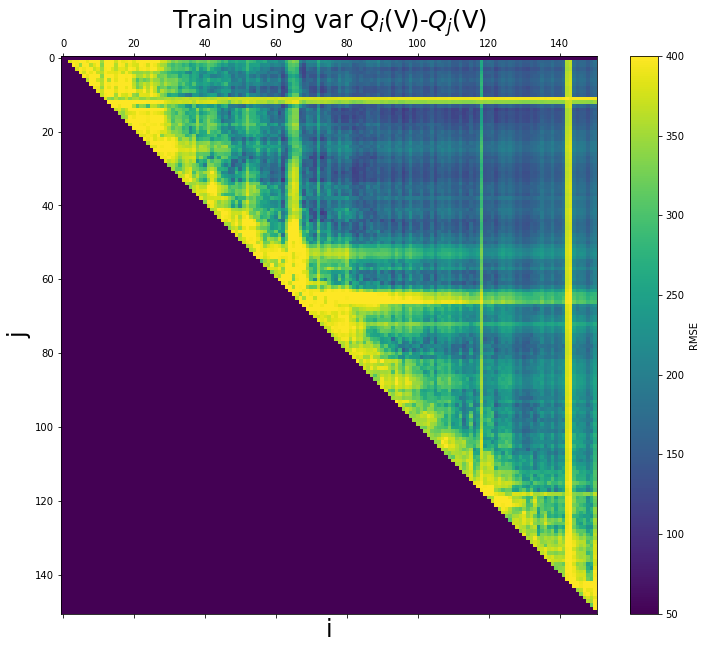

In [15]:
plt.figure(figsize=(12,10))
plt.matshow(mx_train, cmap=plt.cm.viridis,fignum=1,aspect='auto')
plt.clim(50,400)
plt.colorbar(label='RMSE')
plt.xlabel('i',fontsize=24)
plt.ylabel('j',fontsize=24)
plt.title('Train using var $Q_i$(V)-$Q_j$(V)',fontsize=24)
plt.show()

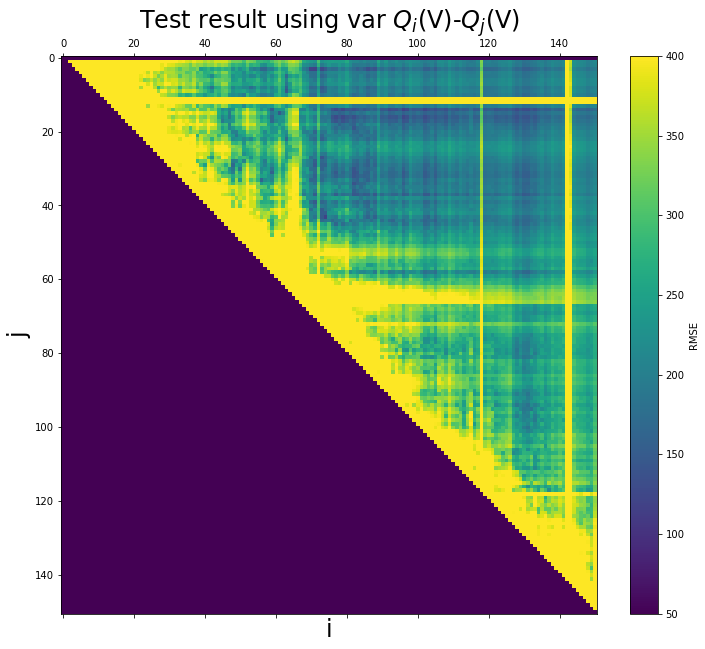

In [16]:
plt.figure(figsize=(12,10))
plt.matshow(mx_test, cmap=plt.cm.viridis,fignum=1,aspect='auto')
plt.clim(50,400)
plt.colorbar(label='RMSE')
plt.xlabel('i',fontsize=24)
plt.ylabel('j',fontsize=24)
plt.title('Test result using var $Q_i$(V)-$Q_j$(V)',fontsize=24)
plt.show()